<a href="https://colab.research.google.com/github/shubhamValkunde/Anomaly-Detection-NFV-Infrastructure-/blob/main/AnomalyDetectionUsingCombinedDetectionApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lower Bound is -3.505748632499998
Upper Bound is 44.0042487475


<ipython-input-2-a2bb408bedec>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'manual_label'] = 0
<ipython-input-2-a2bb408bedec>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
<ipython-input-2-a2bb408bedec>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

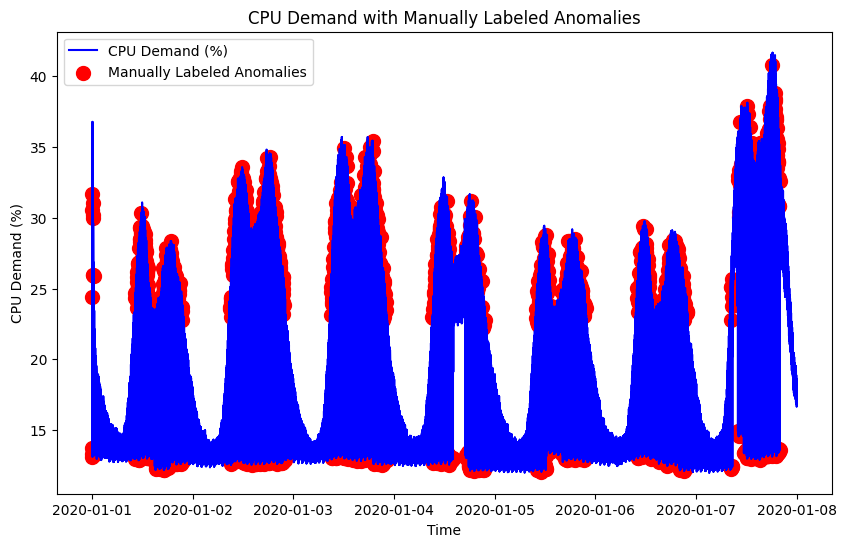

<ipython-input-2-a2bb408bedec>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'hour'] = first_week.index.hour
<ipython-input-2-a2bb408bedec>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'day_of_week'] = first_week.index.dayofweek
<ipython-input-2-a2bb408bedec>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Labeled dataset for the first week (with enhanced anomaly detection):
                     cpu|demandPct       ema  ema_diff  ema_anomaly   z_score  \
timestamp                                                                       
2020-01-01 00:04:00      -0.291459 -0.291459  0.000000            0 -0.291456   
2020-01-01 00:04:00       0.381668 -0.227351  0.609020            0  0.381665   
2020-01-01 00:04:00      -0.427995 -0.246460  0.181535            0 -0.427990   
2020-01-01 00:04:00       0.358861 -0.188810  0.547672            0  0.358858   
2020-01-01 00:04:00      -0.163347 -0.186385  0.023039            0 -0.163345   

                     z_score_anomaly  manual_label  combined_anomaly  
timestamp                                                             
2020-01-01 00:04:00                0             0                 0  
2020-01-01 00:04:00                0             0                 0  
2020-01-01 00:04:00                0             0                 0  
2020-01

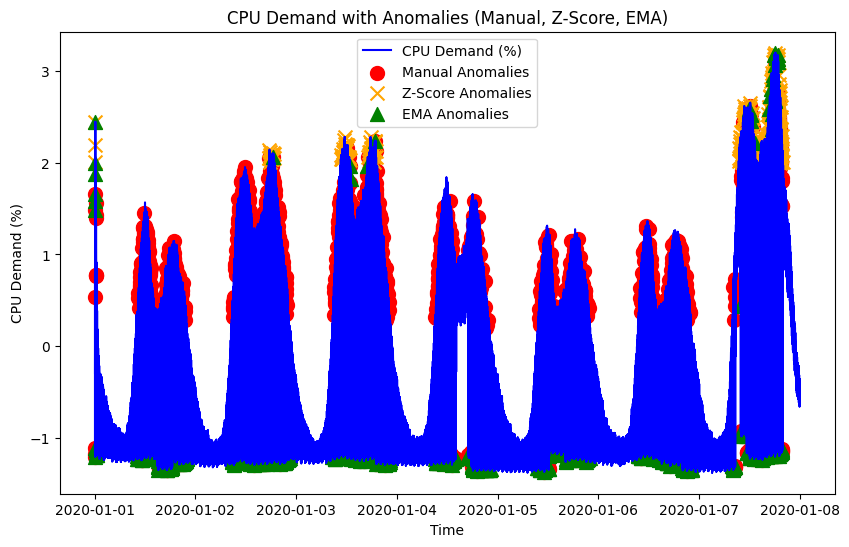

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/nfvData.csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Define the start and end date for filtering (one week)
start_date = pd.to_datetime('2020-01-01 00:00')
end_date = pd.to_datetime('2020-01-07 23:59')

# Filter the data for the first week
first_week = df.loc[start_date:end_date]

# 1. Manual Threshold-Based Anomaly Detection

# Calculate IQR for dynamic thresholds
Q1 = first_week['cpu|demandPct'].quantile(0.25)
Q3 = first_week['cpu|demandPct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower Bound is", lower_bound)
print("Upper Bound is", upper_bound)

# Add a 'manual_label' column for anomalies using .loc to avoid warnings
first_week.loc[:, 'manual_label'] = 0

# Update manual labels based on IQR thresholds
first_week.loc[first_week['cpu|demandPct'] > upper_bound, 'manual_label'] = 1  # Above upper threshold
first_week.loc[first_week['cpu|demandPct'] < lower_bound, 'manual_label'] = 1  # Below lower threshold

# Detect sudden jumps and mark as anomalies
first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
first_week.loc[first_week['diff'] > 10, 'manual_label'] = 1  # Sudden spike or drop greater than 10%

# Drop the 'diff' column as it's no longer needed
first_week.drop(columns=['diff'], inplace=True)

# 2. Plot the manually labeled anomalies before applying EMA
plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the manually labeled anomalies
anomalies = first_week[first_week['manual_label'] == 1]
plt.scatter(anomalies.index, anomalies['cpu|demandPct'], color='red', label='Manually Labeled Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Manually Labeled Anomalies')
plt.legend()

# Show the plot
plt.show()

# 3. Enhanced EMA-Based Anomaly Detection

# Add time-based features using .loc
first_week.loc[:, 'hour'] = first_week.index.hour
first_week.loc[:, 'day_of_week'] = first_week.index.dayofweek

# Create lag features for CPU demand
first_week.loc[:, 'lag_1'] = first_week['cpu|demandPct'].shift(1)
first_week.loc[:, 'lag_2'] = first_week['cpu|demandPct'].shift(2)

# Add rolling mean and standard deviation
first_week.loc[:, 'rolling_mean'] = first_week['cpu|demandPct'].rolling(window=3).mean()
first_week.loc[:, 'rolling_std'] = first_week['cpu|demandPct'].rolling(window=3).std()

# Drop rows with NaN values created by rolling operations
first_week.dropna(inplace=True)

# Standardize features for better performance
scaler = StandardScaler()
features_to_scale = ['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']
first_week[features_to_scale] = scaler.fit_transform(first_week[features_to_scale])

# Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week.loc[:, 'ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# Define an anomaly if the absolute difference between EMA and actual value is large
first_week.loc[:, 'ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# Set dynamic threshold for EMA anomalies (mean + 2*std)
ema_anomaly_threshold = first_week['ema_diff'].mean() + 2 * first_week['ema_diff'].std()

# Update the anomalies based on the threshold using .loc
first_week.loc[:, 'ema_anomaly'] = np.where(first_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# 4. Z-Score Based Anomaly Detection

# Calculate the Z-score for 'cpu|demandPct'
first_week['z_score'] = (first_week['cpu|demandPct'] - first_week['cpu|demandPct'].mean()) / first_week['cpu|demandPct'].std()

# Define the threshold for anomaly detection (e.g., Z-score > 2)
threshold_z_score = 2

# Label anomalies based on Z-score
first_week['z_score_anomaly'] = np.where(abs(first_week['z_score']) > threshold_z_score, 1, 0)

# 5. Combine EMA and Z-Score anomalies (but keep manual labeling intact)

# Combine results from both EMA and Z-score methods (without manual labeling)
first_week.loc[:, 'combined_anomaly'] = first_week[['ema_anomaly', 'z_score_anomaly']].max(axis=1)

# Save the labeled dataset
first_week.to_csv('/content/labeled_first_week_nfvData_enhanced_combined_zscore.csv')

# Display the labeled dataset with EMA anomaly labels and Z-score-based anomaly labels
print("Labeled dataset for the first week (with enhanced anomaly detection):")
print(first_week[['cpu|demandPct', 'ema', 'ema_diff', 'ema_anomaly', 'z_score', 'z_score_anomaly', 'manual_label', 'combined_anomaly']].head())

# Count and display anomalies
print("\nCombined Anomaly Detection Counts:")
print(first_week['combined_anomaly'].value_counts())

# 6. Plot the Z-score anomalies, EMA-based anomalies, and manually labeled anomalies
plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the manually labeled anomalies
manual_anomalies = first_week[first_week['manual_label'] == 1]
plt.scatter(manual_anomalies.index, manual_anomalies['cpu|demandPct'], color='red', label='Manual Anomalies', marker='o', s=100)

# Highlight the Z-score anomalies
zscore_anomalies = first_week[first_week['z_score_anomaly'] == 1]
plt.scatter(zscore_anomalies.index, zscore_anomalies['cpu|demandPct'], color='orange', label='Z-Score Anomalies', marker='x', s=100)

# Highlight the EMA-based anomalies
ema_anomalies = first_week[first_week['ema_anomaly'] == 1]
plt.scatter(ema_anomalies.index, ema_anomalies['cpu|demandPct'], color='green', label='EMA Anomalies', marker='^', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Anomalies (Manual, Z-Score, EMA)')
plt.legend()

# Show the plot
plt.show()


In [ ]:
print(f"Z-score Anomalies Count: {first_week['z_score_anomaly'].sum()}")


Z-score Anomalies Count: 987


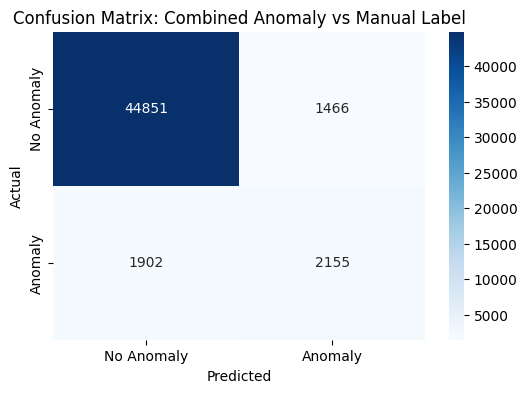

Confusion Matrix:
[[44851  1466]
 [ 1902  2155]]
Accuracy: 0.93
Precision: 0.60
Recall: 0.53
F1 Score: 0.56


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compare combined anomaly detection with manual labels
cm = confusion_matrix(first_week['manual_label'], first_week['combined_anomaly'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Anomaly', 'Anomaly'])
plt.title('Confusion Matrix: Combined Anomaly vs Manual Label')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: You can also calculate additional metrics if needed
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(first_week['manual_label'], first_week['combined_anomaly'])
precision = precision_score(first_week['manual_label'], first_week['combined_anomaly'])
recall = recall_score(first_week['manual_label'], first_week['combined_anomaly'])
f1 = f1_score(first_week['manual_label'], first_week['combined_anomaly'])

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


<ipython-input-4-3b90539d54d0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()
<ipython-input-4-3b90539d54d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])
<ipython-input-4-3b90539d54d0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

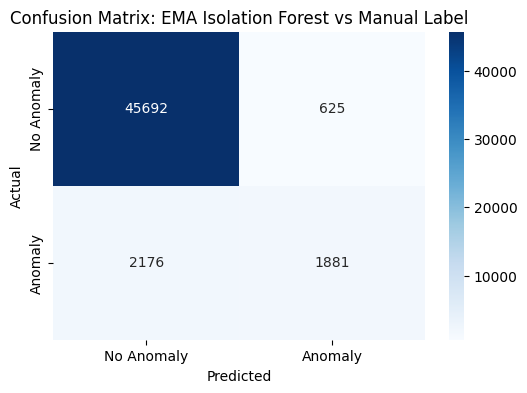

Confusion Matrix (EMA Isolation Forest):
[[45692   625]
 [ 2176  1881]]
Accuracy: 0.94
Precision: 0.75
Recall: 0.46
F1 Score: 0.57


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# 2. Calculate the absolute difference between the actual values and the EMA
first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# 3. Initialize and fit the Isolation Forest model on the ema_diff
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination as needed
first_week['ema_iforest_anomaly'] = iso_forest.fit_predict(first_week[['ema_diff']])

# Since Isolation Forest returns -1 for anomalies and 1 for normal, we convert it to 1 for anomalies and 0 for normal
first_week['ema_iforest_anomaly'] = first_week['ema_iforest_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# 4. Plot the confusion matrix comparing manual labeling and EMA Isolation Forest anomalies
cm_ema_iforest = confusion_matrix(first_week['manual_label'], first_week['ema_iforest_anomaly'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ema_iforest, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Anomaly', 'Anomaly'])
plt.title('Confusion Matrix: EMA Isolation Forest vs Manual Label')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix (EMA Isolation Forest):")
print(cm_ema_iforest)

# Optional: You can also calculate additional metrics for EMA Isolation Forest
accuracy_ema_iforest = accuracy_score(first_week['manual_label'], first_week['ema_iforest_anomaly'])
precision_ema_iforest = precision_score(first_week['manual_label'], first_week['ema_iforest_anomaly'])
recall_ema_iforest = recall_score(first_week['manual_label'], first_week['ema_iforest_anomaly'])
f1_ema_iforest = f1_score(first_week['manual_label'], first_week['ema_iforest_anomaly'])

print(f"Accuracy: {accuracy_ema_iforest:.2f}")
print(f"Precision: {precision_ema_iforest:.2f}")
print(f"Recall: {recall_ema_iforest:.2f}")
print(f"F1 Score: {f1_ema_iforest:.2f}")


<ipython-input-47-b080de0acce7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()
<ipython-input-47-b080de0acce7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])
<ipython-input-47-b080de0acce7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

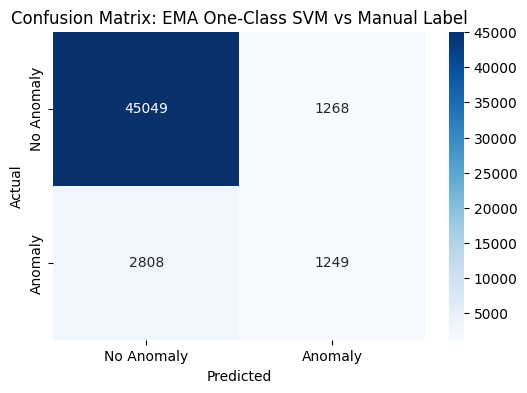

Confusion Matrix (EMA One-Class SVM):
[[45049  1268]
 [ 2808  1249]]
Accuracy: 0.92
Precision: 0.50
Recall: 0.31
F1 Score: 0.38


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# 2. Calculate the absolute difference between the actual values and the EMA
first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# 3. Initialize and fit the One-Class SVM model on the ema_diff
one_class_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")  # nu represents the outlier fraction
first_week['ema_ocsvm_anomaly'] = one_class_svm.fit_predict(first_week[['ema_diff']])

# One-Class SVM returns 1 for normal and -1 for anomalies, convert them to 1 for anomalies and 0 for normal
first_week['ema_ocsvm_anomaly'] = first_week['ema_ocsvm_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# 4. Plot the confusion matrix comparing manual labeling and EMA One-Class SVM anomalies
cm_ema_ocsvm = confusion_matrix(first_week['manual_label'], first_week['ema_ocsvm_anomaly'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ema_ocsvm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Anomaly', 'Anomaly'])
plt.title('Confusion Matrix: EMA One-Class SVM vs Manual Label')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix (EMA One-Class SVM):")
print(cm_ema_ocsvm)

# Optional: You can also calculate additional metrics for EMA One-Class SVM
accuracy_ema_ocsvm = accuracy_score(first_week['manual_label'], first_week['ema_ocsvm_anomaly'])
precision_ema_ocsvm = precision_score(first_week['manual_label'], first_week['ema_ocsvm_anomaly'])
recall_ema_ocsvm = recall_score(first_week['manual_label'], first_week['ema_ocsvm_anomaly'])
f1_ema_ocsvm = f1_score(first_week['manual_label'], first_week['ema_ocsvm_anomaly'])

print(f"Accuracy: {accuracy_ema_ocsvm:.2f}")
print(f"Precision: {precision_ema_ocsvm:.2f}")
print(f"Recall: {recall_ema_ocsvm:.2f}")
print(f"F1 Score: {f1_ema_ocsvm:.2f}")


<ipython-input-8-a92dd0fd0713>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["resName_encoded"] = encoder.fit_transform(one_day_data["resName"])
<ipython-input-8-a92dd0fd0713>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["cpu|demandPct_scaled"] = scaler.fit_transform(one_day_data[["cpu|demandPct"]])
<ipython-input-8-a92dd0fd0713>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

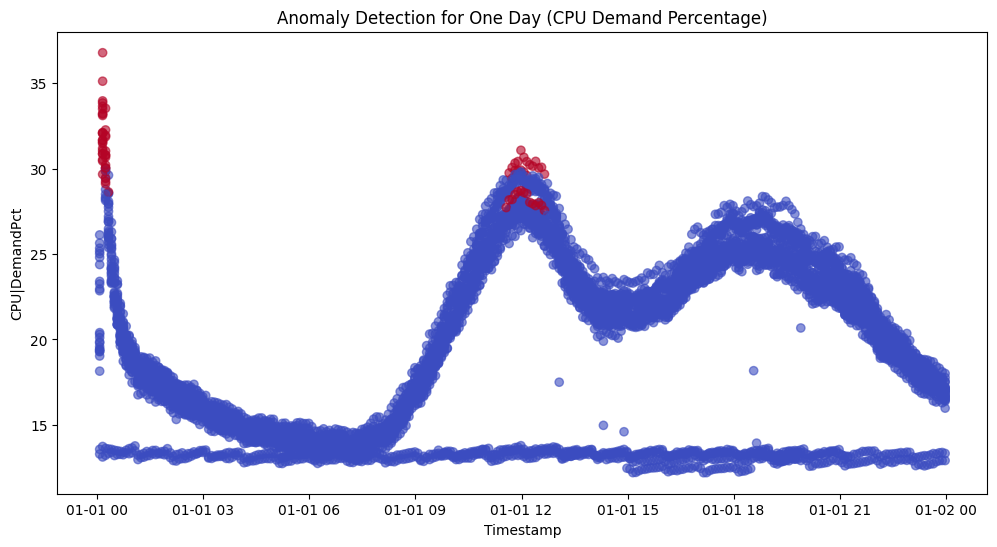

Anomaly detection results saved to 'one_day_anomaly_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

try:
    # Load dataset
    file_path = "/nfvData (1).csv"  # Adjust if necessary
    data = pd.read_csv(file_path)

    # Handle missing values
    if "cpu|demandPct" not in data.columns or "resName" not in data.columns:
        raise ValueError("Required columns 'cpu|demandPct' or 'resName' are missing.")

    data = data.dropna(subset=["cpu|demandPct"])

    # Convert timestamp to datetime
    data["timestamp"] = pd.to_datetime(data["timestamp"], format="%d-%m-%Y %H:%M", errors="coerce")
    if data["timestamp"].isna().all():
        raise ValueError("All timestamp values could not be parsed.")

    # Filter data for one day (e.g., "01-01-2024")
    one_day_data = data[data["timestamp"].dt.date == pd.to_datetime("01-01-2020").date()]
    if one_day_data.empty:
        raise ValueError("No data found for the specified date (01-01-2024).")

    # Preprocess data
    encoder = LabelEncoder()
    one_day_data["resName_encoded"] = encoder.fit_transform(one_day_data["resName"])

    scaler = StandardScaler()
    one_day_data["cpu|demandPct_scaled"] = scaler.fit_transform(one_day_data[["cpu|demandPct"]])

    # Features for anomaly detection
    features = one_day_data[["resName_encoded", "cpu|demandPct_scaled"]]

    # Anomaly detection using Isolation Forest
    model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    one_day_data["anomaly"] = model.fit_predict(features)

    # Map anomalies: -1 (anomaly) -> 1, 1 (normal) -> 0
    one_day_data["anomaly"] = one_day_data["anomaly"].apply(lambda x: 1 if x == -1 else 0)

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.scatter(
        one_day_data["timestamp"],
        one_day_data["cpu|demandPct"],
        c=one_day_data["anomaly"],
        cmap="coolwarm",
        alpha=0.6,
    )
    plt.title("Anomaly Detection for One Day (CPU Demand Percentage)")
    plt.xlabel("Timestamp")
    plt.ylabel("CPU|DemandPct")
    plt.show()

    # Save the filtered and processed data with anomalies
    one_day_data.to_csv("one_day_anomaly_results.csv", index=False)
    print("Anomaly detection results saved to 'one_day_anomaly_results.csv'.")

except Exception as e:
    print(f"Error: {e}")


<ipython-input-6-e2d7d7f88d98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()
<ipython-input-6-e2d7d7f88d98>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])
<ipython-input-6-e2d7d7f88d98>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

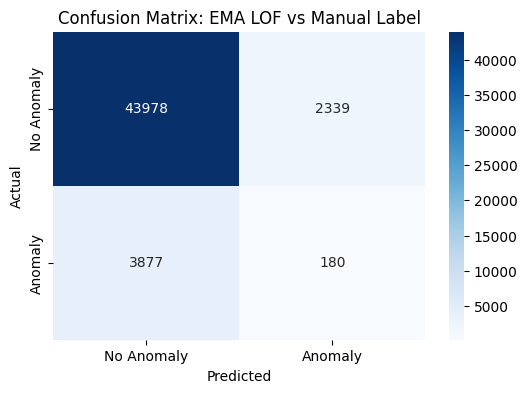

Confusion Matrix (EMA LOF):
[[43978  2339]
 [ 3877   180]]
Accuracy: 0.88
Precision: 0.07
Recall: 0.04
F1 Score: 0.05


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# 2. Calculate the absolute difference between the actual values and the EMA
first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# 3. Initialize and fit the Local Outlier Factor model on the ema_diff
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination as needed
first_week['ema_lof_anomaly'] = lof.fit_predict(first_week[['ema_diff']])

# Since LOF assigns -1 for anomalies and 1 for normal, we convert it to 1 for anomalies and 0 for normal
first_week['ema_lof_anomaly'] = first_week['ema_lof_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# 4. Plot the confusion matrix comparing manual labeling and EMA LOF anomalies
cm_ema_lof = confusion_matrix(first_week['manual_label'], first_week['ema_lof_anomaly'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ema_lof, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Anomaly', 'Anomaly'])
plt.title('Confusion Matrix: EMA LOF vs Manual Label')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix (EMA LOF):")
print(cm_ema_lof)

# Optional: You can also calculate additional metrics for EMA LOF
accuracy_ema_lof = accuracy_score(first_week['manual_label'], first_week['ema_lof_anomaly'])
precision_ema_lof = precision_score(first_week['manual_label'], first_week['ema_lof_anomaly'])
recall_ema_lof = recall_score(first_week['manual_label'], first_week['ema_lof_anomaly'])
f1_ema_lof = f1_score(first_week['manual_label'], first_week['ema_lof_anomaly'])

print(f"Accuracy: {accuracy_ema_lof:.2f}")
print(f"Precision: {precision_ema_lof:.2f}")
print(f"Recall: {recall_ema_lof:.2f}")
print(f"F1 Score: {f1_ema_lof:.2f}")


<ipython-input-7-02aa4e830f05>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()
<ipython-input-7-02aa4e830f05>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])
<ipython-input-7-02aa4e830f05>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

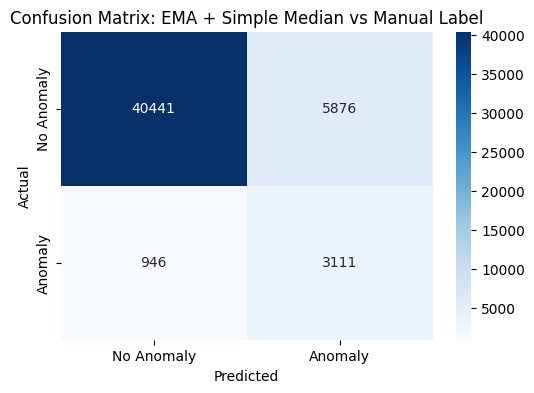

Confusion Matrix (EMA + Simple Median):
[[40441  5876]
 [  946  3111]]
Accuracy: 0.86
Precision: 0.35
Recall: 0.77
F1 Score: 0.48


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week['ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# 2. Calculate the absolute difference between the actual values and the EMA
first_week['ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# 3. Calculate the Median and Median Absolute Deviation (MAD)
median = first_week['ema_diff'].median()
mad = np.median(np.abs(first_week['ema_diff'] - median))

# Define a threshold for anomaly detection (e.g., 3 times the MAD)
threshold = 3 * mad

# 4. Detect anomalies based on the threshold
first_week['ema_median_anomaly'] = first_week['ema_diff'].apply(lambda x: 1 if abs(x - median) > threshold else 0)

# 5. Plot the confusion matrix comparing manual labeling and EMA + Simple Median anomalies
cm_ema_median = confusion_matrix(first_week['manual_label'], first_week['ema_median_anomaly'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ema_median, annot=True, fmt='d', cmap='Blues', xticklabels=['No Anomaly', 'Anomaly'], yticklabels=['No Anomaly', 'Anomaly'])
plt.title('Confusion Matrix: EMA + Simple Median vs Manual Label')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the confusion matrix
print("Confusion Matrix (EMA + Simple Median):")
print(cm_ema_median)

# 6. Calculate additional metrics for EMA + Simple Median
accuracy_ema_median = accuracy_score(first_week['manual_label'], first_week['ema_median_anomaly'])
precision_ema_median = precision_score(first_week['manual_label'], first_week['ema_median_anomaly'])
recall_ema_median = recall_score(first_week['manual_label'], first_week['ema_median_anomaly'])
f1_ema_median = f1_score(first_week['manual_label'], first_week['ema_median_anomaly'])

print(f"Accuracy: {accuracy_ema_median:.2f}")
print(f"Precision: {precision_ema_median:.2f}")
print(f"Recall: {recall_ema_median:.2f}")
print(f"F1 Score: {f1_ema_median:.2f}")


<ipython-input-13-ffb8cabdd88a>:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_cpu_usage = one_day_data[numeric_columns.columns].resample('H').mean()


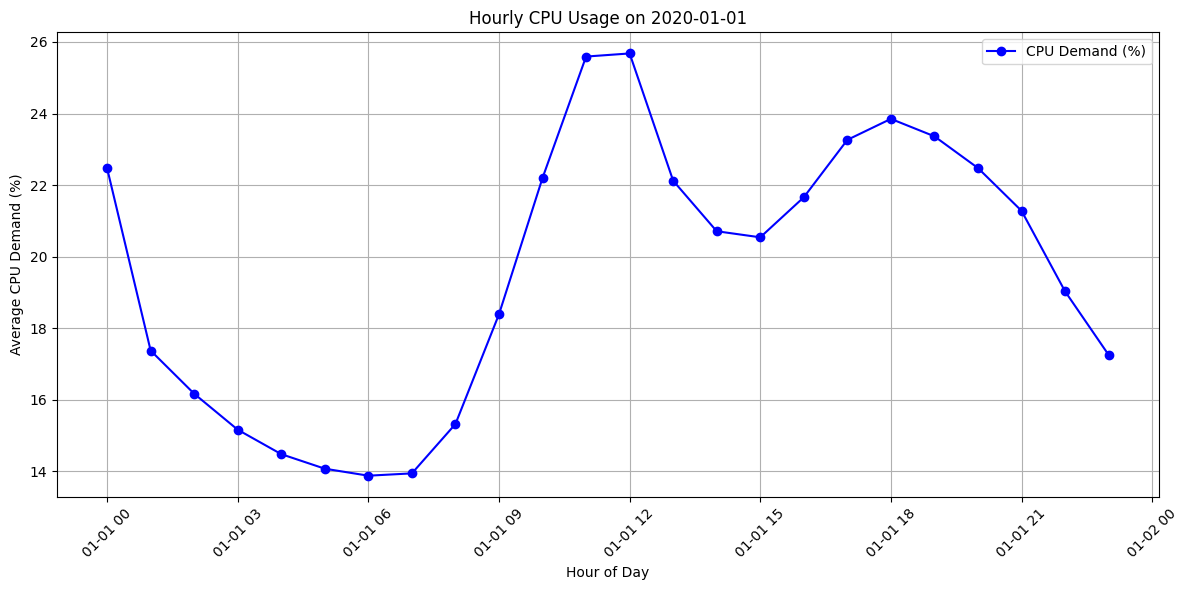

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/nfvData.csv')

# Convert the 'timestamp' column to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Filter numeric columns to avoid errors during resampling
numeric_columns = df.select_dtypes(include=['number'])

# Add a new column for the date
df['date'] = df.index.date

# Select a single day (replace 'YYYY-MM-DD' with an actual date from your dataset)
selected_date = pd.to_datetime('2020-01-01').date()  # Example date
one_day_data = df[df['date'] == selected_date]

# Group numeric data by hour and calculate the average for each hour
hourly_cpu_usage = one_day_data[numeric_columns.columns].resample('H').mean()

# Plot the hourly CPU usage
plt.figure(figsize=(12, 6))
plt.plot(hourly_cpu_usage.index, hourly_cpu_usage['cpu|demandPct'], marker='o', color='blue', label='CPU Demand (%)')

# Add labels, title, and grid
plt.xlabel('Hour of Day')
plt.ylabel('Average CPU Demand (%)')
plt.title(f'Hourly CPU Usage on {selected_date}')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-46-596cf970ec38>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_5_days['hour'] = df_first_5_days['timestamp'].dt.hour


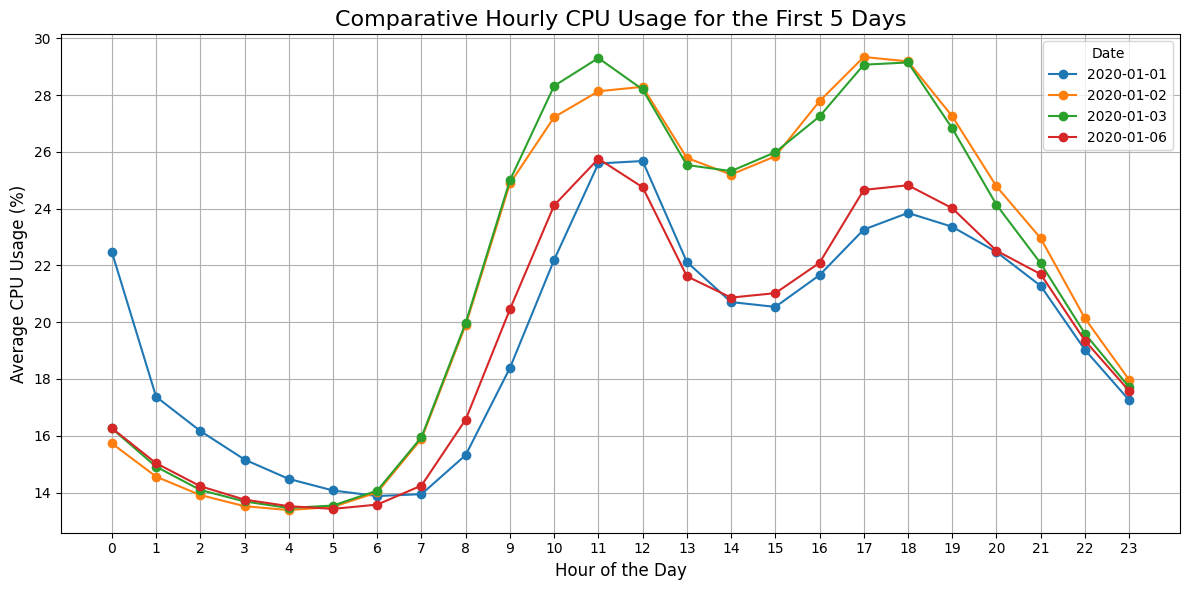

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

df = pd.read_csv('/content/nfvData.csv')
# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for the first 5 days (adjust the date format if necessary)
# Assuming '2020-01-01' as the starting date of the dataset
df_first_5_days = df[df['timestamp'].dt.date.isin(pd.to_datetime(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06']).date)]

# Step 3: Group data by hour to get the average CPU usage for each hour
df_first_5_days['hour'] = df_first_5_days['timestamp'].dt.hour
df_grouped = df_first_5_days.groupby(['hour', df_first_5_days['timestamp'].dt.date])['cpu|demandPct'].mean().unstack()

# Step 4: Plot the data
plt.figure(figsize=(12, 6))

# Plot each day on the same graph
for day in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[day], marker='o', label=str(day))

# Adding labels and title
plt.title('Comparative Hourly CPU Usage for the First 5 Days', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average CPU Usage (%)', fontsize=12)
plt.xticks(df_grouped.index)  # Display every hour on x-axis
plt.legend(title="Date", loc='upper right')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-54-dcb8a1674147>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_5_days['hour'] = df_first_5_days['timestamp'].dt.hour


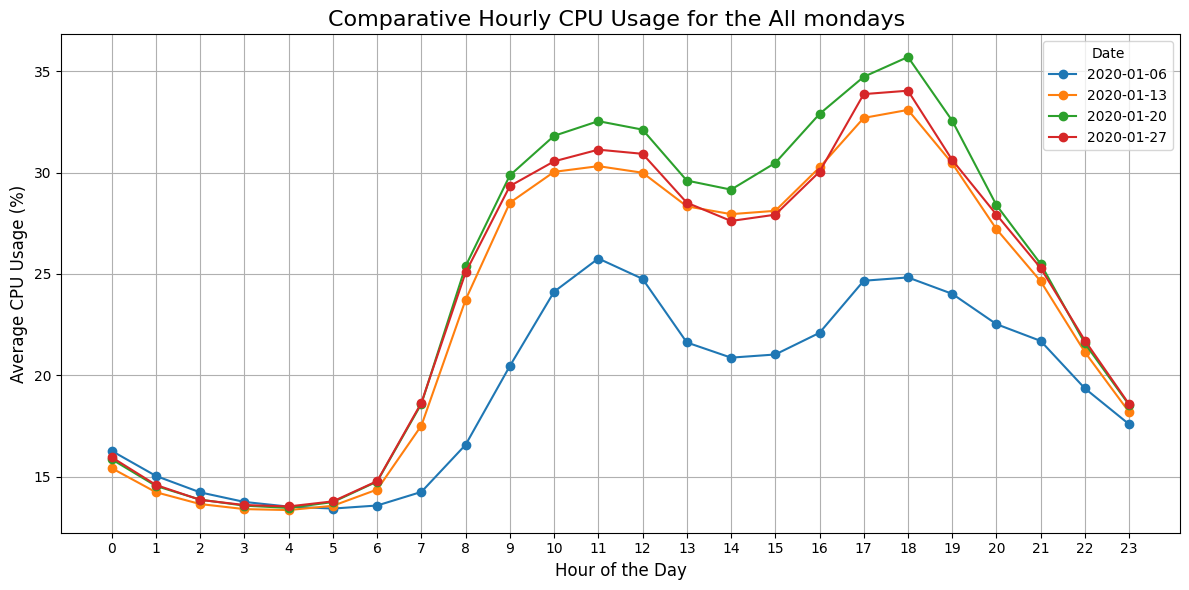

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

df = pd.read_csv('/content/nfvData.csv')
# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for the first 5 days (adjust the date format if necessary)
# Assuming '2020-01-01' as the starting date of the dataset
df_first_5_days = df[df['timestamp'].dt.date.isin(pd.to_datetime(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27']).date)]

# Step 3: Group data by hour to get the average CPU usage for each hour
df_first_5_days['hour'] = df_first_5_days['timestamp'].dt.hour
df_grouped = df_first_5_days.groupby(['hour', df_first_5_days['timestamp'].dt.date])['cpu|demandPct'].mean().unstack()

# Step 4: Plot the data
plt.figure(figsize=(12, 6))

# Plot each day on the same graph
for day in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[day], marker='o', label=str(day))

# Adding labels and title
plt.title('Comparative Hourly CPU Usage for the All mondays ', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average CPU Usage (%)', fontsize=12)
plt.xticks(df_grouped.index)  # Display every hour on x-axis
plt.legend(title="Date", loc='upper right')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



<ipython-input-47-f95d7edb3864>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mondays['hour'] = df_mondays['timestamp'].dt.hour


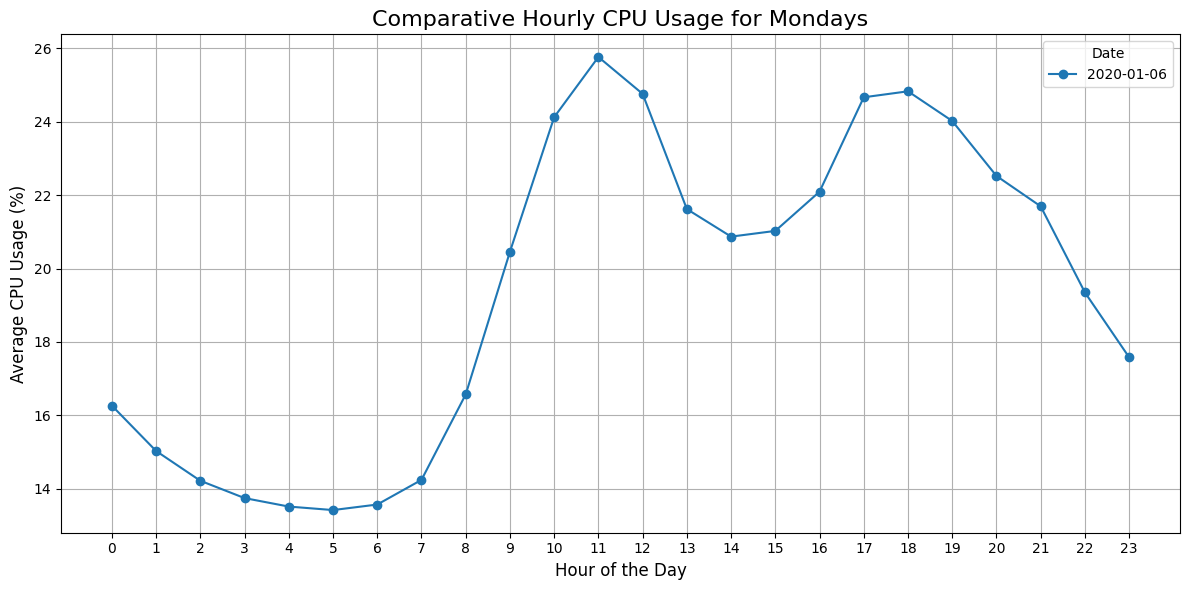

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed
df = pd.read_csv('/content/nfvData.csv')

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Add 'weekDay' column to get the day of the week
# Monday = 0, Sunday = 6
df['weekDay'] = df['timestamp'].dt.weekday

# Step 3: Filter data for the first 5 days (adjust the date format if necessary)
# Assuming '2020-01-01' as the starting date of the dataset
df_first_5_days = df[df['timestamp'].dt.date.isin(pd.to_datetime(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06']).date)]

# Step 4: Filter for Mondays only (weekDay == 0)
df_mondays = df_first_5_days[df_first_5_days['weekDay'] == 0]

# Step 5: Group data by hour to get the average CPU usage for each hour
df_mondays['hour'] = df_mondays['timestamp'].dt.hour
df_grouped = df_mondays.groupby(['hour', df_mondays['timestamp'].dt.date])['cpu|demandPct'].mean().unstack()

# Step 6: Plot the data for Mondays only
plt.figure(figsize=(12, 6))

# Plot each Monday on the same graph
for day in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[day], marker='o', label=str(day))

# Adding labels and title
plt.title('Comparative Hourly CPU Usage for Mondays', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average CPU Usage (%)', fontsize=12)
plt.xticks(df_grouped.index)  # Display every hour on x-axis
plt.legend(title="Date", loc='upper right')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


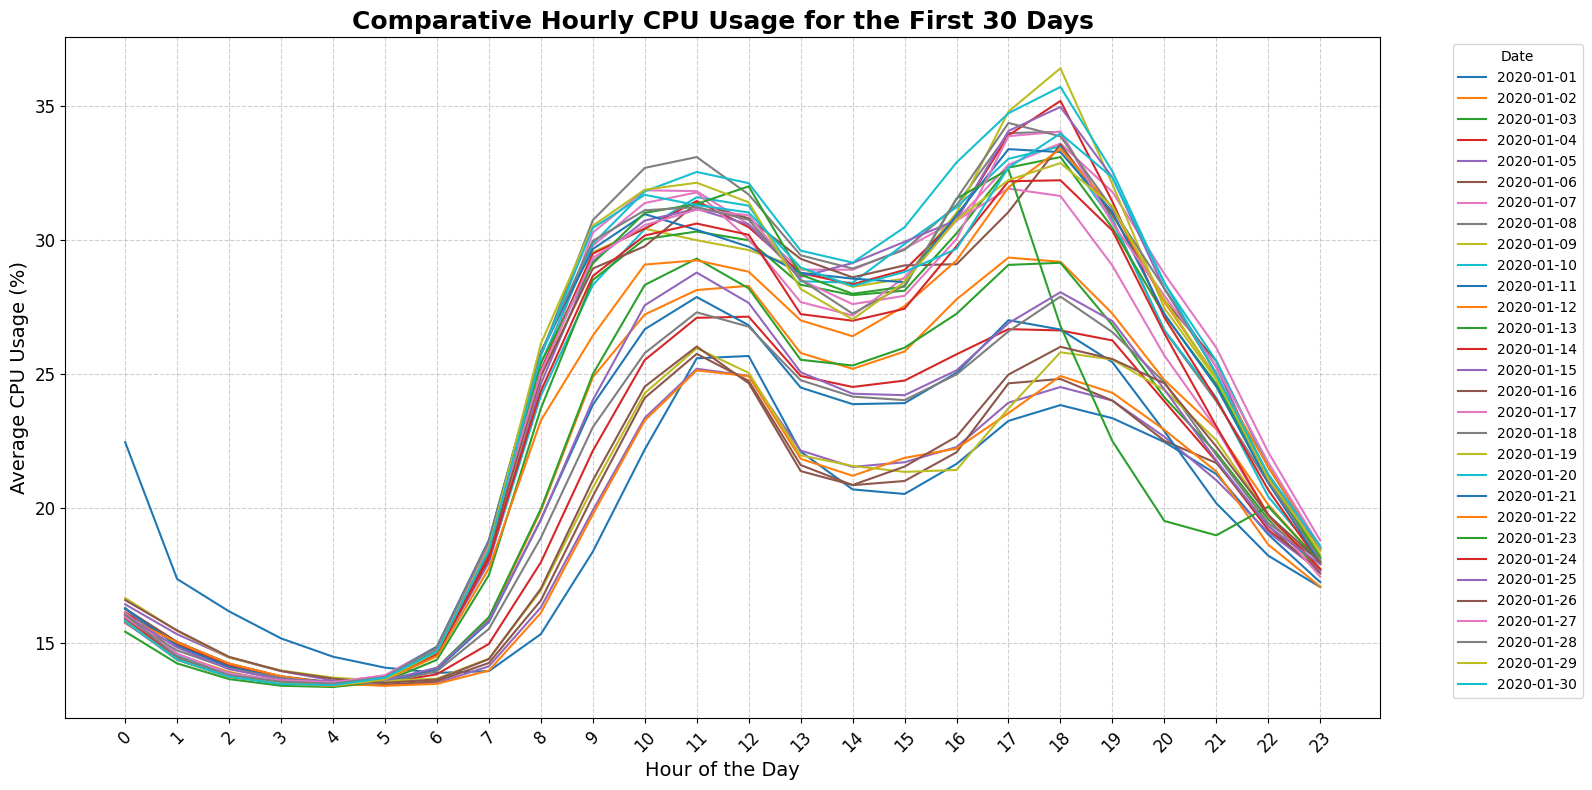

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for the first 30 days (adjust the date format if necessary)
# Assuming the dataset starts from '2020-01-01'
date_range = pd.to_datetime(['2020-01-01'] + pd.date_range(start='2020-01-02', periods=29).strftime('%Y-%m-%d').tolist())
df_first_30_days = df[df['timestamp'].dt.date.isin(date_range.date)]

# Step 3: Group data by hour to get the average CPU usage for each hour
df_first_30_days['hour'] = df_first_30_days['timestamp'].dt.hour
df_grouped = df_first_30_days.groupby(['hour', df_first_30_days['timestamp'].dt.date])['cpu|demandPct'].mean().unstack()

# Step 4: Plot the data
plt.figure(figsize=(14, 8))

# Plot each day on the same graph with thin lines
for day in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[day], label=str(day), linewidth=1.5)  # thinner lines

# Adding labels and title with a professional look
plt.title('Comparative Hourly CPU Usage for the First 30 Days', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average CPU Usage (%)', fontsize=14)

# Make the x-axis more readable
plt.xticks(df_grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding a grid for readability and tightening layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()



# 7. Improve the layout and display the legend without overcrowding
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


Day with highest CPU usage: 2020-01-20 with an average CPU usage of 24.55%
Day with lowest CPU usage: 2020-01-12 with an average CPU usage of 19.27%


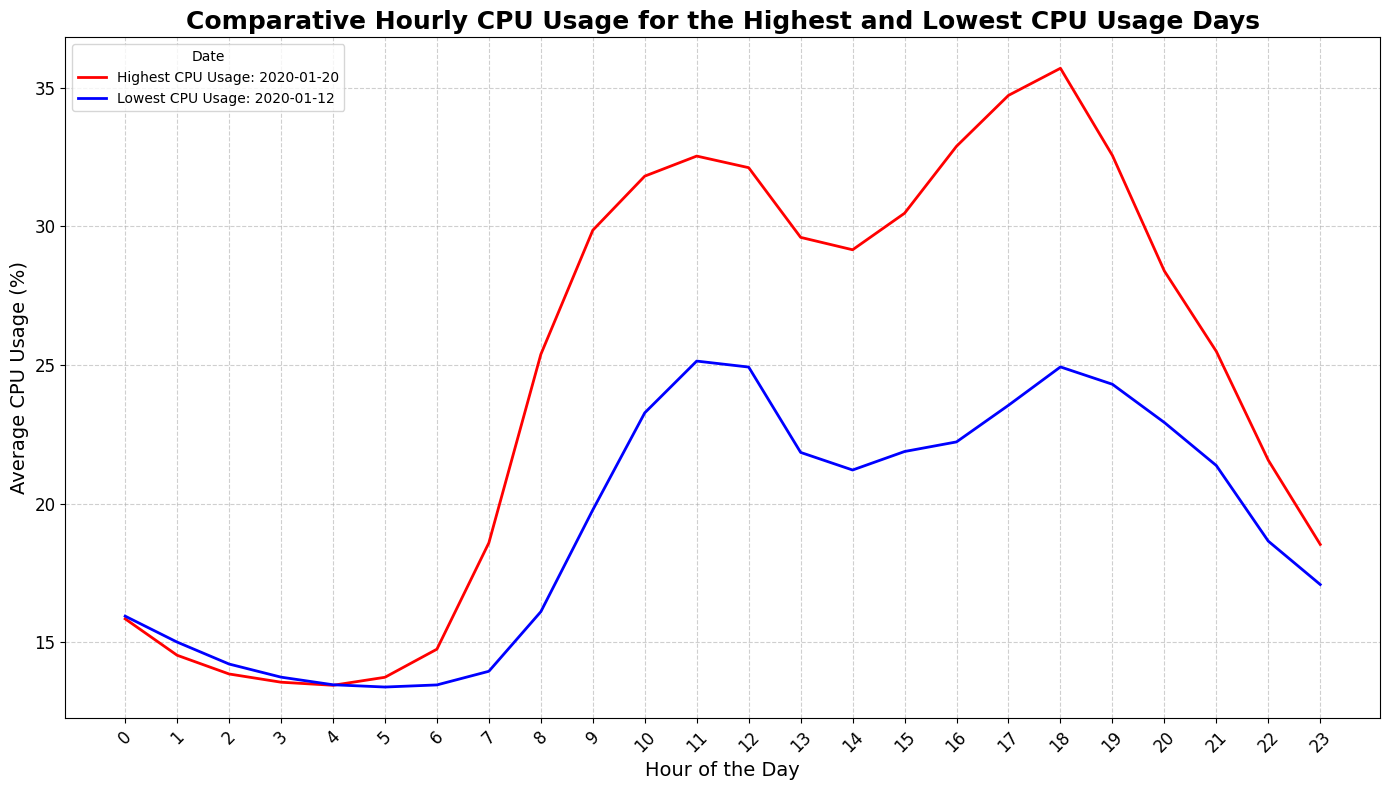

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for the first 30 days (adjust the date format if necessary)
# Assuming the dataset starts from '2020-01-01'
date_range = pd.to_datetime(['2020-01-01'] + pd.date_range(start='2020-01-02', periods=29).strftime('%Y-%m-%d').tolist())
df_first_30_days = df[df['timestamp'].dt.date.isin(date_range.date)]

# Step 3: Group data by hour to get the average CPU usage for each hour
df_first_30_days['hour'] = df_first_30_days['timestamp'].dt.hour
df_grouped = df_first_30_days.groupby(['hour', df_first_30_days['timestamp'].dt.date])['cpu|demandPct'].mean().unstack()

# Step 4: Calculate the average CPU usage for each day by averaging the hourly values for each date
daily_avg_cpu_usage = df_grouped.mean(axis=0)

# Step 5: Find the two days with the highest and lowest average CPU usage
highest_day = daily_avg_cpu_usage.idxmax()
highest_usage = daily_avg_cpu_usage.max()

lowest_day = daily_avg_cpu_usage.idxmin()
lowest_usage = daily_avg_cpu_usage.min()

# Output the results
print(f"Day with highest CPU usage: {highest_day} with an average CPU usage of {highest_usage:.2f}%")
print(f"Day with lowest CPU usage: {lowest_day} with an average CPU usage of {lowest_usage:.2f}%")

# Step 6: Plot only the two lines for the highest and lowest CPU usage days
plt.figure(figsize=(14, 8))

# Plot the line for the day with highest CPU usage
plt.plot(df_grouped.index, df_grouped[highest_day], label=f'Highest CPU Usage: {highest_day}', color='red', linewidth=2)

# Plot the line for the day with lowest CPU usage
plt.plot(df_grouped.index, df_grouped[lowest_day], label=f'Lowest CPU Usage: {lowest_day}', color='blue', linewidth=2)

# Adding labels and title with a professional look
plt.title('Comparative Hourly CPU Usage for the Highest and Lowest CPU Usage Days', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average CPU Usage (%)', fontsize=14)

# Make the x-axis more readable
plt.xticks(df_grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding a grid for readability and tightening layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Add legend and show the plot
plt.legend(title='Date', loc='upper left', fontsize=10)
plt.show()


In [ ]:
print(df.columns)


Index(['date', 'cpu_usage', 'timestamp', 'day_of_week'], dtype='object')


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for the first 30 days (adjust the date format if necessary)
date_range = pd.to_datetime(['2020-01-01'] + pd.date_range(start='2020-01-02', periods=29).strftime('%Y-%m-%d').tolist())
df_first_30_days = df[df['timestamp'].dt.date.isin(date_range.date)]

# Step 3: Group data by hour to get the average CPU usage for each hour
df_first_30_days['hour'] = df_first_30_days['timestamp'].dt.hour
df_grouped = df_first_30_days.groupby(['hour', df_first_30_days['timestamp'].dt.date])['cpu_usage'].mean().unstack()

# Step 4: Filter the specific days you want to plot (1, 2, 3, and 6)
selected_days = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06']

# Convert selected_days to datetime format to ensure proper matching
selected_days = pd.to_datetime(selected_days)

# Step 5: Filter df_grouped for selected days based on the index
df_selected_days = df_grouped[selected_days]

# Step 6: Plot the lines for the selected days (1, 2, 3, and 6)
plt.figure(figsize=(14, 8))

for day in selected_days:
    day_str = day.strftime('%Y-%m-%d')  # Format date to string for plotting
    plt.plot(df_selected_days.index, df_selected_days[day_str], label=f'Day {day_str[-2:]}', linewidth=2)

# Adding labels and title with a professional look
plt.title('Comparative Hourly CPU Usage for Selected Days', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average CPU Usage (%)', fontsize=14)

# Make the x-axis more readable
plt.xticks(df_selected_days.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding a grid for readability and tightening layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Add legend and show the plot
plt.legend(title='Date', loc='upper left', fontsize=10)
plt.show()


KeyError: '2020-01-01'

<Figure size 1400x800 with 0 Axes>

<ipython-input-21-3546cdaeb10f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jan_11['hour'] = df_jan_11['timestamp'].dt.hour


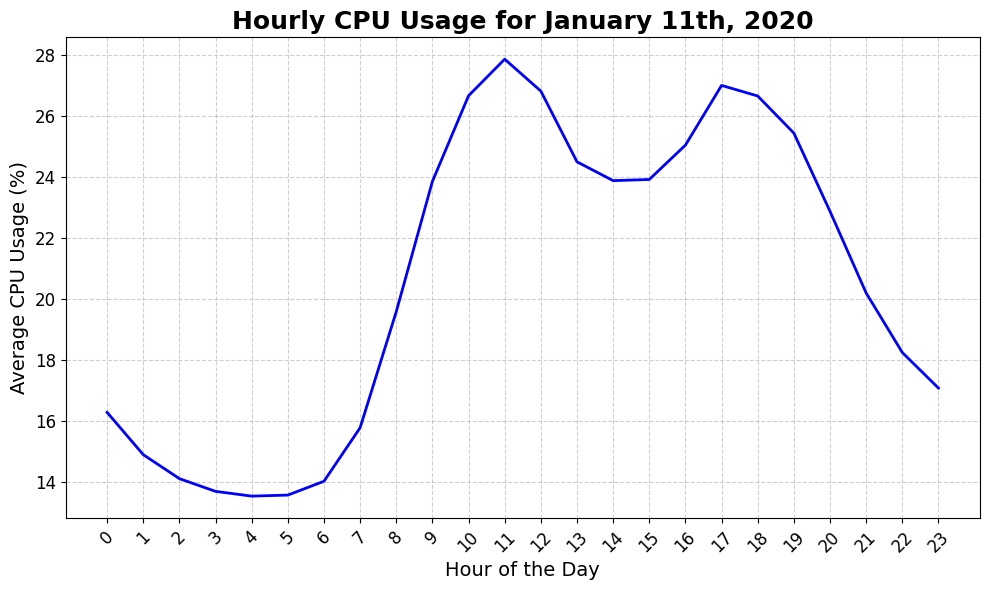

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Filter data for January 11th, 2020
df_jan_11 = df[df['timestamp'].dt.date == pd.to_datetime('2020-01-11').date()]

# Step 3: Group data by hour to get the average CPU usage for each hour on January 11th, 2020
df_jan_11['hour'] = df_jan_11['timestamp'].dt.hour
df_jan_11_grouped = df_jan_11.groupby('hour')['cpu|demandPct'].mean()

# Step 4: Plot the data for January 11th, 2020
plt.figure(figsize=(10, 6))
plt.plot(df_jan_11_grouped.index, df_jan_11_grouped, label="CPU Usage on 2020-01-11", color='blue', linewidth=2)

# Adding labels and title
plt.title('Hourly CPU Usage for January 11th, 2020', fontsize=18, weight='bold')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average CPU Usage (%)', fontsize=14)

# Make the x-axis more readable
plt.xticks(df_jan_11_grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding a grid for readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import pandas as pd

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Group data by date and calculate the average CPU usage for each day
df['date'] = df['timestamp'].dt.date
df_daily_avg = df.groupby('date')['cpu|demandPct'].mean()

# Print the average CPU utilization for each day
print(df_daily_avg)


date
2020-01-01    19.594510
2020-01-02    21.629076
2020-01-03    21.643827
2020-01-04    20.702700
2020-01-05    19.385986
2020-01-06    19.414415
2020-01-07    24.113161
2020-01-08    24.186179
2020-01-09    23.912184
2020-01-10    23.657913
2020-01-11    20.636760
2020-01-12    19.278814
2020-01-13    23.337485
2020-01-14    23.806436
2020-01-15    24.008966
2020-01-16    23.705240
2020-01-17    23.350212
2020-01-18    20.836644
2020-01-19    19.782607
2020-01-20    24.549329
2020-01-21    23.730073
2020-01-22    23.041104
2020-01-23    22.588129
2020-01-24    23.114651
2020-01-25    21.497403
2020-01-26    19.864659
2020-01-27    23.826566
2020-01-28    23.952956
2020-01-29    23.859097
2020-01-30    24.015280
Name: cpu|demandPct, dtype: float64


In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Group by day_of_week and calculate the average CPU usage for each day of the week
avg_cpu_by_day = df.groupby('day_of_week')['cpu_usage'].mean()

# Display the average CPU usage for each day of the week
print(avg_cpu_by_day)


day_of_week
0    22.781949
1    23.900657
2    22.937971
3    23.169982
4    22.941651
5    20.918377
6    19.578017
Name: cpu_usage, dtype: float64


In [ ]:
import pandas as pd

# Load the NFV data (assuming it is stored in a CSV file)
df = pd.read_csv('/content/nfvData.csv')  # Replace with the path to your data file

# Step 1: Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Extract the relevant CPU usage column (assuming 'cpu|demandPct' as the column name)
# Replace 'cpu|demandPct' with the actual column name if it's different in your dataset
df['cpu_usage'] = df['cpu|demandPct']  # Ensure the correct column is referenced

# Step 4: Group by 'day_of_week' and calculate the average CPU usage for each day of the week
avg_cpu_by_day = df.groupby('day_of_week')['cpu_usage'].mean()

# Display the average CPU usage for each day of the week
print(avg_cpu_by_day)


day_of_week
0    22.781949
1    23.900797
2    22.937590
3    23.169865
4    22.941303
5    20.911788
6    19.578131
Name: cpu_usage, dtype: float64


In [ ]:
import pandas as pd

# Load the NFV data (assuming it is stored in a CSV file)
df = pd.read_csv('/content/nfvData.csv')  # Replace with the path to your data file

# Step 1: Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Extract the relevant CPU usage column (assuming 'cpu|demandPct' as the column name)
# Replace 'cpu|demandPct' with the actual column name if it's different in your dataset
df['cpu_usage'] = df['cpu|demandPct']  # Ensure the correct column is referenced

# Step 4: Filter data for Mondays (day_of_week = 0)
df_mondays = df[df['day_of_week'] == 0]

# Step 5: Print the data for Mondays
print(df_mondays[['timestamp', 'cpu_usage']])


                 timestamp  cpu_usage
1440   2020-01-06 00:04:00  16.798000
1441   2020-01-06 00:09:00  16.570000
1442   2020-01-06 00:14:00  16.482000
1443   2020-01-06 00:19:00  16.255333
1444   2020-01-06 00:24:00  16.257334
...                    ...        ...
215105 2020-01-27 23:39:00  17.488001
215106 2020-01-27 23:44:00  17.431334
215107 2020-01-27 23:49:00  17.342667
215108 2020-01-27 23:54:00  17.008667
215109 2020-01-27 23:59:00  16.808666

[28800 rows x 2 columns]


In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Group by day_of_week and calculate the average, least, and standard deviation of CPU usage for each day
avg_cpu_by_day = df.groupby('day_of_week')['cpu_usage'].mean()
least_cpu_by_day = df.groupby('day_of_week')['cpu_usage'].min()
std_dev_cpu_by_day = df.groupby('day_of_week')['cpu_usage'].std()

# Step 4: Combine all the results into a single DataFrame
cpu_summary = pd.DataFrame({
    'avg_cpu_usage': avg_cpu_by_day,
    'least_cpu_usage': least_cpu_by_day,
    'std_dev_cpu_usage': std_dev_cpu_by_day
})

# Step 5: Filter rows where the standard deviation is greater than 0.8
filtered_cpu_summary = cpu_summary[cpu_summary['std_dev_cpu_usage'] > 0.8]

# Display the filtered result
print(filtered_cpu_summary)


             avg_cpu_usage  least_cpu_usage  std_dev_cpu_usage
day_of_week                                                   
0                22.781949        19.414415           2.299548
2                22.937971        19.594510           1.919824
3                23.169982        21.629076           1.032574
4                22.941651        21.643827           0.893351


In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Calculate average, least, and standard deviation of CPU usage for each day of the week
summary = df.groupby('day_of_week')['cpu_usage'].agg(['mean', 'min', 'std']).reset_index()

# Step 3: Filter days with std > 0.8
filtered_summary = summary[summary['std'] > 0.8]

# Step 4: Find dates where the CPU usage is the least for that day of the week and match std > 0.8
result = df[df.apply(lambda x: x['cpu_usage'] == filtered_summary.loc[
    (filtered_summary['day_of_week'] == x['day_of_week']), 'min'].values[0]
    if not filtered_summary.loc[(filtered_summary['day_of_week'] == x['day_of_week']), 'min'].empty
    else False, axis=1
)]

# Display the result
print(result[['date', 'cpu_usage']])


         date  cpu_usage
0  2020-01-01  19.594510
1  2020-01-02  21.629076
2  2020-01-03  21.643827
5  2020-01-06  19.414415


In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Calculate the standard deviation for each day of the week
summary = df.groupby('day_of_week')['cpu_usage'].agg(['std', 'min']).reset_index()

# Step 3: Set the threshold for standard deviation to classify anomalies
std_threshold = 0.8

# Step 4: Merge the summary with the original dataframe
df = df.merge(summary, on='day_of_week', suffixes=('', '_summary'))

# Step 5: Find the least CPU usage value for each day of the week and check its standard deviation
df['anomaly'] = df.apply(
    lambda row: 1 if (row['cpu_usage'] == row['min']) and (row['std'] > std_threshold) else 0, axis=1
)

# Display the results
print(df[['date', 'cpu_usage', 'anomaly']])


          date  cpu_usage  anomaly
0   2020-01-01  19.594510        1
1   2020-01-02  21.629076        1
2   2020-01-03  21.643827        1
3   2020-01-04  20.702700        0
4   2020-01-05  19.385986        0
5   2020-01-06  19.414415        1
6   2020-01-07  24.113161        0
7   2020-01-08  24.186179        0
8   2020-01-09  23.912184        0
9   2020-01-10  23.657913        0
10  2020-01-11  20.636760        0
11  2020-01-12  19.278814        0
12  2020-01-13  23.337485        0
13  2020-01-14  23.806436        0
14  2020-01-15  24.008966        0
15  2020-01-16  23.705240        0
16  2020-01-17  23.350212        0
17  2020-01-18  20.836644        0
18  2020-01-19  19.782607        0
19  2020-01-20  24.549329        0
20  2020-01-21  23.730073        0
21  2020-01-22  23.041104        0
22  2020-01-23  22.588129        0
23  2020-01-24  23.114651        0
24  2020-01-25  21.497403        0
25  2020-01-26  19.864659        0
26  2020-01-27  23.826566        0
27  2020-01-28  23.9

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Calculate mean and std deviation for each day of the week
summary = df.groupby('day_of_week')['cpu_usage'].agg(['mean', 'std']).reset_index()

# Step 3: Merge the summary statistics back into the original DataFrame
df = df.merge(summary, on='day_of_week', suffixes=('', '_summary'))

# Step 4: Calculate the Z-score for each entry (Z = (X - mean) / std)
df['z_score'] = (df['cpu_usage'] - df['mean']) / df['std']

# Calculate the average negative Z-score
negative_z_scores = df[df['z_score'] < 0]['z_score']
average_negative_z_score = negative_z_scores.mean()

# Step 5: Anomaly detection based on the average negative Z-score
df['anomaly_z_score'] = df['z_score'].apply(lambda x: 1 if x < average_negative_z_score else 0)

# Now, let's apply the first anomaly detection method (based on standard deviation)
# Step 6: Calculate the standard deviation for each day of the week
summary_std = df.groupby('day_of_week')['cpu_usage'].agg(['std', 'min']).reset_index()

# Merge the summary with the original dataframe
df = df.merge(summary_std, on='day_of_week', suffixes=('', '_summary'))

# Step 7: Find the least CPU usage value for each day of the week and check its standard deviation
df['anomaly_std'] = df.apply(
    lambda row: 1 if (row['cpu_usage'] == row['min']) and (row['std'] > 0.8) else 0, axis=1
)

# Now we have two anomaly columns: 'anomaly_z_score' and 'anomaly_std'
# Let's compare these two anomaly detection methods

# Step 8: Calculate confusion matrix and metrics for both methods
y_true = df['anomaly_std']  # True labels (based on standard deviation method)
y_pred_z_score = df['anomaly_z_score']  # Predictions from Z-score method

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_z_score)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred_z_score)
precision = precision_score(y_true, y_pred_z_score)
recall = recall_score(y_true, y_pred_z_score)
f1 = f1_score(y_true, y_pred_z_score)

# Display the results
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[24  2]
 [ 0  4]]
Accuracy: 0.9333333333333333
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8


In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Using DBSCAN for anomaly detection (density-based clustering)
dbscan_model = DBSCAN(eps=1.5, min_samples=3)  # eps: maximum distance between samples in a cluster, min_samples: number of points to form a cluster
df['anomaly'] = dbscan_model.fit_predict(df[['cpu_usage']])

# In DBSCAN, -1 indicates an anomaly, and 0, 1, 2, ... are normal clusters
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display the results
print(df[['date', 'cpu_usage', 'anomaly']])


          date  cpu_usage  anomaly
0   2020-01-01  19.594510        0
1   2020-01-02  21.629076        0
2   2020-01-03  21.643827        0
3   2020-01-04  20.702700        0
4   2020-01-05  19.385986        0
5   2020-01-06  19.414415        0
6   2020-01-07  24.113161        0
7   2020-01-08  24.186179        0
8   2020-01-09  23.912184        0
9   2020-01-10  23.657913        0
10  2020-01-11  20.636760        0
11  2020-01-12  19.278814        0
12  2020-01-13  23.337485        0
13  2020-01-14  23.806436        0
14  2020-01-15  24.008966        0
15  2020-01-16  23.705240        0
16  2020-01-17  23.350212        0
17  2020-01-18  20.836644        0
18  2020-01-19  19.782607        0
19  2020-01-20  24.549329        0
20  2020-01-21  23.730073        0
21  2020-01-22  23.041104        0
22  2020-01-23  22.588129        0
23  2020-01-24  23.114651        0
24  2020-01-25  21.497403        0
25  2020-01-26  19.864659        0
26  2020-01-27  23.826566        0
27  2020-01-28  23.9

In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Calculate mean and std deviation for each day of the week
summary = df.groupby('day_of_week')['cpu_usage'].agg(['mean', 'std']).reset_index()

# Step 3: Merge the summary statistics back into the original DataFrame
df = df.merge(summary, on='day_of_week', suffixes=('', '_summary'))

# Step 4: Calculate the Z-score for each entry (Z = (X - mean) / std)
df['z_score'] = (df['cpu_usage'] - df['mean']) / df['std']# Assuming the dataframe is named df
negative_z_scores = df[df['z_score'] < 0]['z_score']
average_negative_z_score = negative_z_scores.mean()
print(average_negative_z_score)


# Step 5: Mark anomalies where Z-score > 2 (threshold can be adjusted)
df['anomaly'] = df['z_score'].apply(lambda x: 1 if x < average_negative_z_score else 0)


# Display the results
print(df[['date', 'cpu_usage', 'z_score', 'anomaly']])


-0.9538606846558034
          date  cpu_usage   z_score  anomaly
0   2020-01-01  19.594510 -1.741546        1
1   2020-01-02  21.629076 -1.492295        1
2   2020-01-03  21.643827 -1.452759        1
3   2020-01-04  20.702700 -0.546192        0
4   2020-01-05  19.385986 -0.664656        0
5   2020-01-06  19.414415 -1.464433        1
6   2020-01-07  24.113161  1.256056        0
7   2020-01-08  24.186179  0.650168        0
8   2020-01-09  23.912184  0.718788        0
9   2020-01-10  23.657913  0.801770        0
10  2020-01-11  20.636760 -0.713182        0
11  2020-01-12  19.278814 -1.035600        1
12  2020-01-13  23.337485  0.241585        0
13  2020-01-14  23.806436 -0.556912        0
14  2020-01-15  24.008966  0.557861        0
15  2020-01-16  23.705240  0.518373        0
16  2020-01-17  23.350212  0.457335        0
17  2020-01-18  20.836644 -0.206984        0
18  2020-01-19  19.782607  0.708129        0
19  2020-01-20  24.549329  0.768577        0
20  2020-01-21  23.730073 -1.008272

In [ ]:
import pandas as pd

# Assuming the dataframe is named df
negative_z_scores = df[df['z_score'] < 0]['z_score']
average_negative_z_score = negative_z_scores.mean()

print(average_negative_z_score)


KeyError: 'z_score'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract features
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Define features (X) and target variable (y)
X = df[['day_of_week']]
y = df['cpu_usage']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Linear Regression and Decision Tree models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)

lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Step 5: Predict CPU usage using both models
lr_predictions = lr_model.predict(X_test)
dt_predictions = dt_model.predict(X_test)

# Step 6: Evaluate the models
lr_mae = mean_absolute_error(y_test, lr_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)

# Step 7: Predict minimum CPU usage using the models for each day of the week
lr_min_predictions = lr_model.predict(X)
dt_min_predictions = dt_model.predict(X)

# Add predictions to DataFrame for comparison
df['lr_predicted'] = lr_min_predictions
df['dt_predicted'] = dt_min_predictions

# Step 8: Find minimum CPU usage based on predictions
min_lr_usage = df.loc[df.groupby('day_of_week')['lr_predicted'].idxmin()]
min_dt_usage = df.loc[df.groupby('day_of_week')['dt_predicted'].idxmin()]

# Display results for comparison
print("Actual Least CPU Usage per Day of Week:")
print(df[['day_of_week', 'date', 'cpu_usage']].groupby('day_of_week').min())

print("\nPredicted Least CPU Usage using Linear Regression:")
print(min_lr_usage[['day_of_week', 'date', 'lr_predicted']])

print("\nPredicted Least CPU Usage using Decision Tree Regressor:")
print(min_dt_usage[['day_of_week', 'date', 'dt_predicted']])

# Model Accuracy
print("\nLinear Regression MAE:", lr_mae)
print("Decision Tree MAE:", dt_mae)


Actual Least CPU Usage per Day of Week:
                   date  cpu_usage
day_of_week                       
0            2020-01-06  19.414415
1            2020-01-07  23.730073
2            2020-01-01  19.594510
3            2020-01-02  21.629076
4            2020-01-03  21.643827
5            2020-01-04  20.636760
6            2020-01-05  19.278814

Predicted Least CPU Usage using Linear Regression:
   day_of_week        date  lr_predicted
5            0  2020-01-06     23.821054
6            1  2020-01-07     23.243336
0            2  2020-01-01     22.665619
1            3  2020-01-02     22.087901
2            4  2020-01-03     21.510183
3            5  2020-01-04     20.932466
4            6  2020-01-05     20.354748

Predicted Least CPU Usage using Decision Tree Regressor:
   day_of_week        date  dt_predicted
5            0  2020-01-06     22.781949
6            1  2020-01-07     23.883223
0            2  2020-01-01     22.937971
1            3  2020-01-02     22.744162
2 

In [ ]:
import pandas as pd

# Sample data
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Convert 'date' column to datetime and extract day of the week
df['timestamp'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 2: Calculate median CPU usage for each day of the week
median_summary = df.groupby('day_of_week')['cpu_usage'].median().reset_index()
median_summary.rename(columns={'cpu_usage': 'median_cpu_usage'}, inplace=True)

# Step 3: Find the day with the minimum median CPU usage for each day of the week
min_median_usage_day = df[df.apply(lambda x: x['cpu_usage'] == median_summary.loc[median_summary['day_of_week'] == x['day_of_week'], 'median_cpu_usage'].values[0], axis=1)]

# Step 4: Display results
print("Median CPU Usage per Day of Week:")
print(median_summary)

print("\nDates where CPU usage is the minimum median for each day of the week:")
print(min_median_usage_day[['date', 'cpu_usage']])


Median CPU Usage per Day of Week:
   day_of_week  median_cpu_usage
0            0         23.582026
1            1         23.879696
2            2         23.859097
3            3         23.705240
4            4         23.232431
5            5         20.769672
6            6         19.584297

Dates where CPU usage is the minimum median for each day of the week:
          date  cpu_usage
15  2020-01-16  23.705240
28  2020-01-29  23.859097


In [ ]:
import pandas as pd

# Assuming you already have the DataFrame 'df' loaded and processed

# Step 1: Convert 'timestamp' column to datetime format (if not already done)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

# Step 2: Group data by date and calculate the average CPU usage for each day
df['date'] = df['timestamp'].dt.date
df['day_of_week'] = df['timestamp'].dt.strftime('%A')  # Adding the day of the week

# Step 3: Group by date and calculate the average CPU usage for each day
df_daily_avg = df.groupby(['date', 'day_of_week'])['cpu|demandPct'].mean()

# Print the average CPU utilization for each day along with the day of the week
print(df_daily_avg)


date        day_of_week
2020-01-01  Wednesday      19.594510
2020-01-02  Thursday       21.629076
2020-01-03  Friday         21.643827
2020-01-04  Saturday       20.702700
2020-01-05  Sunday         19.385986
2020-01-06  Monday         19.414415
2020-01-07  Tuesday        24.113161
2020-01-08  Wednesday      24.186179
2020-01-09  Thursday       23.912184
2020-01-10  Friday         23.657913
2020-01-11  Saturday       20.636760
2020-01-12  Sunday         19.278814
2020-01-13  Monday         23.337485
2020-01-14  Tuesday        23.806436
2020-01-15  Wednesday      24.008966
2020-01-16  Thursday       23.705240
2020-01-17  Friday         23.350212
2020-01-18  Saturday       20.836644
2020-01-19  Sunday         19.782607
2020-01-20  Monday         24.549329
2020-01-21  Tuesday        23.730073
2020-01-22  Wednesday      23.041104
2020-01-23  Thursday       22.588129
2020-01-24  Friday         23.114651
2020-01-25  Saturday       21.497403
2020-01-26  Sunday         19.864659
2020-01-27  Mo

   Timestamp  Actual Usage  Expected Usage Anomaly Type
0 2020-01-06     19.414415       22.781949      Anomaly


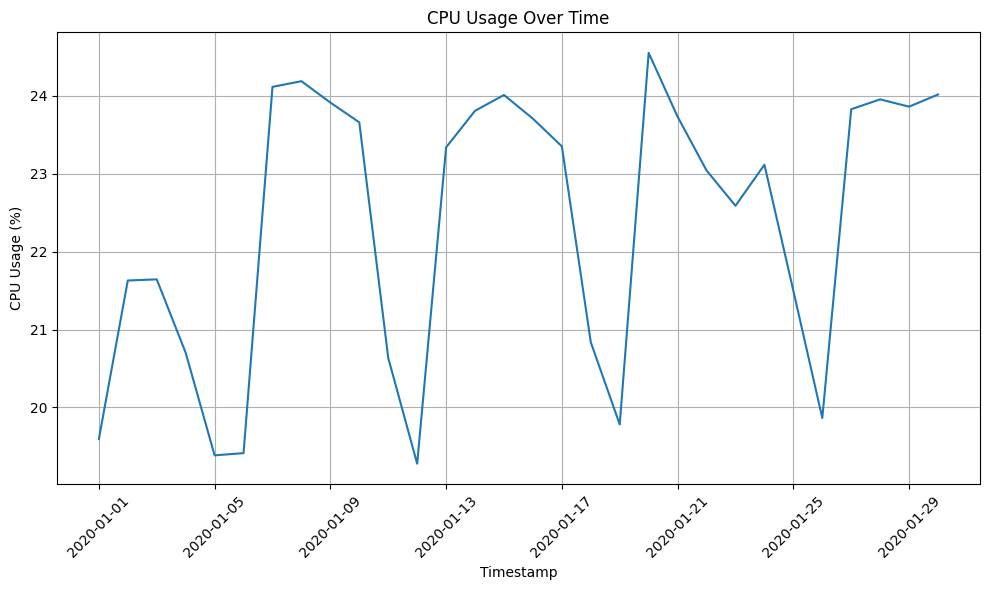

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

df = pd.DataFrame(data)

# Step 1: Convert the 'date' column to datetime format
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Calculate the average CPU usage for each day of the week (0 = Monday, 6 = Sunday)
avg_cpu_usage_per_day = df.groupby('day_of_week')['cpu_usage'].mean()

# Step 4: Define expected behavior (Monday high, Sunday low)
# We can calculate the deviation from the expected pattern.
anomalies = []

# Threshold for detecting anomalies (e.g., 10% deviation from the average)
threshold_low = 0.9  # 10% below average
threshold_high = 1.1  # 10% above average

for index, row in df.iterrows():
    expected_usage = avg_cpu_usage_per_day[row['day_of_week']]
    actual_usage = row['cpu_usage']

    # Check for anomalies (e.g., if Monday has unusually low usage, or Friday has unusually high usage)
    if (row['day_of_week'] == 0 and actual_usage < expected_usage * threshold_low) or \
       (row['day_of_week'] == 6 and actual_usage > expected_usage * threshold_high):
        anomalies.append((row['timestamp'], actual_usage, expected_usage, 'Anomaly'))

# Step 5: Print anomalies
anomalies_df = pd.DataFrame(anomalies, columns=['Timestamp', 'Actual Usage', 'Expected Usage', 'Anomaly Type'])
print(anomalies_df)

# Plotting if required:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_usage'], label='CPU Usage')
plt.title('CPU Usage Over Time')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


         date  cpu_usage  anomaly
0  2020-01-01  19.594510  Anomaly
1  2020-01-02  21.629076  Anomaly
2  2020-01-03  21.643827  Anomaly
5  2020-01-06  19.414415  Anomaly


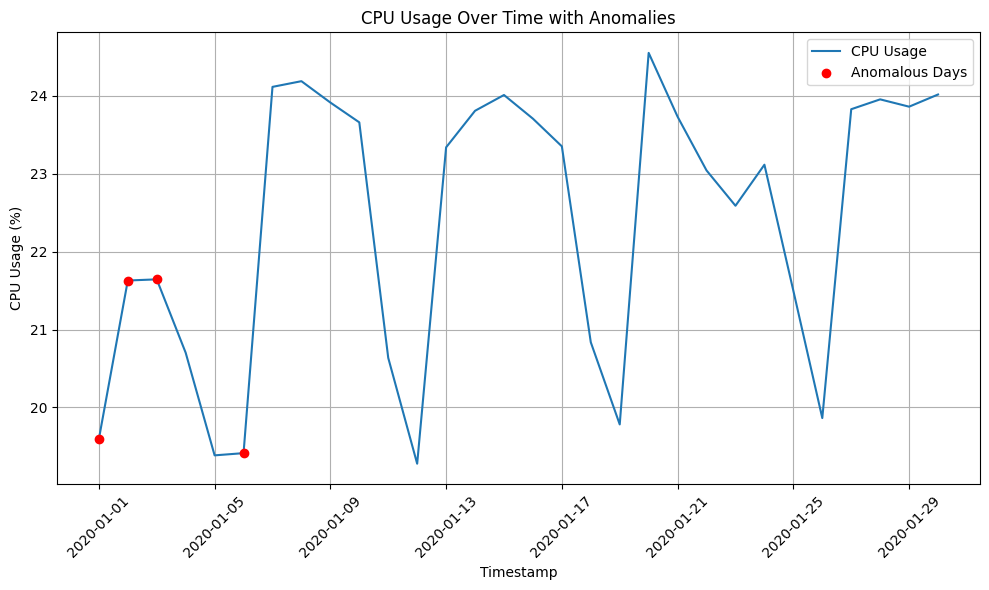

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

df = pd.DataFrame(data)

# Step 1: Convert the 'date' column to datetime format
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Define the anomalous dates based on your observation
anomalous_dates = ["2020-01-01", "2020-01-02", "2020-01-03", "2020-01-06"]

# Step 3: Identify anomalies by checking if the date is in the anomalous dates list
df['anomaly'] = df['date'].apply(lambda x: "Anomaly" if x in anomalous_dates else "Normal")

# Step 4: Print the anomalies
anomalies_df = df[df['anomaly'] == "Anomaly"]
print(anomalies_df[['date', 'cpu_usage', 'anomaly']])

# Plotting if required:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_usage'], label='CPU Usage')
plt.scatter(df[df['anomaly'] == 'Anomaly']['timestamp'],
            df[df['anomaly'] == 'Anomaly']['cpu_usage'], color='red', label='Anomalous Days', zorder=5)
plt.title('CPU Usage Over Time with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Empty DataFrame
Columns: [date, cpu_usage, day_of_week, anomaly]
Index: []


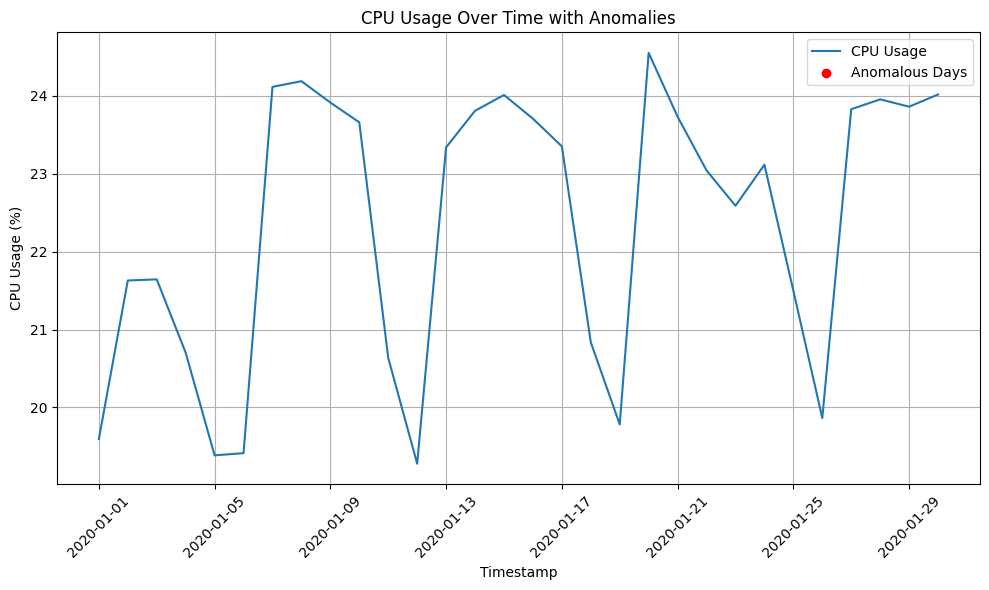

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

df = pd.DataFrame(data)

# Step 1: Convert the 'date' column to datetime format
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Calculate the rolling mean and standard deviation for CPU usage by day of the week
# Group by day_of_week and calculate rolling statistics
df['rolling_mean'] = df.groupby('day_of_week')['cpu_usage'].transform(lambda x: x.rolling(3, center=True).mean())
df['rolling_std'] = df.groupby('day_of_week')['cpu_usage'].transform(lambda x: x.rolling(3, center=True).std())

# Step 4: Identify anomalies where the CPU usage deviates significantly from the rolling mean
df['anomaly'] = np.where(
    (df['cpu_usage'] > df['rolling_mean'] + 2 * df['rolling_std']) |
    (df['cpu_usage'] < df['rolling_mean'] - 2 * df['rolling_std']),
    'Anomaly', 'Normal'
)

# Step 5: Print the anomalies
anomalies_df = df[df['anomaly'] == "Anomaly"]
print(anomalies_df[['date', 'cpu_usage', 'day_of_week', 'anomaly']])

# Plotting if required:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_usage'], label='CPU Usage')
plt.scatter(df[df['anomaly'] == 'Anomaly']['timestamp'],
            df[df['anomaly'] == 'Anomaly']['cpu_usage'], color='red', label='Anomalous Days', zorder=5)
plt.title('CPU Usage Over Time with Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

df = pd.DataFrame(data)

# Step 1: Convert the 'date' column to datetime format
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Calculate the average CPU usage for each day of the week (Monday = 0, Sunday = 6)
avg_values_by_day = df.groupby('day_of_week')['cpu_usage'].mean()

# Step 4: Calculate the least (minimum) CPU usage for each day of the week
least_values_by_day = df.groupby('day_of_week')['cpu_usage'].min()

# Step 5: Add the average and least CPU usage value for the corresponding day of the week to the original DataFrame
df['avg_cpu_usage'] = df['day_of_week'].map(avg_values_by_day)
df['least_cpu_usage'] = df['day_of_week'].map(least_values_by_day)

# Step 6: Print the calculated average and least CPU usage for each day of the week
print("Average CPU usage for each day of the week (Monday = 0, Sunday = 6):")
print(avg_values_by_day)

print("\nLeast (minimum) CPU usage for each day of the week (Monday = 0, Sunday = 6):")
print(least_values_by_day)

# Step 7: Print the DataFrame with avg_cpu_usage and least_cpu_usage added
print("\nData with average and least CPU usage:")
print(df)


Average CPU usage for each day of the week (Monday = 0, Sunday = 6):
day_of_week
0    22.781949
1    23.900657
2    22.937971
3    23.169982
4    22.941651
5    20.918377
6    19.578017
Name: cpu_usage, dtype: float64

Least (minimum) CPU usage for each day of the week (Monday = 0, Sunday = 6):
day_of_week
0    19.414415
1    23.730073
2    19.594510
3    21.629076
4    21.643827
5    20.636760
6    19.278814
Name: cpu_usage, dtype: float64

Data with average and least CPU usage:
          date  cpu_usage  timestamp  day_of_week  avg_cpu_usage  \
0   2020-01-01  19.594510 2020-01-01            2      22.937971   
1   2020-01-02  21.629076 2020-01-02            3      23.169982   
2   2020-01-03  21.643827 2020-01-03            4      22.941651   
3   2020-01-04  20.702700 2020-01-04            5      20.918377   
4   2020-01-05  19.385986 2020-01-05            6      19.578017   
5   2020-01-06  19.414415 2020-01-06            0      22.781949   
6   2020-01-07  24.113161 2020-01-07   

In [ ]:
import pandas as pd

# Data from your dataset with CPU usage and dates
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Calculate the average CPU usage for the entire month
avg_cpu_usage = df['cpu_usage'].mean()

# Define the threshold percentage for anomaly detection (10% deviation)
threshold_upper = avg_cpu_usage * 1.10  # 10% higher than average
threshold_lower = avg_cpu_usage * 0.90  # 10% lower than average

# Find the days that are above or below the threshold
anomalous_days = df[(df['cpu_usage'] > threshold_upper) | (df['cpu_usage'] < threshold_lower)]

# Display the anomalous days
print(f"Average CPU usage for the month: {avg_cpu_usage:.2f}%\n")
print(f"Days with CPU usage more than 10% higher or lower than the average:")
print(anomalous_days[['date', 'cpu_usage']])


Average CPU usage for the month: 22.37%

Days with CPU usage more than 10% higher or lower than the average:
         date  cpu_usage
0  2020-01-01  19.594510
4  2020-01-05  19.385986
5  2020-01-06  19.414415
11 2020-01-12  19.278814
18 2020-01-19  19.782607
25 2020-01-26  19.864659


   Timestamp  Actual Usage  Expected Usage Anomaly Type
0 2020-01-06     19.414415       22.781949      Anomaly


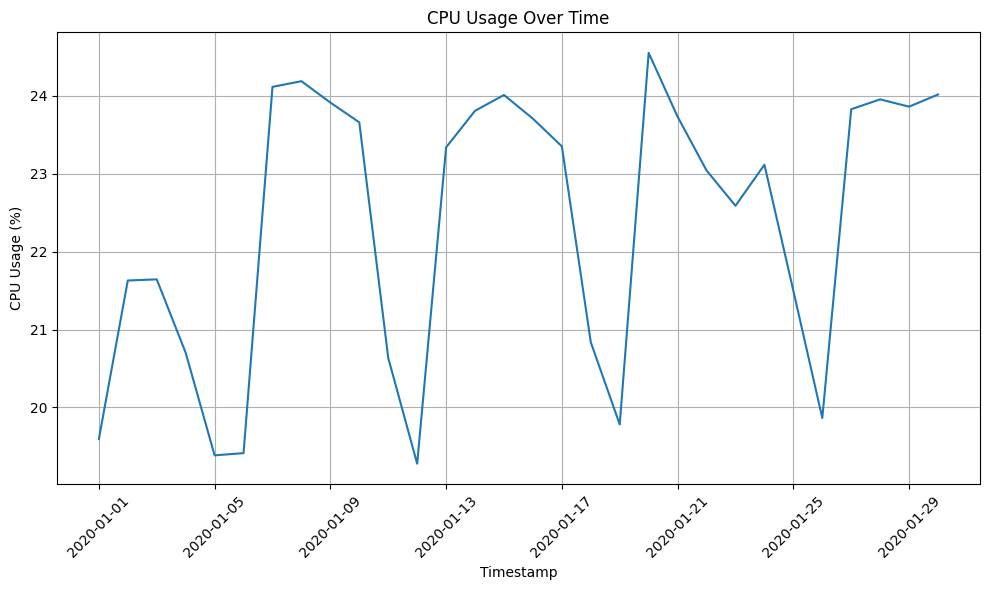

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual DataFrame)
data = {
    "date": [
        "2020-01-01", "2020-01-02", "2020-01-03", "2020-01-04", "2020-01-05",
        "2020-01-06", "2020-01-07", "2020-01-08", "2020-01-09", "2020-01-10",
        "2020-01-11", "2020-01-12", "2020-01-13", "2020-01-14", "2020-01-15",
        "2020-01-16", "2020-01-17", "2020-01-18", "2020-01-19", "2020-01-20",
        "2020-01-21", "2020-01-22", "2020-01-23", "2020-01-24", "2020-01-25",
        "2020-01-26", "2020-01-27", "2020-01-28", "2020-01-29", "2020-01-30"
    ],
    "cpu_usage": [
        19.594510, 21.629076, 21.643827, 20.702700, 19.385986,
        19.414415, 24.113161, 24.186179, 23.912184, 23.657913,
        20.636760, 19.278814, 23.337485, 23.806436, 24.008966,
        23.705240, 23.350212, 20.836644, 19.782607, 24.549329,
        23.730073, 23.041104, 22.588129, 23.114651, 21.497403,
        19.864659, 23.826566, 23.952956, 23.859097, 24.015280
    ]
}
df = pd.DataFrame(data)

# Step 1: Convert the 'date' column to datetime format
df['timestamp'] = pd.to_datetime(df['date'])

# Step 2: Extract the day of the week (Monday = 0, Sunday = 6)
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Step 3: Calculate the average CPU usage for each day of the week (0 = Monday, 6 = Sunday)
avg_cpu_usage_per_day = df.groupby('day_of_week')['cpu_usage'].mean()

# Step 4: Define expected behavior (Monday high, Sunday low)
# We can calculate the deviation from the expected pattern.
anomalies = []

for index, row in df.iterrows():
    expected_usage = avg_cpu_usage_per_day[row['day_of_week']]
    actual_usage = row['cpu_usage']

    # Check for anomalies (e.g., if Sunday has unusually high usage, or Monday has unusually low usage)
    if (row['day_of_week'] == 0 and actual_usage < expected_usage * 0.9) or (row['day_of_week'] == 6 and actual_usage > expected_usage * 1.1):
        anomalies.append((row['timestamp'], actual_usage, expected_usage, 'Anomaly'))

# Step 5: Print anomalies
anomalies_df = pd.DataFrame(anomalies, columns=['Timestamp', 'Actual Usage', 'Expected Usage', 'Anomaly Type'])
print(anomalies_df)

# Plotting if required:
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_usage'], label='CPU Usage')
plt.title('CPU Usage Over Time')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is the dataframe you are working with, and you already have it loaded.
# I'll proceed with the following steps:

df = pd.read_csv('/content/nfvData.csv')
# 1. Make sure that the 'timestamp' column is parsed correctly as datetime.
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m-%d-%Y %H:%M')

# 2. Set the timestamp as the index
df.set_index('timestamp', inplace=True)

# 3. Resample the data to hourly mean values
hourly_cpu_usage = df['cpu|demandPct'].resample('H').mean()

# 4. Group by day and plot the data for the first 30 days
days_to_plot = hourly_cpu_usage.groupby(hourly_cpu_usage.index.date).head(24)

# 5. Create a plot with thinner, professional lines
plt.figure(figsize=(15, 8))

# Plot each day's data with a thin line style
for date in days_to_plot.index.date.unique():
    daily_data = hourly_cpu_usage[hourly_cpu_usage.index.date == date]
    plt.plot(daily_data.index.hour, daily_data.values, label=str(date), alpha=0.7, linewidth=1)

# 6. Add labels and title for clarity
plt.title('Comparative Hourly CPU Usage for the First 30 Days', fontsize=16, fontweight='bold')
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average CPU Usage (%)', fontsize=12)

# 7. Improve the layout and display the legend without overcrowding
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)

# 8. Show the plot
plt.tight_layout()
plt.show()


ValueError: time data "13-01-2020 00:04" doesn't match format "%m-%d-%Y %H:%M", at position 3456. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

<ipython-input-11-1aa4e9ac53c2>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-11-1aa4e9ac53c2>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-11-1aa4e9ac53c2>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-11-1aa4e9ac53c2>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-11-1aa4e9ac53c2>:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e.

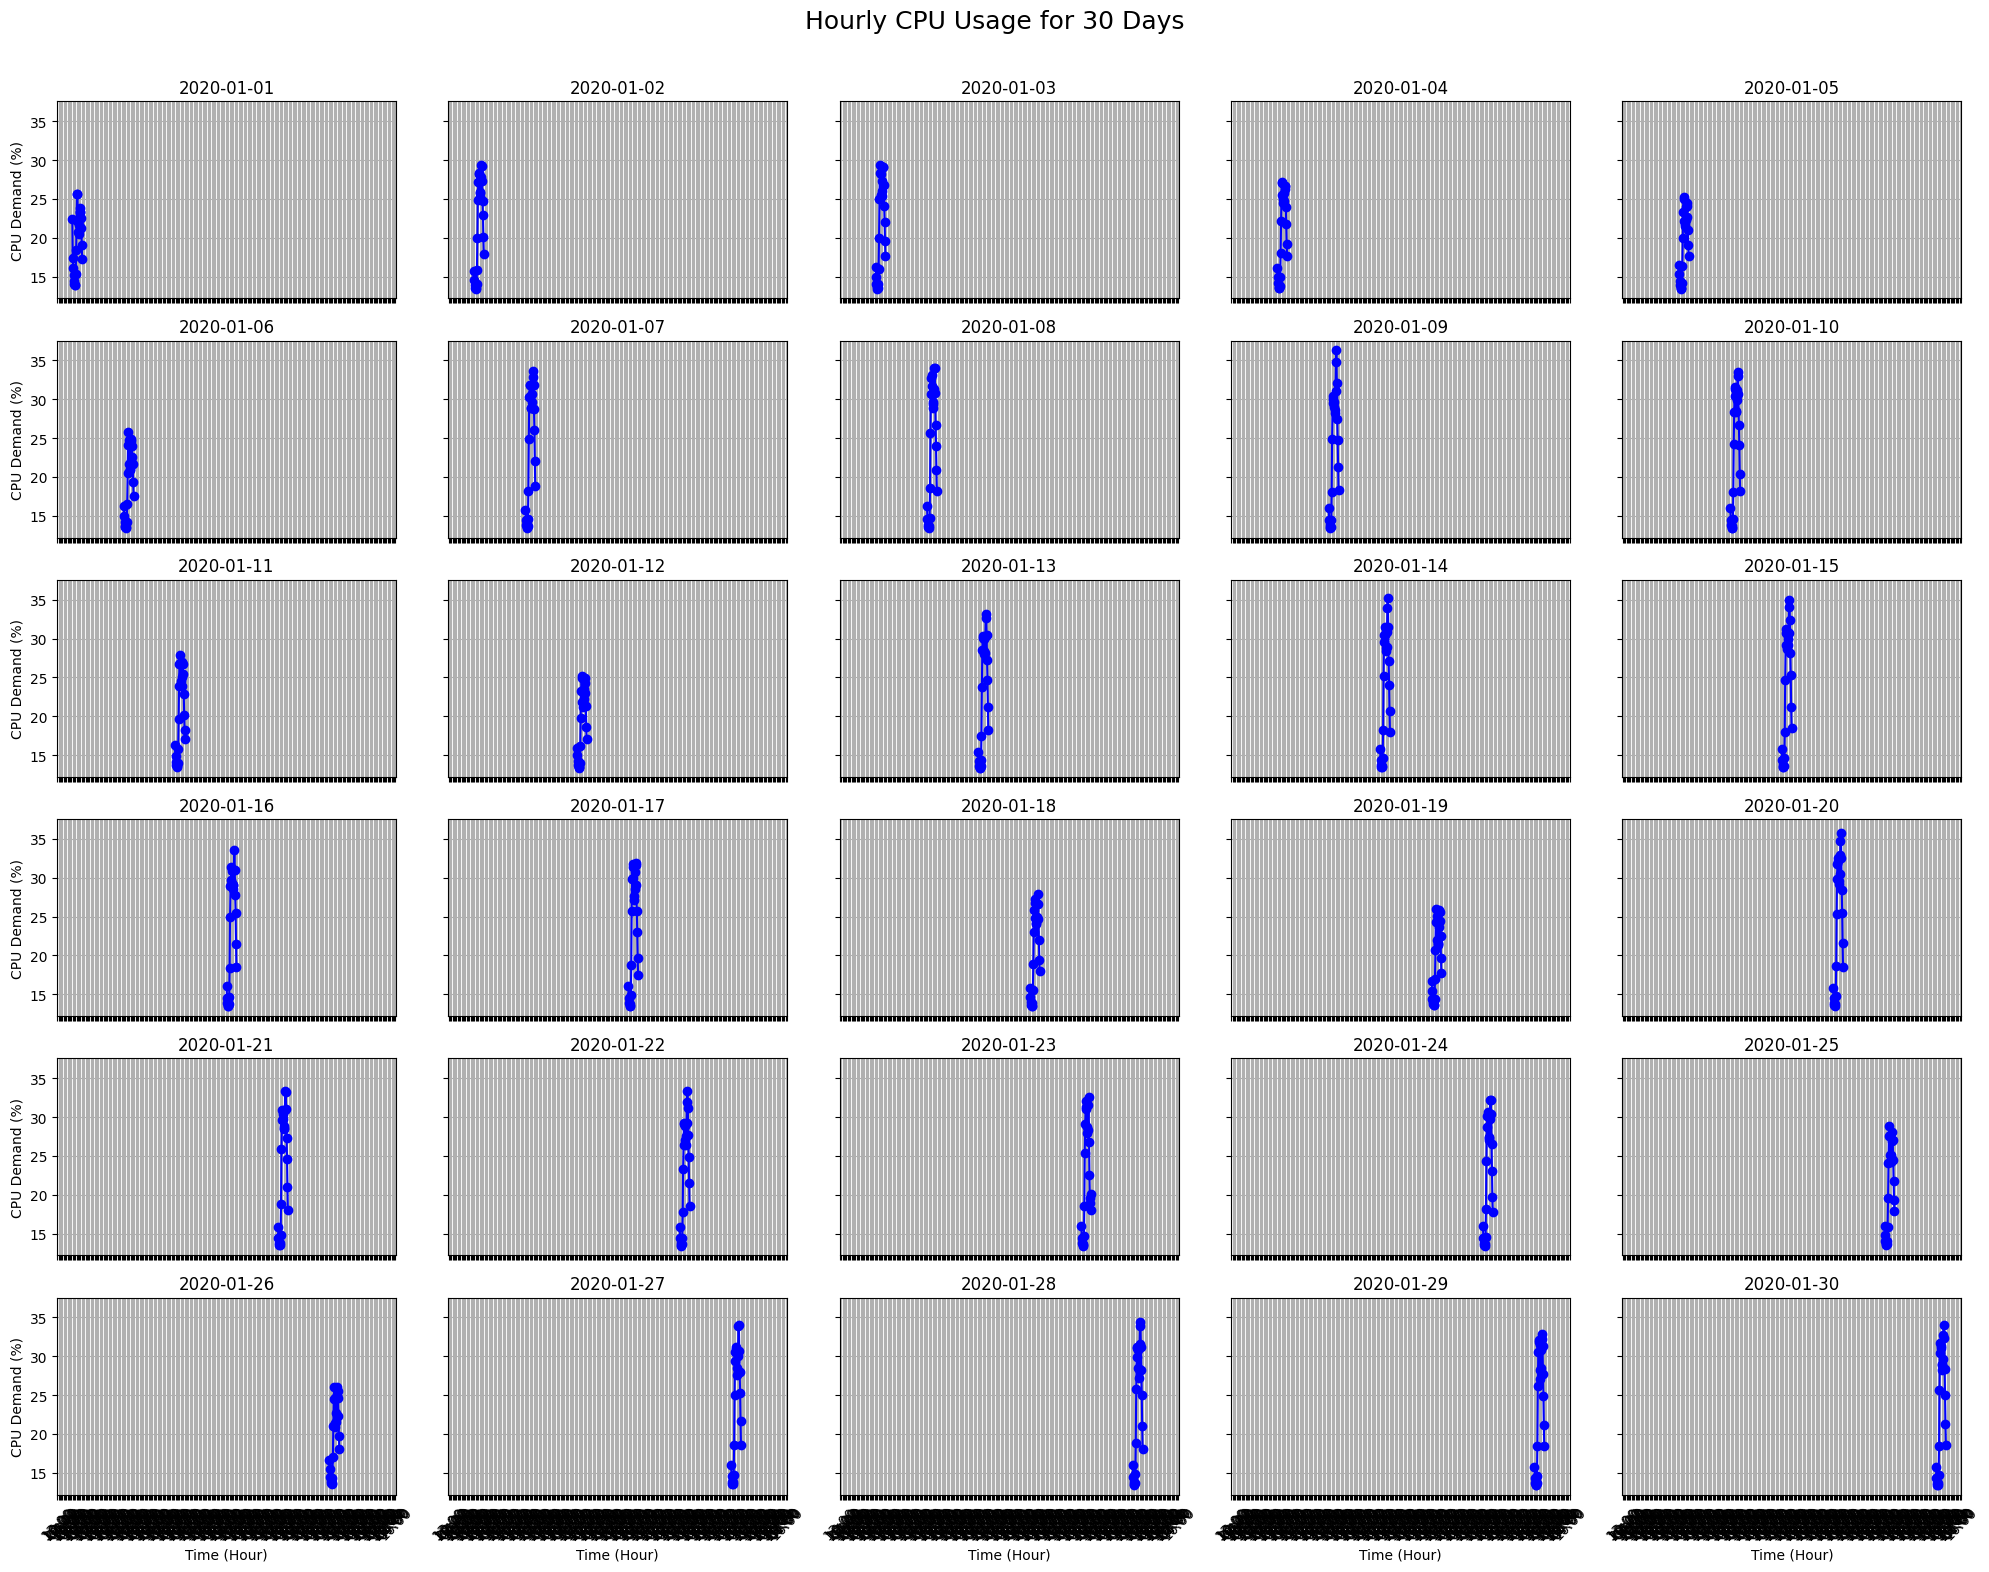

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
df = pd.read_csv('/content/nfvData.csv')

# Ensure the 'cpu|demandPct' column is numeric (handling non-numeric values)
df['cpu|demandPct'] = pd.to_numeric(df['cpu|demandPct'], errors='coerce')

# Convert the 'timestamp' column to datetime with the correct format
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')

# Drop any rows with invalid or missing timestamps
df = df.dropna(subset=['timestamp'])

# Set 'timestamp' as the index
df.set_index('timestamp', inplace=True)

# Resample the data to calculate the average CPU demand per hour
hourly_cpu_usage = df['cpu|demandPct'].resample('h').mean()

# Create a new column for the day
hourly_cpu_usage = hourly_cpu_usage.reset_index()
hourly_cpu_usage['day'] = hourly_cpu_usage['timestamp'].dt.date

# Create subplots for 30 days
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 16), sharex=True, sharey=True)
fig.suptitle('Hourly CPU Usage for 30 Days', fontsize=18)

# Plot each day's data on a separate subplot
for i, (day, group) in enumerate(hourly_cpu_usage.groupby('day')):
    ax = axes[i // 5, i % 5]  # Arrange plots in a 6x5 grid
    ax.plot(group['timestamp'], group['cpu|demandPct'], marker='o', linestyle='-', color='blue')
    ax.set_title(str(day))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Show tick labels every 3 hours
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(True)

    # Set labels only for the bottom and left plots
    if i // 5 == 5:  # Bottom row
        ax.set_xlabel('Time (Hour)')
    if i % 5 == 0:  # Leftmost column
        ax.set_ylabel('CPU Demand (%)')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the main title
plt.show()


In [ ]:
prin

<ipython-input-9-49ac51d4a111>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["resName_encoded"] = encoder.fit_transform(one_day_data["resName"])
<ipython-input-9-49ac51d4a111>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["cpu|demandPct_scaled"] = scaler.fit_transform(one_day_data[["cpu|demandPct"]])
<ipython-input-9-49ac51d4a111>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

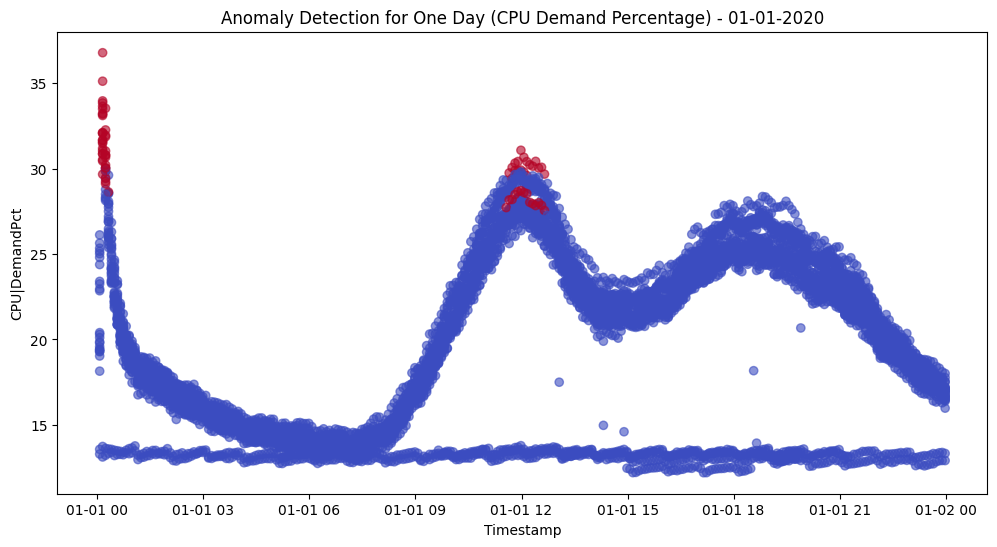

Number of anomalies: 72
Number of normal points: 7128
Anomaly detection results saved to 'one_day_anomaly_results.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

try:
    # Load dataset (corrected path and year)
    file_path = "/nfvData (1).csv"  # Corrected path
    data = pd.read_csv(file_path)

    # Handle missing values
    if "cpu|demandPct" not in data.columns or "resName" not in data.columns:
        raise ValueError("Required columns 'cpu|demandPct' or 'resName' are missing.")

    data = data.dropna(subset=["cpu|demandPct"])

    # Convert timestamp to datetime (year 2020 corrected)
    data["timestamp"] = pd.to_datetime(data["timestamp"], format="%d-%m-%Y %H:%M", errors="coerce")
    if data["timestamp"].isna().all():
        raise ValueError("All timestamp values could not be parsed.")

    # Filter data for one day (e.g., "01-01-2020")
    one_day_data = data[data["timestamp"].dt.date == pd.to_datetime("01-01-2020").date()]
    if one_day_data.empty:
        raise ValueError("No data found for the specified date (01-01-2020).")

    # Preprocess data
    encoder = LabelEncoder()
    one_day_data["resName_encoded"] = encoder.fit_transform(one_day_data["resName"])

    scaler = StandardScaler()
    one_day_data["cpu|demandPct_scaled"] = scaler.fit_transform(one_day_data[["cpu|demandPct"]])

    # Features for anomaly detection
    features = one_day_data[["resName_encoded", "cpu|demandPct_scaled"]]

    # Anomaly detection using Isolation Forest
    model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    one_day_data["anomaly"] = model.fit_predict(features)

    # Map anomalies: -1 (anomaly) -> 1, 1 (normal) -> 0
    one_day_data["anomaly"] = one_day_data["anomaly"].apply(lambda x: 1 if x == -1 else 0)

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.scatter(
        one_day_data["timestamp"],
        one_day_data["cpu|demandPct"],
        c=one_day_data["anomaly"],
        cmap="coolwarm",
        alpha=0.6,
    )
    plt.title("Anomaly Detection for One Day (CPU Demand Percentage) - 01-01-2020")
    plt.xlabel("Timestamp")
    plt.ylabel("CPU|DemandPct")
    plt.show()

    # Count anomalies and normal points
    anomaly_count = one_day_data["anomaly"].sum()  # Count anomalies (1)
    normal_count = len(one_day_data) - anomaly_count  # Count normal points (0)

    print(f"Number of anomalies: {anomaly_count}")
    print(f"Number of normal points: {normal_count}")

    # Save the filtered and processed data with anomalies
    one_day_data.to_csv("one_day_anomaly_results.csv", index=False)
    print("Anomaly detection results saved to 'one_day_anomaly_results.csv'.")

except Exception as e:
    print(f"Error: {e}")


<ipython-input-10-63c5692ba9b4>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["ema_cpu_demand"] = one_day_data["cpu|demandPct"].ewm(span=50, adjust=False).mean()
<ipython-input-10-63c5692ba9b4>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_day_data["deviation"] = np.abs(one_day_data["cpu|demandPct"] - one_day_data["ema_cpu_demand"])
<ipython-input-10-63c5692ba9b4>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

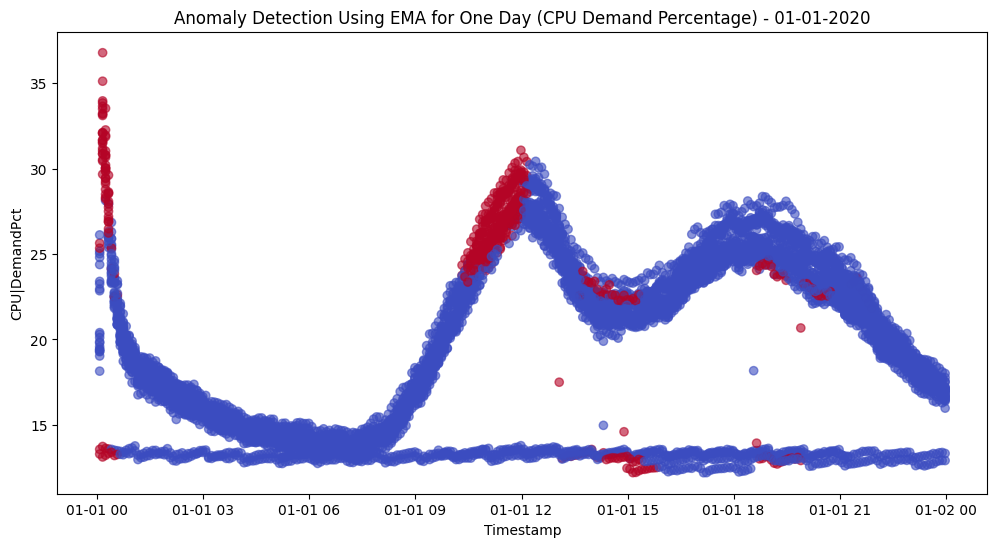

Number of anomalies detected using EMA: 543
Number of normal points using EMA: 6657
Anomaly detection results using EMA saved to 'one_day_anomaly_results_ema.csv'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    # Load dataset (corrected path and year)
    file_path = "/nfvData (1).csv"  # Corrected path
    data = pd.read_csv(file_path)

    # Handle missing values
    if "cpu|demandPct" not in data.columns or "resName" not in data.columns:
        raise ValueError("Required columns 'cpu|demandPct' or 'resName' are missing.")

    data = data.dropna(subset=["cpu|demandPct"])

    # Convert timestamp to datetime (year 2020 corrected)
    data["timestamp"] = pd.to_datetime(data["timestamp"], format="%d-%m-%Y %H:%M", errors="coerce")
    if data["timestamp"].isna().all():
        raise ValueError("All timestamp values could not be parsed.")

    # Filter data for one day (e.g., "01-01-2020")
    one_day_data = data[data["timestamp"].dt.date == pd.to_datetime("01-01-2020").date()]
    if one_day_data.empty:
        raise ValueError("No data found for the specified date (01-01-2020).")

    # Preprocess data
    # Calculate Exponential Moving Average (EMA)
    one_day_data["ema_cpu_demand"] = one_day_data["cpu|demandPct"].ewm(span=50, adjust=False).mean()

    # Calculate deviation from EMA
    one_day_data["deviation"] = np.abs(one_day_data["cpu|demandPct"] - one_day_data["ema_cpu_demand"])

    # Calculate standard deviation of the deviation to set a threshold
    threshold = one_day_data["deviation"].std() * 3  # 3 standard deviations as an example threshold

    # Flag anomalies if deviation exceeds the threshold
    one_day_data["anomaly_ema"] = one_day_data["deviation"].apply(lambda x: 1 if x > threshold else 0)

    # Count anomalies and normal points
    anomaly_count_ema = one_day_data["anomaly_ema"].sum()  # Count anomalies (1)
    normal_count_ema = len(one_day_data) - anomaly_count_ema  # Count normal points (0)

    # Visualize anomalies
    plt.figure(figsize=(12, 6))
    plt.scatter(
        one_day_data["timestamp"],
        one_day_data["cpu|demandPct"],
        c=one_day_data["anomaly_ema"],
        cmap="coolwarm",
        alpha=0.6,
    )
    plt.title("Anomaly Detection Using EMA for One Day (CPU Demand Percentage) - 01-01-2020")
    plt.xlabel("Timestamp")
    plt.ylabel("CPU|DemandPct")
    plt.show()

    print(f"Number of anomalies detected using EMA: {anomaly_count_ema}")
    print(f"Number of normal points using EMA: {normal_count_ema}")

    # Save the filtered and processed data with anomalies
    one_day_data.to_csv("one_day_anomaly_results_ema.csv", index=False)
    print("Anomaly detection results using EMA saved to 'one_day_anomaly_results_ema.csv'.")

except Exception as e:
    print(f"Error: {e}")


Number of anomalies detected using Median Model: 539
Number of normal points using Median Model: 6661


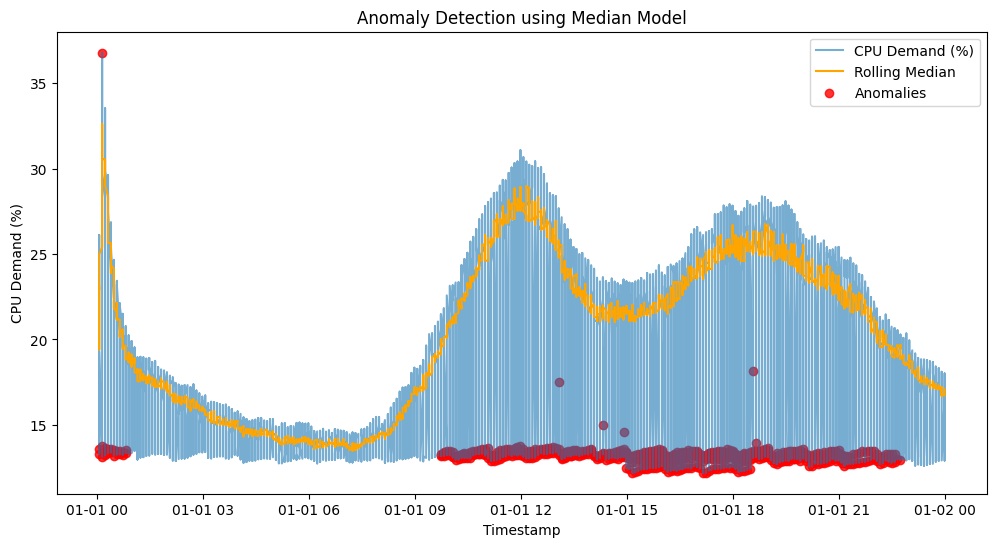

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_path = "/nfvData (1).csv"
data = pd.read_csv(file_path)

# Handle missing values
data = data.dropna(subset=["cpu|demandPct"])

# Convert timestamp to datetime (adjust format as per the dataset)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%d-%m-%Y %H:%M")

# Filter data for one day (e.g., "01-01-2020")
one_day_data = data[data["timestamp"].dt.date == pd.to_datetime("01-01-2020").date()]

# Sort data by timestamp (if not already sorted)
one_day_data = one_day_data.sort_values(by="timestamp")

# Median predictive model
# Set the rolling window size (adjust based on your data granularity, e.g., 12 for an hourly window if data is every 5 minutes)
window_size = 12

# Compute the rolling median
one_day_data["rolling_median"] = one_day_data["cpu|demandPct"].rolling(window=window_size, center=True).median()

# Calculate residuals (difference from rolling median)
one_day_data["residual"] = one_day_data["cpu|demandPct"] - one_day_data["rolling_median"]

# Define anomaly threshold (adjust based on your data; 2 standard deviations is a common choice)
threshold = 2 * one_day_data["residual"].std()

# Identify anomalies
one_day_data["anomaly"] = one_day_data["residual"].apply(lambda x: 1 if abs(x) > threshold else 0)

# Count anomalies and normal points
anomalies_count = one_day_data["anomaly"].sum()
normal_count = len(one_day_data) - anomalies_count

print(f"Number of anomalies detected using Median Model: {anomalies_count}")
print(f"Number of normal points using Median Model: {normal_count}")

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(one_day_data["timestamp"], one_day_data["cpu|demandPct"], label="CPU Demand (%)", alpha=0.6)
plt.plot(one_day_data["timestamp"], one_day_data["rolling_median"], label="Rolling Median", color="orange")
plt.scatter(one_day_data["timestamp"][one_day_data["anomaly"] == 1],
            one_day_data["cpu|demandPct"][one_day_data["anomaly"] == 1],
            color="red", label="Anomalies", alpha=0.8)
plt.title("Anomaly Detection using Median Model")
plt.xlabel("Timestamp")
plt.ylabel("CPU Demand (%)")
plt.legend()
plt.show()

# Save the results
one_day_data.to_csv("one_day_anomaly_results_median.csv", index=False)


In [ ]:
print(f"Original dataset size: {len(data)}")


Original dataset size: 215546


In [ ]:
print(f"Rows after filtering for 01-01-2020: {len(one_day_data)}")


Rows after filtering for 01-01-2020: 288


In [ ]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition on the 'cpu|demandPct' column
stl = STL(first_week['cpu|demandPct'], seasonal=24)  # Using a 7-day window for seasonal component
result = stl.fit()

# Extract the trend, seasonal, and residual components
first_week['trend'] = result.trend
first_week['seasonal'] = result.seasonal
first_week['residual'] = result.resid

# Plot the decomposed components for visualization
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(first_week.index, first_week['cpu|demandPct'], label='Original Data', color='blue')
plt.title('Original CPU Demand')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(first_week.index, first_week['trend'], label='Trend', color='green')
plt.title('Trend Component')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(first_week.index, first_week['seasonal'], label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.legend()

plt.tight_layout()
plt.show()


ValueError: Unable to determine period from endog

Missing values per column:
timestamp          0
resName            0
cpu|demandPct    427
dtype: int64

Data types:
timestamp         object
resName           object
cpu|demandPct    float64
dtype: object

Non-numeric columns:
Index(['timestamp', 'resName'], dtype='object')

Summary statistics:
       cpu|demandPct
count  215546.000000
mean       22.368597
std         7.721716
min        11.988000
25%        14.252000
50%        21.893333
75%        29.470667
max        42.721333

Skewness for each column:
cpu|demandPct: 0.25


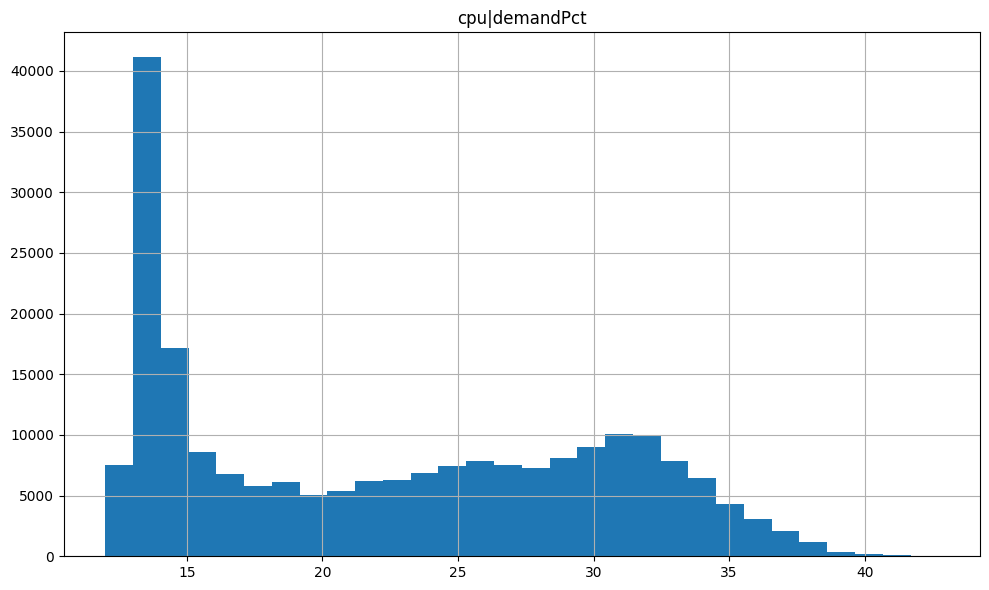

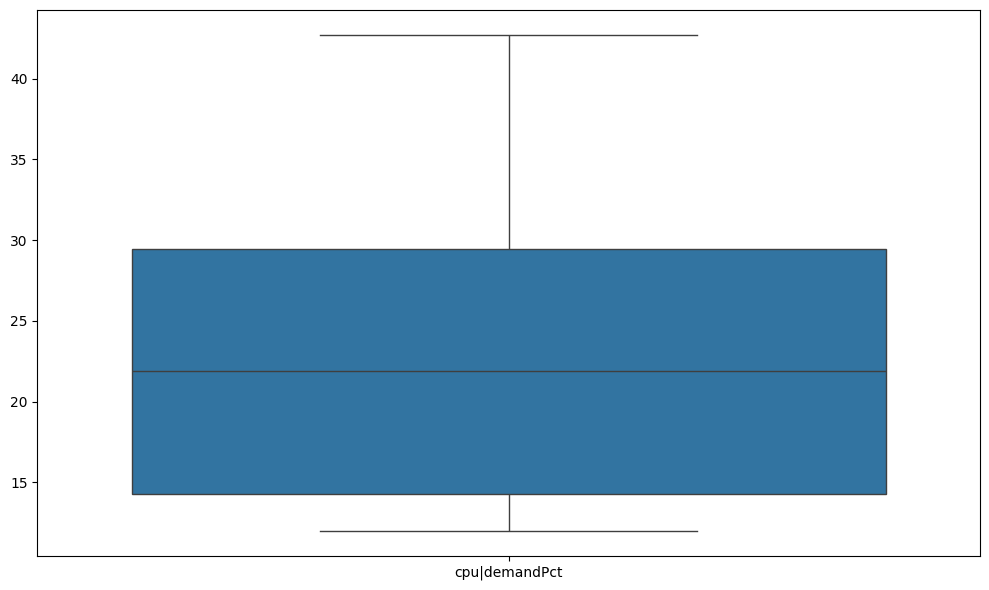


Range of values for each column:
cpu|demandPct: Min = 11.98799992, Max = 42.72133255

Number of duplicate rows: 0

Number of outliers based on Z-score method:
cpu|demandPct: 0 outliers


<ipython-input-19-02cb0272f757>:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{column}: {outliers[i]} outliers")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Load your dataset
# Assuming your dataset is in a CSV file, replace 'your_data.csv' with your actual file name
df = pd.read_csv('/content/nfvData.csv')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values (optional, if needed)
# df = df.dropna()

# Check data types to ensure all are numeric
print("\nData types:")
print(df.dtypes)

# Check for non-numeric columns (if any)
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns:")
print(non_numeric_columns)

# Basic summary statistics (mean, median, min, max, etc.)
print("\nSummary statistics:")
print(df.describe())

# Check for skewness in the data (positive or negative skewness)
print("\nSkewness for each column:")
for column in df.select_dtypes(include=[np.number]).columns:
    print(f"{column}: {skew(df[column].dropna()):.2f}")

# Plot histograms for each numeric column to visualize distribution
df.select_dtypes(include=[np.number]).hist(bins=30, figsize=(10, 6))
plt.tight_layout()
plt.show()

# Box plots for each numeric column to check for outliers visually
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.tight_layout()
plt.show()

# Checking for the range of values in each numeric column
print("\nRange of values for each column:")
for column in df.select_dtypes(include=[np.number]).columns:
    print(f"{column}: Min = {df[column].min()}, Max = {df[column].max()}")

# Optional: Check for the presence of duplicate data
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Optional: Check the percentage of outliers (using Z-score or a threshold of your choice)
from scipy.stats import zscore

# Compute z-scores and identify potential outliers (absolute Z > 3 is considered an outlier)
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)
print("\nNumber of outliers based on Z-score method:")
for i, column in enumerate(df.select_dtypes(include=[np.number]).columns):
    print(f"{column}: {outliers[i]} outliers")



<ipython-input-26-8ec4d88d27a7>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'manual_label'] = 0
<ipython-input-26-8ec4d88d27a7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
<ipython-input-26-8ec4d88d27a7>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

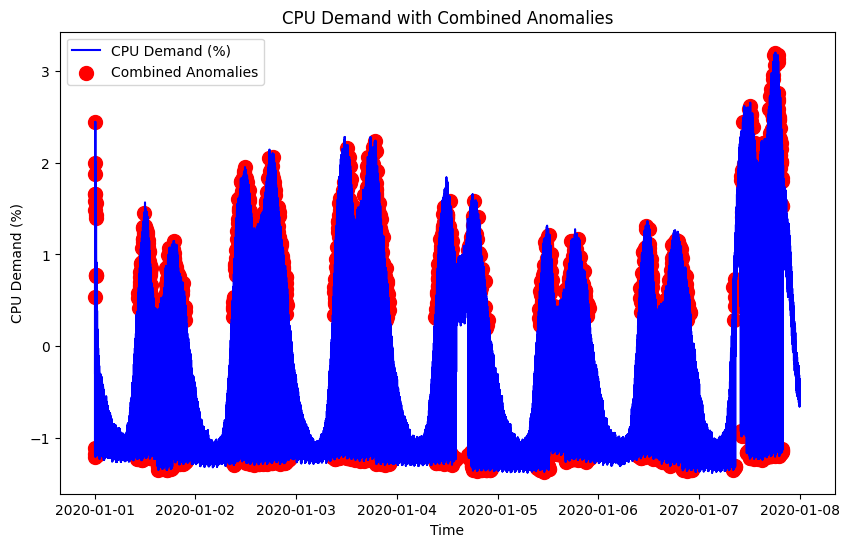

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
df = pd.read_csv('/nfvData (1).csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Define the start and end date for filtering (one week)
start_date = pd.to_datetime('2020-01-01 00:00')
end_date = pd.to_datetime('2020-01-07 23:59')

# Filter the data for the first week
first_week = df.loc[start_date:end_date]

# 1. Manual Threshold-Based Anomaly Detection

# Calculate IQR for dynamic thresholds
Q1 = first_week['cpu|demandPct'].quantile(0.25)
Q3 = first_week['cpu|demandPct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add a 'manual_label' column for anomalies using .loc to avoid warnings
first_week.loc[:, 'manual_label'] = 0

# Update manual labels based on IQR thresholds
first_week.loc[first_week['cpu|demandPct'] > upper_bound, 'manual_label'] = 1  # Above upper threshold
first_week.loc[first_week['cpu|demandPct'] < lower_bound, 'manual_label'] = 1  # Below lower threshold

# Detect sudden jumps and mark as anomalies
first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
first_week.loc[first_week['diff'] > 10, 'manual_label'] = 1  # Sudden spike or drop greater than 10%

# Drop the 'diff' column as it's no longer needed
first_week.drop(columns=['diff'], inplace=True)

# 2. Enhanced EMA-Based Anomaly Detection

# Add time-based features using .loc
first_week.loc[:, 'hour'] = first_week.index.hour
first_week.loc[:, 'day_of_week'] = first_week.index.dayofweek

# Create lag features for CPU demand
first_week.loc[:, 'lag_1'] = first_week['cpu|demandPct'].shift(1)
first_week.loc[:, 'lag_2'] = first_week['cpu|demandPct'].shift(2)

# Add rolling mean and standard deviation
first_week.loc[:, 'rolling_mean'] = first_week['cpu|demandPct'].rolling(window=3).mean()
first_week.loc[:, 'rolling_std'] = first_week['cpu|demandPct'].rolling(window=3).std()

# Drop rows with NaN values created by rolling operations
first_week.dropna(inplace=True)

# Standardize features for better performance
scaler = StandardScaler()
features_to_scale = ['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']
first_week[features_to_scale] = scaler.fit_transform(first_week[features_to_scale])

# Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week.loc[:, 'ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# Define an anomaly if the absolute difference between EMA and actual value is large
first_week.loc[:, 'ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# Set dynamic threshold for EMA anomalies (mean + 2*std)
ema_anomaly_threshold = first_week['ema_diff'].mean() + 2 * first_week['ema_diff'].std()

# Update the anomalies based on the threshold using .loc
first_week.loc[:, 'ema_anomaly'] = np.where(first_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# Combine results from both methods
first_week.loc[:, 'combined_anomaly'] = first_week[['ema_anomaly', 'manual_label']].max(axis=1)

# 3. Model Training (RandomForest as Hybrid Model)

# Using the features for anomaly prediction
X = first_week[['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']]
y = first_week['combined_anomaly']

# Initialize and train RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Predict anomalies using the trained model
first_week.loc[:, 'rf_anomaly_pred'] = rf_model.predict(X)

# 4. Plot the results

plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the combined anomalies
combined_anomalies = first_week[first_week['combined_anomaly'] == 1]
plt.scatter(combined_anomalies.index, combined_anomalies['cpu|demandPct'], color='red', label='Combined Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Combined Anomalies')
plt.legend()

# Show the plot
plt.show()


<ipython-input-27-3618fa22605d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'manual_label'] = 0
<ipython-input-27-3618fa22605d>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'diff'] = second_week['cpu|demandPct'].diff().abs()
<ipython-input-27-3618fa22605d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

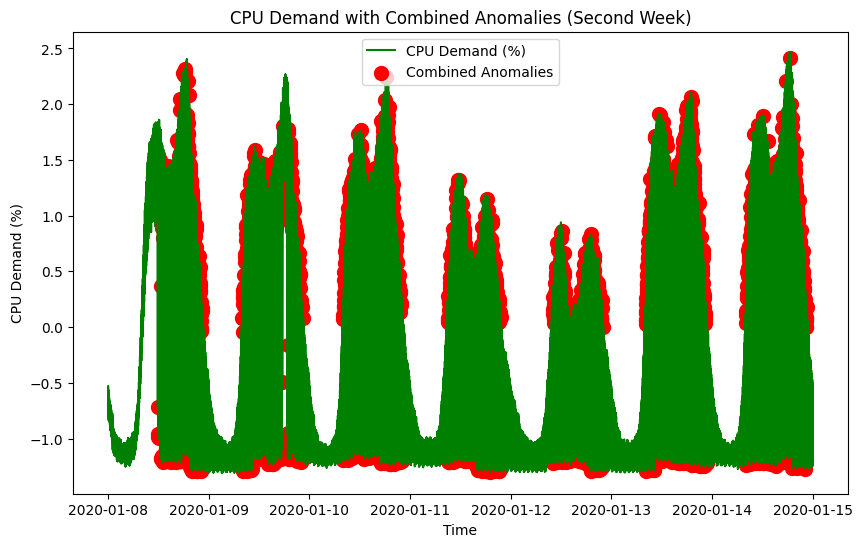

In [ ]:
# Filter the data for the second week (Jan 8th - Jan 14th)
start_date_second_week = pd.to_datetime('2020-01-08 00:00')
end_date_second_week = pd.to_datetime('2020-01-14 23:59')

# Filter the data for the second week
second_week = df.loc[start_date_second_week:end_date_second_week]

# 1. Manual Threshold-Based Anomaly Detection

# Calculate IQR for dynamic thresholds for second week
Q1 = second_week['cpu|demandPct'].quantile(0.25)
Q3 = second_week['cpu|demandPct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add a 'manual_label' column for anomalies
second_week.loc[:, 'manual_label'] = 0

# Update manual labels based on IQR thresholds
second_week.loc[second_week['cpu|demandPct'] > upper_bound, 'manual_label'] = 1  # Above upper threshold
second_week.loc[second_week['cpu|demandPct'] < lower_bound, 'manual_label'] = 1  # Below lower threshold

# Detect sudden jumps and mark as anomalies
second_week.loc[:, 'diff'] = second_week['cpu|demandPct'].diff().abs()
second_week.loc[second_week['diff'] > 10, 'manual_label'] = 1  # Sudden spike or drop greater than 10%

# Drop the 'diff' column as it's no longer needed
second_week.drop(columns=['diff'], inplace=True)

# 2. Enhanced EMA-Based Anomaly Detection

# Add time-based features using .loc for second week
second_week.loc[:, 'hour'] = second_week.index.hour
second_week.loc[:, 'day_of_week'] = second_week.index.dayofweek

# Create lag features for CPU demand
second_week.loc[:, 'lag_1'] = second_week['cpu|demandPct'].shift(1)
second_week.loc[:, 'lag_2'] = second_week['cpu|demandPct'].shift(2)

# Add rolling mean and standard deviation
second_week.loc[:, 'rolling_mean'] = second_week['cpu|demandPct'].rolling(window=3).mean()
second_week.loc[:, 'rolling_std'] = second_week['cpu|demandPct'].rolling(window=3).std()

# Drop rows with NaN values created by rolling operations
second_week.dropna(inplace=True)

# Standardize features for better performance
second_week[features_to_scale] = scaler.fit_transform(second_week[features_to_scale])

# Calculate the Exponential Moving Average (EMA)
second_week.loc[:, 'ema'] = second_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# Define an anomaly if the absolute difference between EMA and actual value is large
second_week.loc[:, 'ema_diff'] = abs(second_week['cpu|demandPct'] - second_week['ema'])

# Set dynamic threshold for EMA anomalies (mean + 2*std)
ema_anomaly_threshold = second_week['ema_diff'].mean() + 2 * second_week['ema_diff'].std()

# Update the anomalies based on the threshold
second_week.loc[:, 'ema_anomaly'] = np.where(second_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# Combine results from both methods
second_week.loc[:, 'combined_anomaly'] = second_week[['ema_anomaly', 'manual_label']].max(axis=1)

# 3. Model Training (RandomForest as Hybrid Model)

# Using the features for anomaly prediction
X_second_week = second_week[['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']]
y_second_week = second_week['combined_anomaly']

# Initialize and train RandomForest model
rf_model.fit(X_second_week, y_second_week)

# Predict anomalies using the trained model
second_week.loc[:, 'rf_anomaly_pred'] = rf_model.predict(X_second_week)

# 4. Plot the results for the second week

plt.figure(figsize=(10, 6))

# Plot the CPU demand over time for the second week
plt.plot(second_week.index, second_week['cpu|demandPct'], label='CPU Demand (%)', color='green', linewidth=1.5)

# Highlight the combined anomalies
combined_anomalies_second_week = second_week[second_week['combined_anomaly'] == 1]
plt.scatter(combined_anomalies_second_week.index, combined_anomalies_second_week['cpu|demandPct'], color='red', label='Combined Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Combined Anomalies (Second Week)')
plt.legend()

# Show the plot
plt.show()


<ipython-input-38-6d84a8177fc9>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['rolling_mean'] = first_week['cpu|demandPct'].rolling(window=3).mean()
<ipython-input-38-6d84a8177fc9>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.dropna(inplace=True)
<ipython-input-38-6d84a8177fc9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

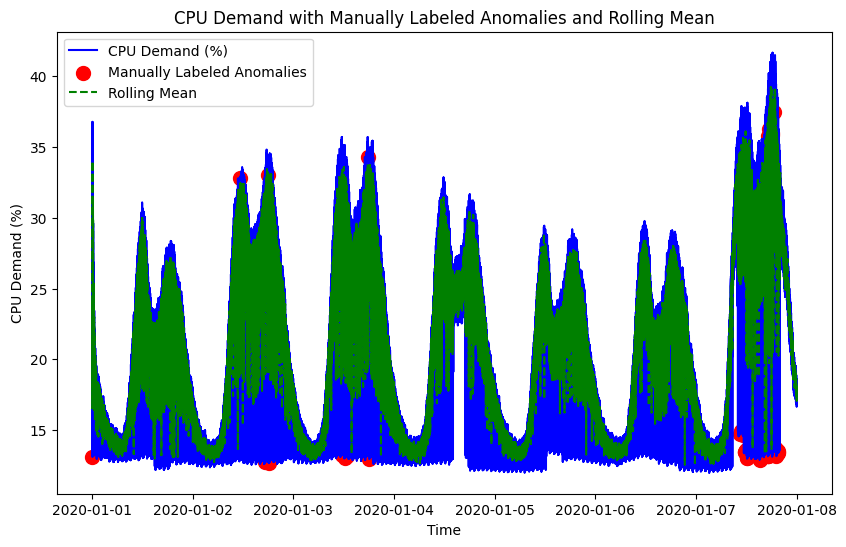

<ipython-input-38-6d84a8177fc9>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'hour'] = first_week.index.hour
<ipython-input-38-6d84a8177fc9>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.loc[:, 'day_of_week'] = first_week.index.dayofweek
<ipython-input-38-6d84a8177fc9>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

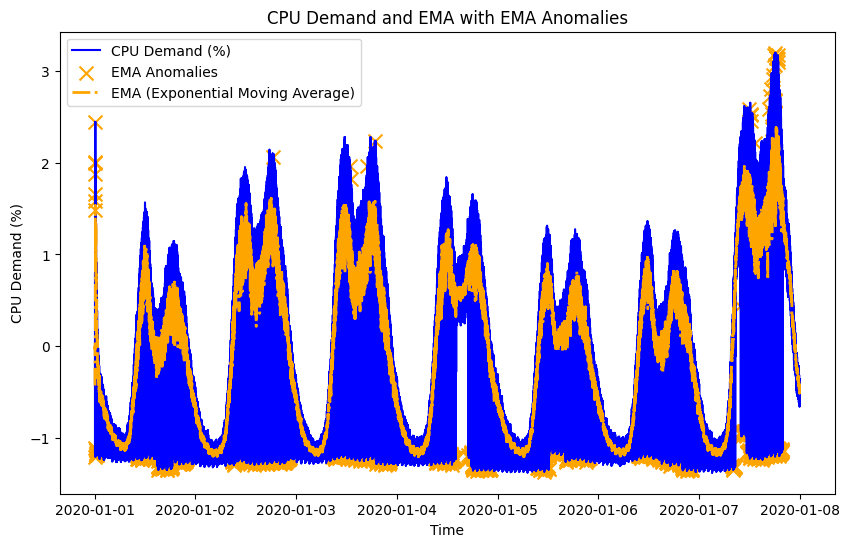

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset from the updated file path
df = pd.read_csv('/nfvData (1).csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Define the start and end date for filtering (one week)
start_date = pd.to_datetime('2020-01-01 00:00')
end_date = pd.to_datetime('2020-01-07 23:59')

# Filter the data for the first week
first_week = df.loc[start_date:end_date]

# 1. Manual Threshold-Based Anomaly Detection using Rolling Mean

# Add rolling mean for manual anomaly detection
first_week['rolling_mean'] = first_week['cpu|demandPct'].rolling(window=3).mean()

# Drop rows with NaN values created by rolling operations
first_week.dropna(inplace=True)

# Define anomaly based on the rolling mean
threshold_factor = 2  # Define how many standard deviations above/below the mean
first_week.loc[:, 'manual_label'] = 0  # Initialize with 0 (normal)

# Mark anomalies if the value is beyond the threshold from the rolling mean
first_week.loc[first_week['cpu|demandPct'] > first_week['rolling_mean'] + threshold_factor * first_week['cpu|demandPct'].std(), 'manual_label'] = 1
first_week.loc[first_week['cpu|demandPct'] < first_week['rolling_mean'] - threshold_factor * first_week['cpu|demandPct'].std(), 'manual_label'] = 1

# 2. Plot the manually labeled anomalies and rolling mean
plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the manually labeled anomalies
anomalies = first_week[first_week['manual_label'] == 1]
plt.scatter(anomalies.index, anomalies['cpu|demandPct'], color='red', label='Manually Labeled Anomalies', marker='o', s=100)

# Plot the rolling mean
plt.plot(first_week.index, first_week['rolling_mean'], label='Rolling Mean', color='green', linestyle='--')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Manually Labeled Anomalies and Rolling Mean')
plt.legend()

# Show the plot
plt.show()

# 3. Enhanced EMA-Based Anomaly Detection

# Add time-based features using .loc
first_week.loc[:, 'hour'] = first_week.index.hour
first_week.loc[:, 'day_of_week'] = first_week.index.dayofweek

# Create lag features for CPU demand
first_week.loc[:, 'lag_1'] = first_week['cpu|demandPct'].shift(1)
first_week.loc[:, 'lag_2'] = first_week['cpu|demandPct'].shift(2)

# Drop rows with NaN values created by shifting operations
first_week.dropna(inplace=True)

# Standardize features for better performance
scaler = StandardScaler()
features_to_scale = ['cpu|demandPct', 'lag_1', 'lag_2']
first_week[features_to_scale] = scaler.fit_transform(first_week[features_to_scale])

# Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
first_week.loc[:, 'ema'] = first_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# Calculate the absolute difference between CPU demand and EMA
first_week.loc[:, 'ema_diff'] = abs(first_week['cpu|demandPct'] - first_week['ema'])

# Set dynamic threshold for EMA anomalies (mean + 2*std of EMA difference)
ema_anomaly_threshold = first_week['ema_diff'].mean() + 2 * first_week['ema_diff'].std()

# Label EMA anomalies
first_week.loc[:, 'ema_anomaly'] = np.where(first_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# 4. Plot the Exponential Moving Average (EMA) and EMA anomalies
plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the EMA-based anomalies
ema_anomalies = first_week[first_week['ema_anomaly'] == 1]
plt.scatter(ema_anomalies.index, ema_anomalies['cpu|demandPct'], color='orange', label='EMA Anomalies', marker='x', s=100)

# Plot the EMA
plt.plot(first_week.index, first_week['ema'], label='EMA (Exponential Moving Average)', color='orange', linestyle='-.', linewidth=2)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand and EMA with EMA Anomalies')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Combine both weeks by concatenating them
combined_data = pd.concat([first_week, second_week], axis=0)

# You can also reset the index if you prefer
combined_data.reset_index(drop=True, inplace=True)

# After combining, create a new DataFrame for analysis
combined_comparison = pd.DataFrame({
    'timestamp': combined_data.index,  # Or the 'timestamp' column if applicable
    'combined_ema_anomalies': combined_data['ema_anomaly']
})

# Now, check combined comparison
print(combined_comparison.head())


   timestamp  combined_ema_anomalies
0          0                       0
1          1                       0
2          2                       0
3          3                       0
4          4                       0


<ipython-input-25-bf435cb3e828>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week['hour'] = second_week.index.hour
<ipython-input-25-bf435cb3e828>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week['day_of_week'] = second_week.index.dayofweek
<ipython-input-25-bf435cb3e828>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

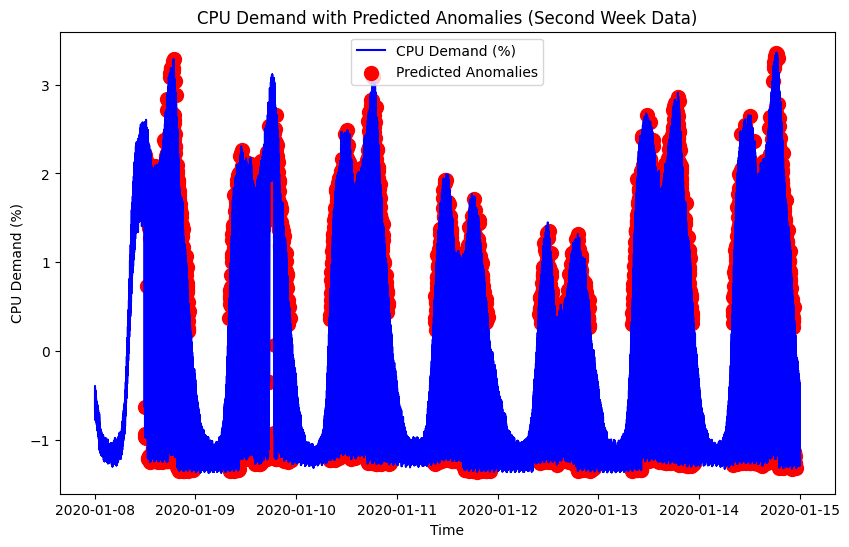

In [ ]:
# Step 1: Filter data for the second week
start_date_second_week = pd.to_datetime('2020-01-08 00:00')
end_date_second_week = pd.to_datetime('2020-01-14 23:59')

second_week = df.loc[start_date_second_week:end_date_second_week]

# Step 2: Preprocess the second week data (same as for the first week)
second_week['hour'] = second_week.index.hour
second_week['day_of_week'] = second_week.index.dayofweek

# Create lag features
second_week['lag_1'] = second_week['cpu|demandPct'].shift(1)
second_week['lag_2'] = second_week['cpu|demandPct'].shift(2)

# Add rolling mean and std
second_week['rolling_mean'] = second_week['cpu|demandPct'].rolling(window=3).mean()
second_week['rolling_std'] = second_week['cpu|demandPct'].rolling(window=3).std()

# Drop rows with NaN values (due to rolling operations)
second_week.dropna(inplace=True)

# Step 3: Standardize the features using the same scaler from the first week
second_week[features_to_scale] = scaler.transform(second_week[features_to_scale])

# Step 4: Predict anomalies using the trained model
X_second_week = second_week[['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']]
y_pred_second_week = rf_model.predict(X_second_week)

# Step 5: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(second_week.index, second_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the predicted anomalies
predicted_anomalies_second_week = second_week[y_pred_second_week == 1]
plt.scatter(predicted_anomalies_second_week.index, predicted_anomalies_second_week['cpu|demandPct'], color='red', label='Predicted Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Predicted Anomalies (Second Week Data)')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Check the distribution of y_test to ensure anomalies exist
print(f"Distribution of y_test: {pd.Series(y_test).value_counts()}")

# Ensure y_pred_ema_test has the same length as y_test
if len(y_test) != len(y_pred_ema_test):
    print(f"Mismatch in lengths: y_test = {len(y_test)}, y_pred_ema_test = {len(y_pred_ema_test)}")
    # Slice y_pred_ema_test to match the length of y_test
    y_pred_ema_test = y_pred_ema_test[:len(y_test)]

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return precision, recall, f1

# Evaluate the EMA model (or other model) using threshold-based anomalies
precision_ema, recall_ema, f1_ema = evaluate_model(y_test, y_pred_ema_test)

# Print the evaluation metrics for the EMA model
print(f"EMA model (using threshold-based anomalies):")
print(f"Precision: {precision_ema:.4f}, Recall: {recall_ema:.4f}, F1-Score: {f1_ema:.4f}")


Distribution of y_test: true_anomaly
0    10075
Name: count, dtype: int64
EMA model (using threshold-based anomalies):
Precision: 0.0000, Recall: 1.0000, F1-Score: 0.0000


In [ ]:
# Check basic statistics of 'cpu|demandPct' to understand its range
print(first_week['cpu|demandPct'].describe())

# Calculate IQR for dynamic thresholds
Q1 = first_week['cpu|demandPct'].quantile(0.25)
Q3 = first_week['cpu|demandPct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound is", lower_bound)
print("Upper Bound is", upper_bound)

# Make sure to modify the original DataFrame directly to avoid warnings
first_week = first_week.copy()

# Add a 'manual_label' column for anomalies using .loc to avoid warnings
first_week.loc[:, 'manual_label'] = 0

# Update manual labels based on IQR thresholds
first_week.loc[first_week['cpu|demandPct'] > upper_bound, 'manual_label'] = 1  # Above upper threshold
first_week.loc[first_week['cpu|demandPct'] < lower_bound, 'manual_label'] = 1  # Below lower threshold

# Detect sudden jumps and mark as anomalies
first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
first_week.loc[first_week['diff'] > 10, 'manual_label'] = 1  # Sudden spike or drop greater than 10%

# Drop the 'diff' column as it's no longer needed
first_week.drop(columns=['diff'], inplace=True)

# Print the count of anomalies detected
print("Manual Label Counts:")
print(first_week['manual_label'].value_counts())


count    5.037400e+04
mean     2.640521e-16
std      1.000010e+00
min     -1.377173e+00
25%     -1.019446e+00
50%     -2.624520e-02
75%      8.106943e-01
max      3.197357e+00
Name: cpu|demandPct, dtype: float64
Lower Bound is -3.7646572885050067
Upper Bound is 3.5559053062749273
Manual Label Counts:
manual_label
0    50374
Name: count, dtype: int64


In [ ]:
# Define the percentage of anomalies to identify
anomaly_percentage = 0.05  # Top 5%

# Calculate the number of anomalies to detect
num_anomalies = int(len(first_week) * anomaly_percentage)

# Use .loc to ensure we're modifying the DataFrame safely
first_week.loc[:, 'iqr_anomaly'] = 0
iqr_anomalies = first_week['cpu|demandPct'].nlargest(num_anomalies).index
first_week.loc[iqr_anomalies, 'iqr_anomaly'] = 1

# Calculate and mark the sudden jump anomalies
first_week.loc[:, 'diff'] = first_week['cpu|demandPct'].diff().abs()
first_week.loc[:, 'jump_anomaly'] = 0
jump_anomalies = first_week['diff'].nlargest(num_anomalies).index
first_week.loc[jump_anomalies, 'jump_anomaly'] = 1

# Drop the temporary 'diff' column
first_week.drop(columns=['diff'], inplace=True)

# Count anomalies again
iqr_anomaly_count = first_week['iqr_anomaly'].sum()
jump_anomaly_count = first_week['jump_anomaly'].sum()

# Print the counts to verify
print(f"IQR-Based Anomalies Count: {iqr_anomaly_count}")
print(f"Sudden Jumps Anomalies Count: {jump_anomaly_count}")

# Verify consistency
if iqr_anomaly_count == jump_anomaly_count:
    print("The anomaly counts are consistent across both methods.")
else:
    print("The anomaly counts still differ. Double-check the implementation.")


IQR-Based Anomalies Count: 7147
Sudden Jumps Anomalies Count: 16551
The anomaly counts still differ. Double-check the implementation.


<ipython-input-7-39e4fcecd0fc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.drop(columns=['diff'], inplace=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/nfvData.csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Extract the hour from the timestamp for contextual filtering
df['hour'] = df['timestamp'].dt.hour

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Define the start and end date for filtering (one week)
start_date = pd.to_datetime('2020-01-01 00:00')
end_date = pd.to_datetime('2020-01-07 23:59')

# Filter the data for the first week
first_week = df.loc[start_date:end_date]

# Contextual IQR (Separate thresholds for day and night)
day_data = first_week[first_week['hour'] < 18]  # Daytime
night_data = first_week[first_week['hour'] >= 18]  # Nighttime

# Compute IQR separately for day and night
Q1_day = day_data['cpu|demandPct'].quantile(0.25)
Q3_day = day_data['cpu|demandPct'].quantile(0.75)
IQR_day = Q3_day - Q1_day

Q1_night = night_data['cpu|demandPct'].quantile(0.25)
Q3_night = night_data['cpu|demandPct'].quantile(0.75)
IQR_night = Q3_night - Q1_night

# Calculate thresholds
lower_bound_day = Q1_day - 1.5 * IQR_day
upper_bound_day = Q3_day + 1.5 * IQR_day

lower_bound_night = Q1_night - 1.5 * IQR_night
upper_bound_night = Q3_night + 1.5 * IQR_night

# Mark anomalies based on context
day_data['manual_label'] = ((day_data['cpu|demandPct'] < lower_bound_day) |
                            (day_data['cpu|demandPct'] > upper_bound_day)).astype(int)
night_data['manual_label'] = ((night_data['cpu|demandPct'] < lower_bound_night) |
                              (night_data['cpu|demandPct'] > upper_bound_night)).astype(int)

# Combine the day and night data
first_week = pd.concat([day_data, night_data])


<ipython-input-3-322f832f5fe2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data['manual_label'] = ((day_data['cpu|demandPct'] < lower_bound_day) |
<ipython-input-3-322f832f5fe2>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  night_data['manual_label'] = ((night_data['cpu|demandPct'] < lower_bound_night) |


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/nfvData.csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Filter data for the first week
start_date = pd.to_datetime('2020-01-01 00:00')
end_date = pd.to_datetime('2020-01-07 23:59')
first_week = df.loc[start_date:end_date]

# Ensure 'cpu|demandPct' is numeric and handle errors
first_week['cpu|demandPct'] = pd.to_numeric(first_week['cpu|demandPct'], errors='coerce')

# Remove rows with NaN values after conversion
first_week.dropna(subset=['cpu|demandPct'], inplace=True)

# Remove duplicate timestamps by taking the mean of numeric columns
first_week = first_week.groupby(first_week.index).mean()

# Ensure the time series has the correct frequency (minute-level)
first_week = first_week.asfreq('T')  # Resample to minute-level frequency

# Get the 'cpu|demandPct' column for STL decomposition
cpu_demand = first_week['cpu|demandPct']

# Perform STL decomposition with proper seasonal period
from statsmodels.tsa.seasonal import STL
stl = STL(cpu_demand, seasonal=1440)  # 1440 for daily seasonality (60 mins * 24 hrs)
result = stl.fit()


<ipython-input-15-010bb711e4d5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['cpu|demandPct'] = pd.to_numeric(first_week['cpu|demandPct'], errors='coerce')
<ipython-input-15-010bb711e4d5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.dropna(subset=['cpu|demandPct'], inplace=True)


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL

# Assuming first_week is your DataFrame
# Convert 'cpu|demandPct' to numeric, forcing errors to NaN
first_week['cpu|demandPct'] = pd.to_numeric(first_week['cpu|demandPct'], errors='coerce')

# Drop rows where 'cpu|demandPct' is NaN
first_week.dropna(subset=['cpu|demandPct'], inplace=True)

# Ensure the index is a datetime index for STL decomposition to work properly
# If the index is not datetime, you can convert it like this:
# first_week['date'] = pd.to_datetime(first_week['date'])
# first_week.set_index('date', inplace=True)

# Perform STL decomposition (Specify a seasonal period or use the default period if unsure)
stl = STL(first_week['cpu|demandPct'], seasonal=13)  # Adjust seasonal period based on your data
result = stl.fit()

# The seasonal component can help detect anomalies
# Calculate residuals (observed value - trend - seasonal components)
first_week['residual'] = result.resid

# Define an anomaly threshold based on the residuals
threshold = 3 * np.std(first_week['residual'])  # 3 standard deviations as a common threshold

# Mark anomalies as 1, and normal data as 0
first_week['anomaly'] = np.where(np.abs(first_week['residual']) > threshold, 1, 0)

# Display the result
print(first_week[['cpu|demandPct', 'residual', 'anomaly']])


<ipython-input-18-9e5bf96cf6ab>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week['cpu|demandPct'] = pd.to_numeric(first_week['cpu|demandPct'], errors='coerce')
<ipython-input-18-9e5bf96cf6ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week.dropna(subset=['cpu|demandPct'], inplace=True)


ValueError: Unable to determine period from endog

In [ ]:
# Compute EMA with multiple spans
spans = [5, 10, 20]
for span in spans:
    first_week[f'ema_{span}'] = first_week['cpu|demandPct'].ewm(span=span, adjust=False).mean()

# Compute differences and anomalies for each EMA
for span in spans:
    first_week[f'ema_diff_{span}'] = abs(first_week['cpu|demandPct'] - first_week[f'ema_{span}'])
    ema_threshold = first_week[f'ema_diff_{span}'].mean() + 2 * first_week[f'ema_diff_{span}'].std()
    first_week[f'ema_anomaly_{span}'] = (first_week[f'ema_diff_{span}'] > ema_threshold).astype(int)

# Combine EMA anomalies (logical OR across spans)
first_week['ema_anomaly'] = first_week[[f'ema_anomaly_{span}' for span in spans]].max(axis=1)


In [ ]:
# Assign weights to anomalies (IQR and EMA)
iqr_weight = 0.6
ema_weight = 0.4

# Compute weighted anomaly scores
first_week['anomaly_score'] = (iqr_weight * first_week['manual_label'] +
                               ema_weight * first_week['ema_anomaly'])

# Final anomaly classification based on score
anomaly_threshold = 0.5  # Adjust based on desired sensitivity
first_week['combined_anomaly'] = (first_week['anomaly_score'] > anomaly_threshold).astype(int)


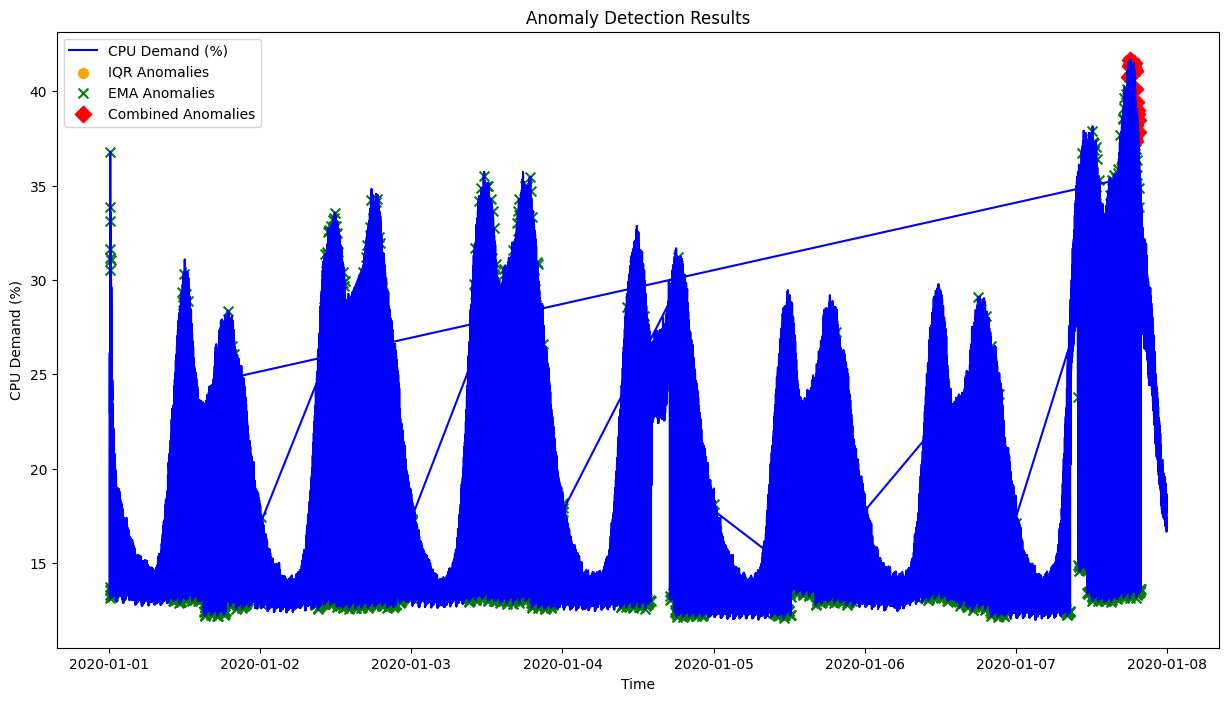

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(first_week.index, first_week['cpu|demandPct'], label='CPU Demand (%)', color='blue')
plt.scatter(first_week.index[first_week['manual_label'] == 1],
            first_week['cpu|demandPct'][first_week['manual_label'] == 1],
            color='orange', label='IQR Anomalies', marker='o', s=50)
plt.scatter(first_week.index[first_week['ema_anomaly'] == 1],
            first_week['cpu|demandPct'][first_week['ema_anomaly'] == 1],
            color='green', label='EMA Anomalies', marker='x', s=50)
plt.scatter(first_week.index[first_week['combined_anomaly'] == 1],
            first_week['cpu|demandPct'][first_week['combined_anomaly'] == 1],
            color='red', label='Combined Anomalies', marker='D', s=70)
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
first_week = pd.read_csv('/content/labeled_first_week_nfvData_enhanced_combined.csv')

# Manually labeled anomalies
manual_anomalies = first_week[first_week['manual_label'] == 1]

# Combined anomalies detected (using both EMA and manual labeling)
combined_anomalies = first_week[first_week['combined_anomaly'] == 1]

# Print the counts of each
print("Manually Labeled Anomalies Count:", len(manual_anomalies))
print("Combined Detected Anomalies Count:", len(combined_anomalies))

# Display the anomalies
print("\nManually Labeled Anomalies:")
print(manual_anomalies[['cpu|demandPct', 'manual_label']].head())

print("\nCombined Detected Anomalies:")
print(combined_anomalies[['cpu|demandPct', 'ema', 'ema_diff', 'combined_anomaly']].head())

# Compare both sets
# True Positives: Manually labeled as anomalies and also detected by combined anomalies
true_positives = manual_anomalies[manual_anomalies['combined_anomaly'] == 1]
print("\nTrue Positives (Correctly Detected by Combined Anomaly Detection):", len(true_positives))

# False Negatives: Manually labeled as anomalies but not detected by combined anomalies
false_negatives = manual_anomalies[manual_anomalies['combined_anomaly'] == 0]
print("False Negatives (Missed by Combined Anomaly Detection):", len(false_negatives))

# False Positives: Not manually labeled as anomalies but detected by combined anomalies
false_positives = combined_anomalies[combined_anomalies['manual_label'] == 0]
print("False Positives (Incorrectly Detected by Combined Anomaly Detection):", len(false_positives))

# Calculate True Negatives (TN)
total_points = len(first_week)  # Total points in the dataset
total_manual_anomalies = len(manual_anomalies)  # Total manually labeled anomalies
normal_points = total_points - total_manual_anomalies  # Total normal points
true_negatives = normal_points - len(false_positives)  # True negatives

# Calculate metrics
accuracy = (len(true_positives) + true_negatives) / total_points
precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) != 0 else 0
recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display the metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")


Manually Labeled Anomalies Count: 4057
Combined Detected Anomalies Count: 4677

Manually Labeled Anomalies:
    cpu|demandPct  manual_label
6       -1.175400             1
9        0.533410             1
23       1.479506             1
31      -1.202214             1
32       1.656418             1

Combined Detected Anomalies:
    cpu|demandPct       ema  ema_diff  combined_anomaly
6       -1.175400 -0.213048  0.962352                 1
9        0.533410 -0.181478  0.714887                 1
23       1.479506  0.136131  1.343375                 1
24       1.653644  0.280656  1.372988                 1
25       1.581626  0.404558  1.177068                 1

True Positives (Correctly Detected by Combined Anomaly Detection): 4057
False Negatives (Missed by Combined Anomaly Detection): 0
False Positives (Incorrectly Detected by Combined Anomaly Detection): 620

Metrics:
Accuracy: 98.77%
Precision: 86.74%
Recall: 100.00%
F1 Score: 92.90%


Lower Bound is -10.475665089999998
Upper Bound is 54.988331790000004


<ipython-input-2-63c44367c621>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'manual_label'] = 0
<ipython-input-2-63c44367c621>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'diff'] = second_week['cpu|demandPct'].diff().abs()
<ipython-input-2-63c44367c621>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

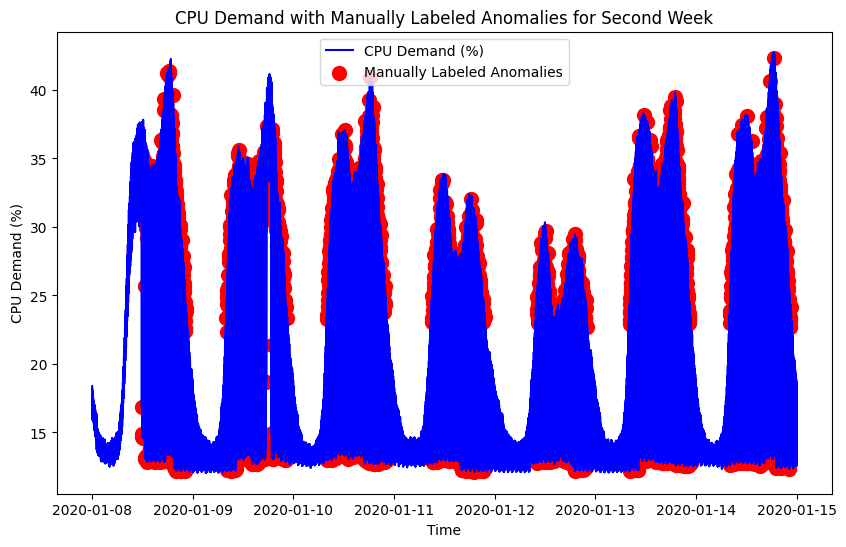

<ipython-input-2-63c44367c621>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'hour'] = second_week.index.hour
<ipython-input-2-63c44367c621>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_week.loc[:, 'day_of_week'] = second_week.index.dayofweek
<ipython-input-2-63c44367c621>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

Labeled dataset for the second week (with enhanced anomaly detection):
                     cpu|demandPct       ema  ema_diff  ema_anomaly  \
timestamp                                                             
2020-01-08 00:04:00      -0.587880 -0.587880  0.000000            0   
2020-01-08 00:04:00      -0.624005 -0.591321  0.032684            0   
2020-01-08 00:04:00      -0.683067 -0.600058  0.083008            0   
2020-01-08 00:04:00      -0.531768 -0.593555  0.061787            0   
2020-01-08 00:04:00      -0.715096 -0.605130  0.109966            0   

                     manual_label  combined_anomaly  
timestamp                                            
2020-01-08 00:04:00             0                 0  
2020-01-08 00:04:00             0                 0  
2020-01-08 00:04:00             0                 0  
2020-01-08 00:04:00             0                 0  
2020-01-08 00:04:00             0                 0  

Combined Anomaly Detection Counts:
combined_anomaly


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the second week dataset
df = pd.read_csv('/content/nfvData.csv')  # Update this to the correct path for your second week data

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid timestamps (if any)
df.dropna(subset=['timestamp'], inplace=True)

# Set the 'timestamp' column as the index
df.set_index('timestamp', inplace=True)

# Sort the index to ensure it's in the correct order
df.sort_index(inplace=True)

# Define the start and end date for filtering (second week)
start_date = pd.to_datetime('2020-01-08 00:00')  # Adjusted for the second week
end_date = pd.to_datetime('2020-01-14 23:59')  # Adjusted for the second week

# Filter the data for the second week
second_week = df.loc[start_date:end_date]

# 1. Manual Threshold-Based Anomaly Detection

# Calculate IQR for dynamic thresholds
Q1 = second_week['cpu|demandPct'].quantile(0.25)
Q3 = second_week['cpu|demandPct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower Bound is", lower_bound)
print("Upper Bound is", upper_bound)

# Add a 'manual_label' column for anomalies using .loc to avoid warnings
second_week.loc[:, 'manual_label'] = 0

# Update manual labels based on IQR thresholds
second_week.loc[second_week['cpu|demandPct'] > upper_bound, 'manual_label'] = 1  # Above upper threshold
second_week.loc[second_week['cpu|demandPct'] < lower_bound, 'manual_label'] = 1  # Below lower threshold

# Detect sudden jumps and mark as anomalies
second_week.loc[:, 'diff'] = second_week['cpu|demandPct'].diff().abs()
second_week.loc[second_week['diff'] > 10, 'manual_label'] = 1  # Sudden spike or drop greater than 10%

# Drop the 'diff' column as it's no longer needed
second_week.drop(columns=['diff'], inplace=True)

# 2. Plot the manually labeled anomalies before applying EMA
plt.figure(figsize=(10, 6))

# Plot the CPU demand over time
plt.plot(second_week.index, second_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the manually labeled anomalies
anomalies = second_week[second_week['manual_label'] == 1]
plt.scatter(anomalies.index, anomalies['cpu|demandPct'], color='red', label='Manually Labeled Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Manually Labeled Anomalies for Second Week')
plt.legend()

# Show the plot
plt.show()

# 2. Enhanced EMA-Based Anomaly Detection

# Add time-based features using .loc
second_week.loc[:, 'hour'] = second_week.index.hour
second_week.loc[:, 'day_of_week'] = second_week.index.dayofweek

# Create lag features for CPU demand
second_week.loc[:, 'lag_1'] = second_week['cpu|demandPct'].shift(1)
second_week.loc[:, 'lag_2'] = second_week['cpu|demandPct'].shift(2)

# Add rolling mean and standard deviation
second_week.loc[:, 'rolling_mean'] = second_week['cpu|demandPct'].rolling(window=3).mean()
second_week.loc[:, 'rolling_std'] = second_week['cpu|demandPct'].rolling(window=3).std()

# Drop rows with NaN values created by rolling operations
second_week.dropna(inplace=True)

# Standardize features for better performance
scaler = StandardScaler()
features_to_scale = ['cpu|demandPct', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']
second_week[features_to_scale] = scaler.fit_transform(second_week[features_to_scale])

# Calculate the Exponential Moving Average (EMA)
ema_span = 20  # Define the window size for EMA
second_week.loc[:, 'ema'] = second_week['cpu|demandPct'].ewm(span=ema_span, adjust=False).mean()

# Define an anomaly if the absolute difference between EMA and actual value is large
second_week.loc[:, 'ema_diff'] = abs(second_week['cpu|demandPct'] - second_week['ema'])

# Set dynamic threshold for EMA anomalies (mean + 2*std)
ema_anomaly_threshold = second_week['ema_diff'].mean() + 2 * second_week['ema_diff'].std()

# Update the anomalies based on the threshold using .loc
second_week.loc[:, 'ema_anomaly'] = np.where(second_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# Combine results from both methods
second_week.loc[:, 'combined_anomaly'] = second_week[['ema_anomaly', 'manual_label']].max(axis=1)

# Save the labeled dataset
second_week.to_csv('/content/labeled_second_week_nfvData_enhanced_combined.csv')

# Display the labeled dataset with EMA anomaly labels
print("Labeled dataset for the second week (with enhanced anomaly detection):")
print(second_week[['cpu|demandPct', 'ema', 'ema_diff', 'ema_anomaly', 'manual_label', 'combined_anomaly']].head())

# Count and display anomalies
print("\nCombined Anomaly Detection Counts:")
print(second_week['combined_anomaly'].value_counts())

# Manually labeled anomalies
manual_anomalies = second_week[second_week['manual_label'] == 1]

# Combined anomalies detected (using both EMA and manual labeling)
combined_anomalies = second_week[second_week['combined_anomaly'] == 1]

# Print the counts of each
print("Manually Labeled Anomalies Count:", len(manual_anomalies))
print("Combined Detected Anomalies Count:", len(combined_anomalies))

# Display the anomalies
print("\nManually Labeled Anomalies:")
print(manual_anomalies[['cpu|demandPct', 'manual_label']].head())

print("\nCombined Detected Anomalies:")
print(combined_anomalies[['cpu|demandPct', 'ema', 'ema_diff', 'combined_anomaly']].head())

# Compare both sets
# True Positives: Manually labeled as anomalies and also detected by combined anomalies
true_positives = manual_anomalies[manual_anomalies['combined_anomaly'] == 1]
print("\nTrue Positives (Correctly Detected by Combined Anomaly Detection):", len(true_positives))

# False Negatives: Manually labeled as anomalies but not detected by combined anomalies
false_negatives = manual_anomalies[manual_anomalies['combined_anomaly'] == 0]
print("False Negatives (Missed by Combined Anomaly Detection):", len(false_negatives))

# False Positives: Not manually labeled as anomalies but detected by combined anomalies
false_positives = combined_anomalies[combined_anomalies['manual_label'] == 0]
print("False Positives (Incorrectly Detected by Combined Anomaly Detection):", len(false_positives))

# Calculate True Negatives (TN)
total_points = len(second_week)  # Total points in the dataset
total_manual_anomalies = len(manual_anomalies)  # Total manually labeled anomalies
normal_points = total_points - total_manual_anomalies  # Total normal points
true_negatives = normal_points - len(false_positives)  # True negatives

# Calculate metrics
accuracy = (len(true_positives) + true_negatives) / total_points
precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) != 0 else 0
recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Display the metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1_score:.2%}")


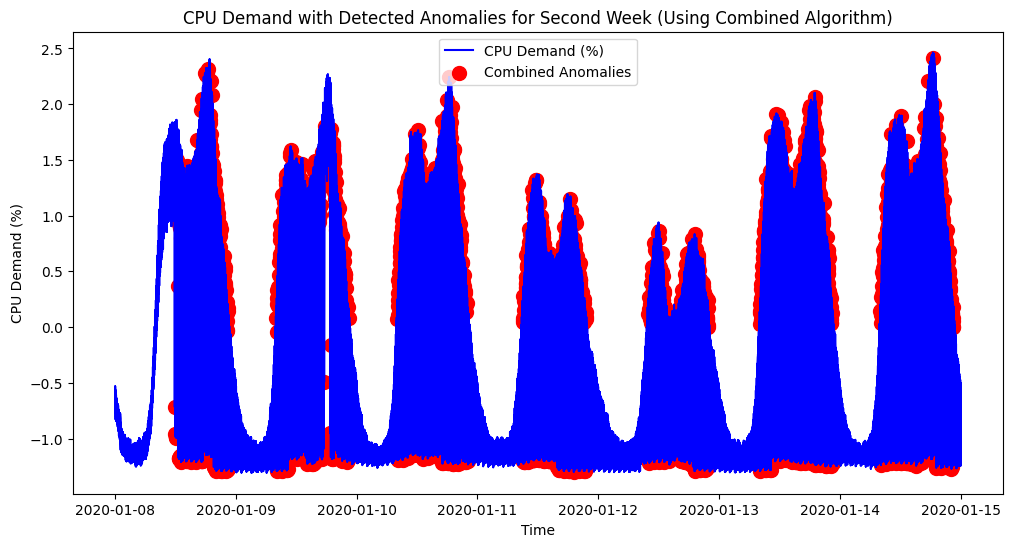

In [ ]:
# Plot the CPU demand and combined anomalies for the second week
plt.figure(figsize=(12, 6))

# Plot the CPU demand over time
plt.plot(second_week.index, second_week['cpu|demandPct'], label='CPU Demand (%)', color='blue', linewidth=1.5)

# Highlight the combined anomalies
combined_anomalies = second_week[second_week['combined_anomaly'] == 1]
plt.scatter(combined_anomalies.index, combined_anomalies['cpu|demandPct'], color='red', label='Combined Anomalies', marker='o', s=100)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('CPU Demand (%)')
plt.title('CPU Demand with Detected Anomalies for Second Week (Using Combined Algorithm)')
plt.legend()

# Show the plot
plt.show()



Total detected anomalies: 4677


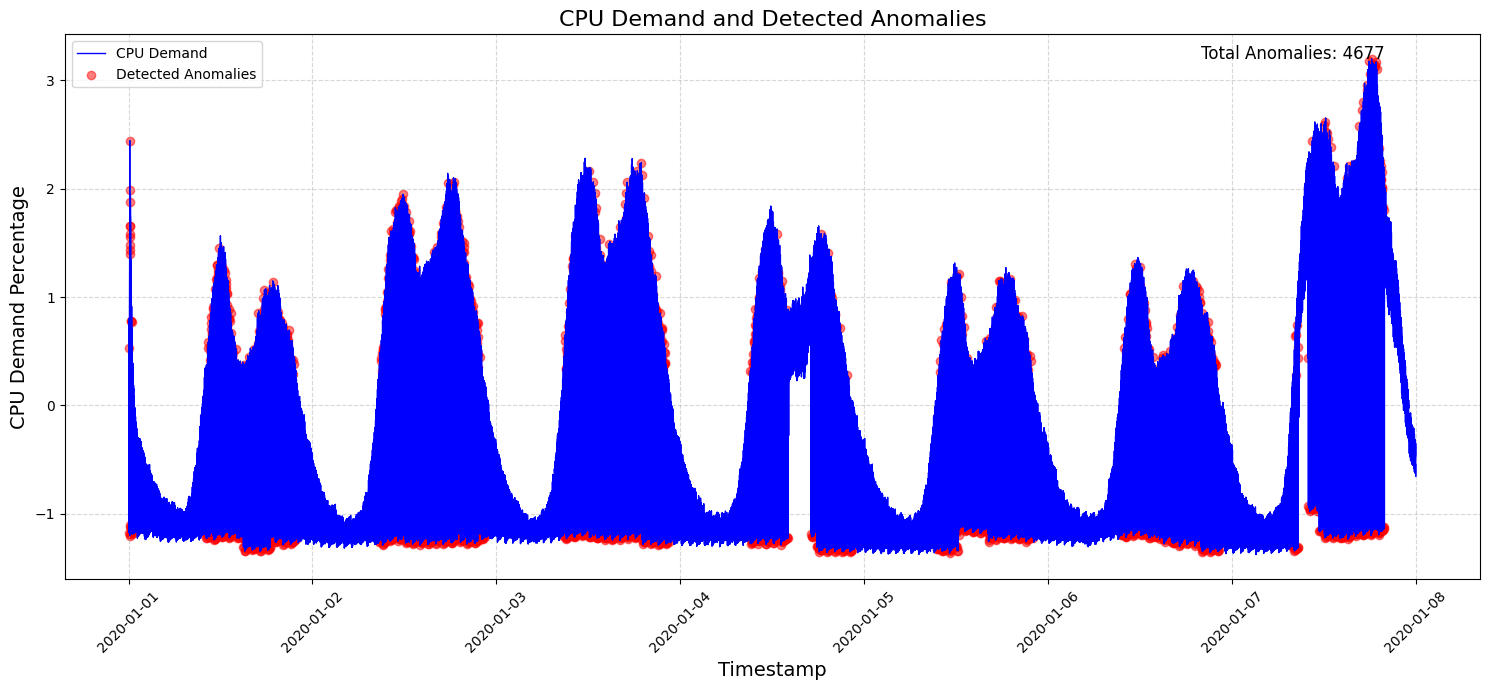

In [ ]:
anomalies_count = first_week['combined_anomaly'].value_counts()[1]
print("\nTotal detected anomalies:", anomalies_count)

# Plotting the CPU Demand with Detected Anomalies
plt.figure(figsize=(15, 7))

# Plot the CPU Demand
plt.plot(first_week.index, first_week['cpu|demandPct'], color='blue', label='CPU Demand', linewidth=1)

# Highlight anomalies detected
anomalies = first_week[first_week['combined_anomaly'] == 1]

# Plot anomalies
plt.scatter(anomalies.index, anomalies['cpu|demandPct'], color='red', marker='o', label='Detected Anomalies', alpha=0.5)

# Adding Titles and Labels
plt.title('CPU Demand and Detected Anomalies', fontsize=16)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('CPU Demand Percentage', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate the total count of anomalies on the graph
plt.text(x=anomalies.index[-1], y=anomalies['cpu|demandPct'].max(),
         s=f'Total Anomalies: {anomalies_count}',
         fontsize=12, color='black', ha='right')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/Laptop Performance.csv')

# Print the dataset
print(df)


          Date     device_SN                   device_Model  device_Age  \
0     1/4/2024     000654JT7                   ELITEBOOK G6           3   
1     1/4/2024     000654JT8        PRODESK 400 G4 DM (TAA)           1   
2     1/4/2024     000654JT9                    Vostro 3000           2   
3     1/4/2024    000654JT10  ELITEDESK 800 G5 DESKTOP MINI           1   
4     1/4/2024    000654JT11  ELITEDESK 800 G5 DESKTOP MINI           4   
...        ...           ...                            ...         ...   
2995  6/4/2024  0007460G1274                  Inspiron 5000           4   
2996  6/4/2024  0007460G1275                    Vostro 3000           1   
2997  6/4/2024  0007460G1276                  OPTIPLEX 7040           1   
2998  6/4/2024  0007460G1277                  Chromebook 14           1   
2999  6/4/2024  0007460G1278                 PRODESK 400 G7           2   

                                      processor  cores  \
0      Intel(R) Core(TM) i5-8250U CPU @ 1

In [ ]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Check the data types to ensure conversion was successful
print(df.dtypes)


Date                            datetime64[ns]
device_SN                               object
device_Model                            object
device_Age                               int64
processor                               object
cores                                    int64
graphics                                object
CPU_Utilization                          int64
Memory Utilization                       int64
diskIO Utilization                       int64
List Of Applications Running            object
Crashed Applications                    object
IsApplicationCrashed                    object
dtype: object


In [ ]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [ ]:
df.sort_index(inplace=True)


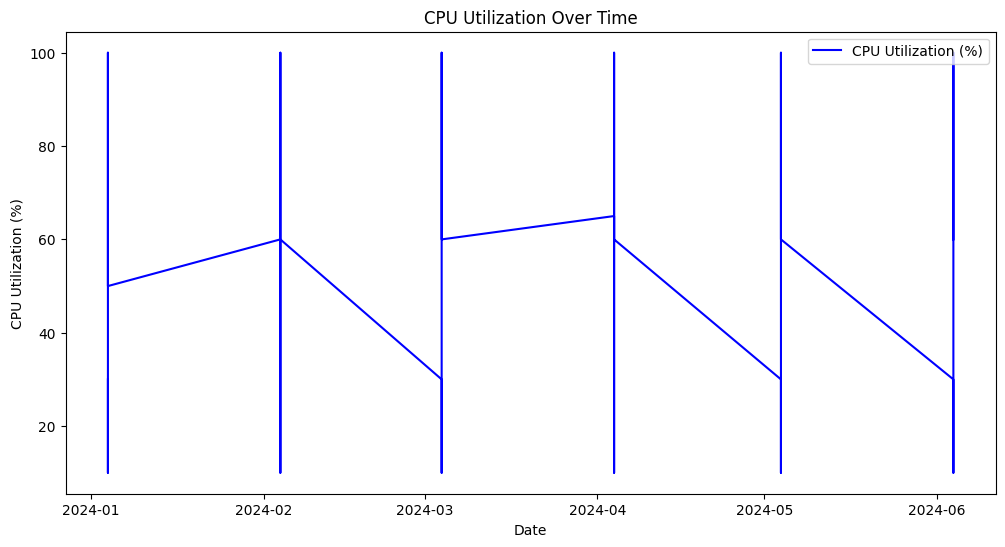

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CPU_Utilization'], label='CPU Utilization (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('CPU Utilization (%)')
plt.title('CPU Utilization Over Time')
plt.legend()
plt.show()



Manual Label Anomaly Detection:
Accuracy: 0.01, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
Confusion Matrix:
 [[  2 165]
 [  0   0]]

Ema Anomaly Anomaly Detection:
Accuracy: 0.95, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
Confusion Matrix:
 [[159   8]
 [  0   0]]

Combined Anomaly Anomaly Detection:
Accuracy: 0.01, Precision: 0.00, Recall: 0.00, F1 Score: 0.00
Confusion Matrix:
 [[  2 165]
 [  0   0]]


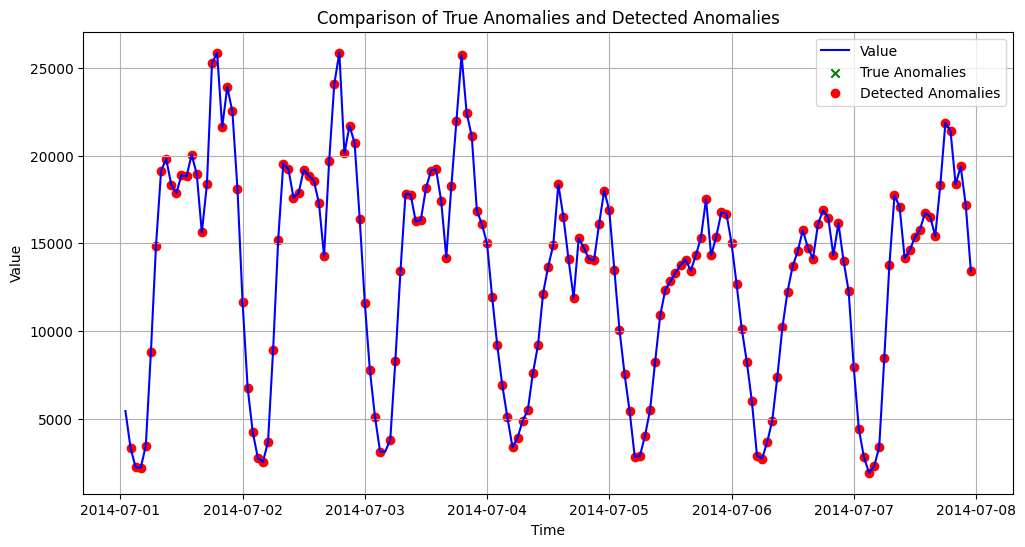

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('/content/processed_nyc_taxi_with_anomalies.csv')

# Convert timestamp to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# Define the start and end date for filtering (one week for testing)
start_date = pd.to_datetime('2014-07-01 00:00')
end_date = pd.to_datetime('2014-07-07 23:59')

# Filter the data for the specified week
first_week = df.loc[start_date:end_date].copy()

# Load existing anomaly labels (assuming 'Outliers' is the column for predefined labels)
first_week['Outliers'] = first_week['Outliers'].astype(int)  # Ensure 'Outliers' is correctly referenced

# 1. Manual Threshold-Based Anomaly Detection

# Calculate IQR for dynamic thresholds
Q1 = first_week['value'].quantile(0.25)
Q3 = first_week['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR  # Adjusted multiplier
upper_bound = Q3 + 2 * IQR  # Adjusted multiplier

# Initialize manual_label column
first_week['manual_label'] = 0
first_week.loc[first_week['value'] > upper_bound, 'manual_label'] = 1
first_week.loc[first_week['value'] < lower_bound, 'manual_label'] = 1

# Detect sudden jumps as anomalies
jump_threshold = 10  # You can adjust this threshold based on your understanding of the data
first_week['diff'] = first_week['value'].diff().abs()
first_week.loc[first_week['diff'] > jump_threshold, 'manual_label'] = 1
first_week.drop(columns=['diff'], inplace=True)

# 2. Enhanced EMA-Based Anomaly Detection

# Standardize features
scaler = StandardScaler()
first_week['scaled_value'] = scaler.fit_transform(first_week[['value']])

# Calculate EMA
ema_span = 20
first_week['ema'] = first_week['scaled_value'].ewm(span=ema_span, adjust=False).mean()
first_week['ema_diff'] = abs(first_week['scaled_value'] - first_week['ema'])
ema_anomaly_threshold = first_week['ema_diff'].mean() + 2 * first_week['ema_diff'].std()

# Label EMA anomalies
first_week['ema_anomaly'] = np.where(first_week['ema_diff'] > ema_anomaly_threshold, 1, 0)

# Combine results from both methods
first_week['combined_anomaly'] = first_week[['ema_anomaly', 'manual_label']].max(axis=1)

# 3. Compare with Existing Labels

# Evaluation metrics
metrics = {}
for method in ['manual_label', 'ema_anomaly', 'combined_anomaly']:
    metrics[method] = {
        'accuracy': accuracy_score(first_week['Outliers'], first_week[method]),
        'precision': precision_score(first_week['Outliers'], first_week[method], zero_division=0),
        'recall': recall_score(first_week['Outliers'], first_week[method], zero_division=0),
        'f1': f1_score(first_week['Outliers'], first_week[method], zero_division=0),
        'confusion_matrix': confusion_matrix(first_week['Outliers'], first_week[method])
    }

# 4. Display Results
for method in metrics:
    print(f"\n{method.replace('_', ' ').title()} Anomaly Detection:")
    print(f"Accuracy: {metrics[method]['accuracy']:.2f}, Precision: {metrics[method]['precision']:.2f}, "
          f"Recall: {metrics[method]['recall']:.2f}, F1 Score: {metrics[method]['f1']:.2f}")
    print("Confusion Matrix:\n", metrics[method]['confusion_matrix'])

# 5. Plot for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(first_week.index, first_week['value'], label='Value', color='blue', linewidth=1.5)
plt.scatter(first_week[first_week['Outliers'] == 1].index,
            first_week[first_week['Outliers'] == 1]['value'],
            color='green', label='True Anomalies', marker='x')
plt.scatter(first_week[first_week['combined_anomaly'] == 1].index,
            first_week[first_week['combined_anomaly'] == 1]['value'],
            color='red', label='Detected Anomalies', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of True Anomalies and Detected Anomalies')
plt.legend()
plt.grid()
plt.show()


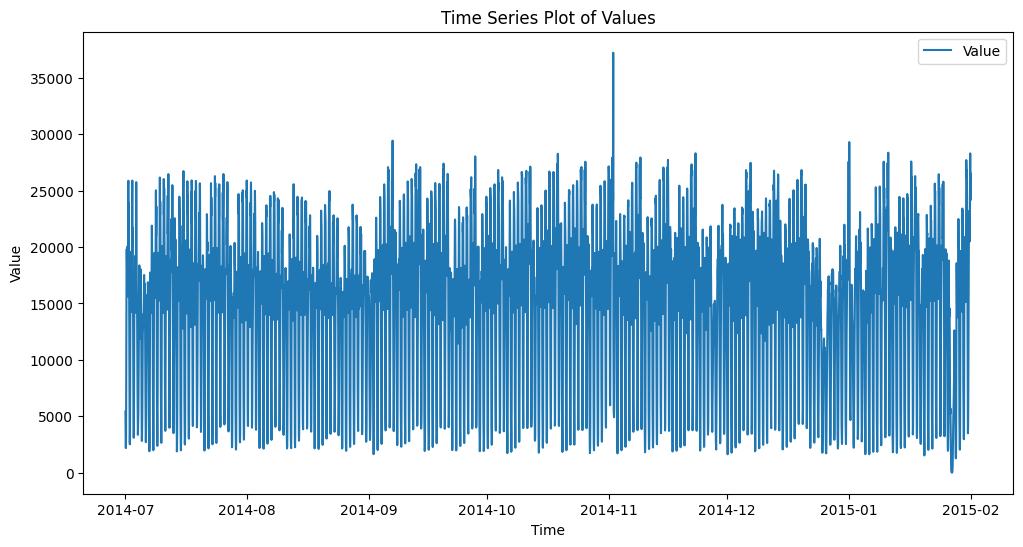

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot of Values')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/processed_nyc_taxi_with_anomalies.csv')

# Convert 'timestamp' to datetime format and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# Define the start and end dates for the first week of July 2014
start_date = '2014-07-01'
end_date = '2014-07-07'

# Filter the data for the specified week
first_week = df.loc[start_date:end_date].copy()

# Display the first week dataset
print("First Week Dataset:")
print(first_week)

# Apply EMA
ema_span = 20  # You can adjust the span based on your analysis needs
first_week['ema'] = first_week['value'].ewm(span=ema_span, adjust=False).mean()

# Display the first week dataset with EMA
print("\nFirst Week Dataset with EMA:")
print(first_week[['value', 'ema']])


First Week Dataset:
                       value  Weekday  Hour  Day  Month  Year  Month_day  \
timestamp                                                                  
2014-07-01 01:00:00   5433.0  Tuesday     1    1      7  2014          1   
2014-07-01 02:00:00   3346.5  Tuesday     2    1      7  2014          1   
2014-07-01 03:00:00   2216.5  Tuesday     3    1      7  2014          1   
2014-07-01 04:00:00   2189.5  Tuesday     4    1      7  2014          1   
2014-07-01 05:00:00   3439.5  Tuesday     5    1      7  2014          1   
...                      ...      ...   ...  ...    ...   ...        ...   
2014-07-07 19:00:00  21422.5   Monday    19    0      7  2014          7   
2014-07-07 20:00:00  18366.5   Monday    20    0      7  2014          7   
2014-07-07 21:00:00  19386.5   Monday    21    0      7  2014          7   
2014-07-07 22:00:00  17169.0   Monday    22    0      7  2014          7   
2014-07-07 23:00:00  13402.0   Monday    23    0      7  2014       

Detected anomalies: 34
                       value  upper_threshold  lower_threshold
timestamp                                                     
2014-07-01 16:00:00  15620.5     19383.390828     15959.698245
2014-07-01 18:00:00  25282.0     22822.235411     17902.248621
2014-07-01 19:00:00  25865.5     25442.190207     18951.132481
2014-07-02 00:00:00  11657.5     22459.363390     13454.263467
2014-07-02 01:00:00   6744.0     20427.723584      8010.694320
2014-07-02 08:00:00  19554.5     19291.736516      6366.663343
2014-07-02 16:00:00  14261.0     18426.638918     14876.240272
2014-07-02 17:00:00  19674.5     19274.564683     16043.688110
2014-07-02 18:00:00  24072.5     22245.730587     17348.104608
2014-07-02 19:00:00  25879.5     25178.883816     18470.006314
2014-07-03 00:00:00  11604.0     21296.238043     12563.772180
2014-07-03 01:00:00   7757.0     19542.510019      8202.163463
2014-07-03 08:00:00  17844.0     17342.158827      6326.720096
2014-07-03 16:00:00  14187.0    

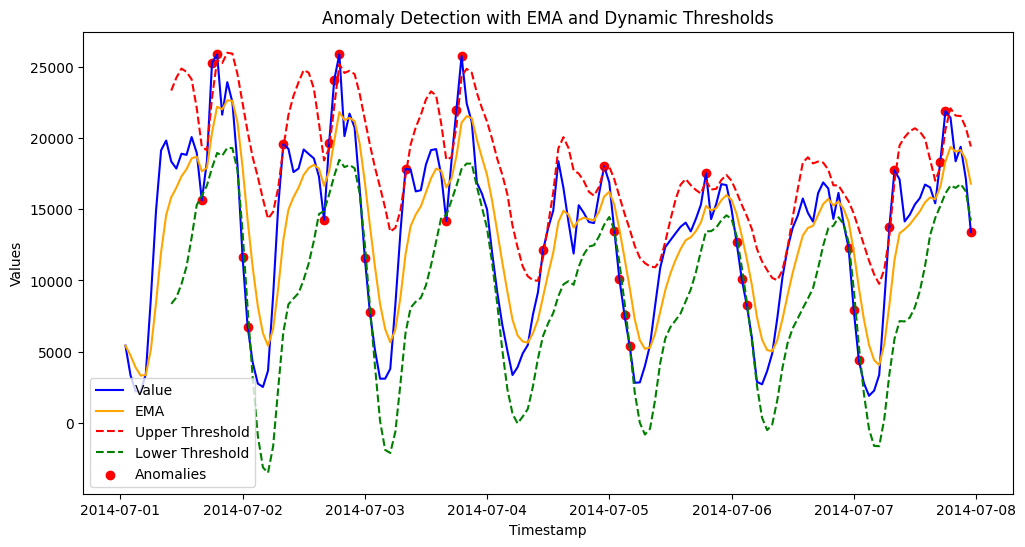

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'first_week' DataFrame is already defined and contains the 'value' column

# Calculate EMA
span = 5  # Adjust span as needed
first_week['ema'] = first_week['value'].ewm(span=span, adjust=False).mean()

# Calculate rolling standard deviation
first_week['rolling_std'] = first_week['value'].rolling(window=10).std()

# Adjusted threshold factor
threshold_factor = 1.0  # Lower threshold factor

# Define upper and lower thresholds
first_week['upper_threshold'] = first_week['ema'] + (threshold_factor * first_week['rolling_std'])
first_week['lower_threshold'] = first_week['ema'] - (threshold_factor * first_week['rolling_std'])

# Detect anomalies
first_week['anomaly'] = np.where(
    (first_week['value'] > first_week['upper_threshold']) |
    (first_week['value'] < first_week['lower_threshold']),
    1, 0
)

# Print the number of detected anomalies
detected_anomalies = first_week[first_week['anomaly'] == 1]
print(f"Detected anomalies: {detected_anomalies.shape[0]}")
print(detected_anomalies[['value', 'upper_threshold', 'lower_threshold']])

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(first_week['value'], label='Value', color='blue')
plt.plot(first_week['ema'], label='EMA', color='orange')
plt.plot(first_week['upper_threshold'], label='Upper Threshold', linestyle='--', color='red')
plt.plot(first_week['lower_threshold'], label='Lower Threshold', linestyle='--', color='green')
plt.scatter(first_week[first_week['anomaly'] == 1].index, first_week[first_week['anomaly'] == 1]['value'], color='red', label='Anomalies')
plt.title('Anomaly Detection with EMA and Dynamic Thresholds')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


Detected anomalies: 34
                       value  upper_threshold  lower_threshold
timestamp                                                     
2014-07-01 16:00:00  15620.5     19383.390828     15959.698245
2014-07-01 18:00:00  25282.0     22822.235411     17902.248621
2014-07-01 19:00:00  25865.5     25442.190207     18951.132481
2014-07-02 00:00:00  11657.5     22459.363390     13454.263467
2014-07-02 01:00:00   6744.0     20427.723584      8010.694320
2014-07-02 08:00:00  19554.5     19291.736516      6366.663343
2014-07-02 16:00:00  14261.0     18426.638918     14876.240272
2014-07-02 17:00:00  19674.5     19274.564683     16043.688110
2014-07-02 18:00:00  24072.5     22245.730587     17348.104608
2014-07-02 19:00:00  25879.5     25178.883816     18470.006314
2014-07-03 00:00:00  11604.0     21296.238043     12563.772180
2014-07-03 01:00:00   7757.0     19542.510019      8202.163463
2014-07-03 08:00:00  17844.0     17342.158827      6326.720096
2014-07-03 16:00:00  14187.0    

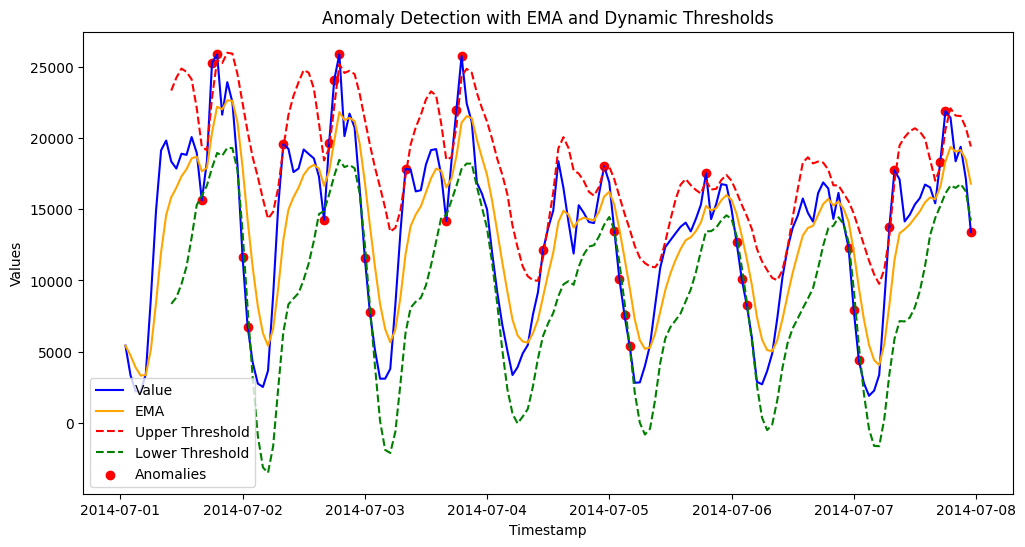

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'first_week' DataFrame is already defined and contains the 'value' column and 'Outliers' for true labels

# Calculate EMA
span = 5  # Adjust span as needed
first_week['ema'] = first_week['value'].ewm(span=span, adjust=False).mean()

# Calculate rolling standard deviation
first_week['rolling_std'] = first_week['value'].rolling(window=10).std()

# Adjusted threshold factor
threshold_factor = 1.0  # Lower threshold factor

# Define upper and lower thresholds
first_week['upper_threshold'] = first_week['ema'] + (threshold_factor * first_week['rolling_std'])
first_week['lower_threshold'] = first_week['ema'] - (threshold_factor * first_week['rolling_std'])

# Detect anomalies
first_week['anomaly'] = np.where(
    (first_week['value'] > first_week['upper_threshold']) |
    (first_week['value'] < first_week['lower_threshold']),
    1, 0
)

# Print the number of detected anomalies
detected_anomalies = first_week[first_week['anomaly'] == 1]
print(f"Detected anomalies: {detected_anomalies.shape[0]}")
print(detected_anomalies[['value', 'upper_threshold', 'lower_threshold']])

# Evaluate against existing labels
true_labels = first_week['Outliers']  # Assuming you have this column in your DataFrame
predictions = first_week['anomaly']

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, zero_division=0)
recall = recall_score(true_labels, predictions, zero_division=0)
f1 = f1_score(true_labels, predictions, zero_division=0)
conf_matrix = confusion_matrix(true_labels, predictions)

# Print the performance metrics
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(first_week['value'], label='Value', color='blue')
plt.plot(first_week['ema'], label='EMA', color='orange')
plt.plot(first_week['upper_threshold'], label='Upper Threshold', linestyle='--', color='red')
plt.plot(first_week['lower_threshold'], label='Lower Threshold', linestyle='--', color='green')
plt.scatter(first_week[first_week['anomaly'] == 1].index, first_week[first_week['anomaly'] == 1]['value'], color='red', label='Anomalies')
plt.title('Anomaly Detection with EMA and Dynamic Thresholds')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


Threshold Factor: 0.5
Detected anomalies: 83
Accuracy: 0.50
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[84 83]
 [ 0  0]]

----------------------------------------

Threshold Factor: 1.0
Detected anomalies: 34
Accuracy: 0.80
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[133  34]
 [  0   0]]

----------------------------------------

Threshold Factor: 1.5
Detected anomalies: 5
Accuracy: 0.97
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[162   5]
 [  0   0]]

----------------------------------------

Threshold Factor: 2.0
Detected anomalies: 0
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[167]]

----------------------------------------

Threshold Factor: 2.5
Detected anomalies: 0
Accuracy: 1.00
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[167]]

----------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


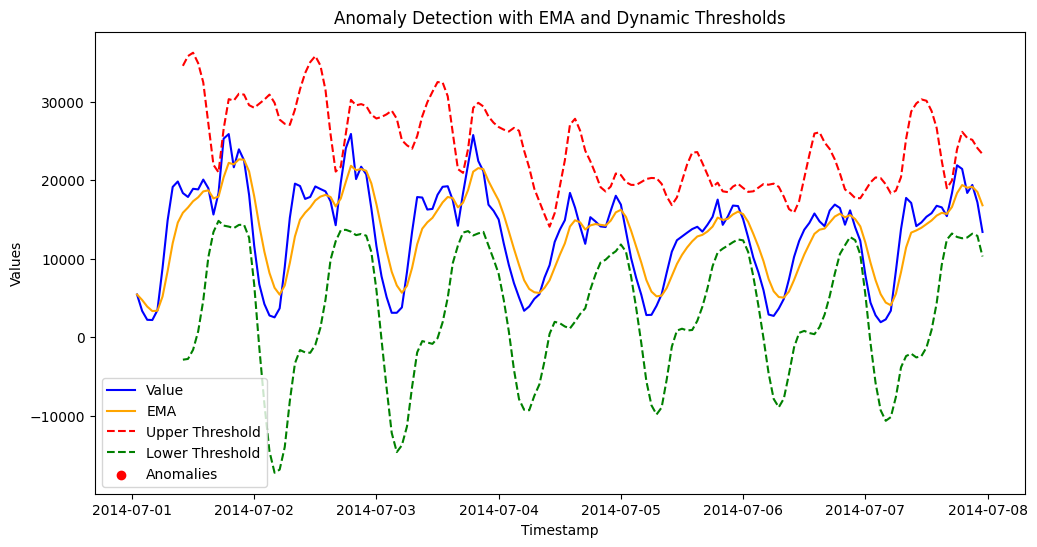

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming 'first_week' DataFrame is already defined and contains the 'value' column

# Calculate EMA
span = 5  # Adjust span as needed
first_week['ema'] = first_week['value'].ewm(span=span, adjust=False).mean()

# Calculate rolling standard deviation
first_week['rolling_std'] = first_week['value'].rolling(window=10).std()

# Define a range of threshold factors to test
threshold_factors = np.arange(0.5, 3.0, 0.5)  # Adjust the range and step as needed

# Store results for each threshold factor
results = []

# Iterate through each threshold factor
for threshold_factor in threshold_factors:
    # Define upper and lower thresholds
    first_week['upper_threshold'] = first_week['ema'] + (threshold_factor * first_week['rolling_std'])
    first_week['lower_threshold'] = first_week['ema'] - (threshold_factor * first_week['rolling_std'])

    # Detect anomalies
    first_week['anomaly'] = np.where(
        (first_week['value'] > first_week['upper_threshold']) |
        (first_week['value'] < first_week['lower_threshold']),
        1, 0
    )

    # Print the number of detected anomalies
    detected_anomalies = first_week[first_week['anomaly'] == 1]
    print(f"Threshold Factor: {threshold_factor}")
    print(f"Detected anomalies: {detected_anomalies.shape[0]}")

    # Evaluate against existing labels (assuming 'Outliers' column exists)
    true_labels = first_week['Outliers']
    predictions = first_week['anomaly']

    # Calculate performance metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Store results
    results.append({
        'threshold_factor': threshold_factor,
        'detected_anomalies': detected_anomalies.shape[0],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'conf_matrix': conf_matrix
    })

    # Print the performance metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\n" + "-"*40 + "\n")

# Visualize the results for the last threshold factor
plt.figure(figsize=(12, 6))
plt.plot(first_week['value'], label='Value', color='blue')
plt.plot(first_week['ema'], label='EMA', color='orange')
plt.plot(first_week['upper_threshold'], label='Upper Threshold', linestyle='--', color='red')
plt.plot(first_week['lower_threshold'], label='Lower Threshold', linestyle='--', color='green')
plt.scatter(first_week[first_week['anomaly'] == 1].index, first_week[first_week['anomaly'] == 1]['value'], color='red', label='Anomalies')
plt.title('Anomaly Detection with EMA and Dynamic Thresholds')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


Threshold Factor: 1.0
Detected anomalies: 1245
Accuracy: 0.76
Precision: 0.00
Recall: 0.19
F1 Score: 0.01
Confusion Matrix:
[[3892 1240]
 [  21    5]]
----------------------------------------
Threshold Factor: 1.5
Detected anomalies: 197
Accuracy: 0.96
Precision: 0.02
Recall: 0.12
F1 Score: 0.03
Confusion Matrix:
[[4938  194]
 [  23    3]]
----------------------------------------
Threshold Factor: 2.0
Detected anomalies: 0
Accuracy: 0.99
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[5132    0]
 [  26    0]]
----------------------------------------


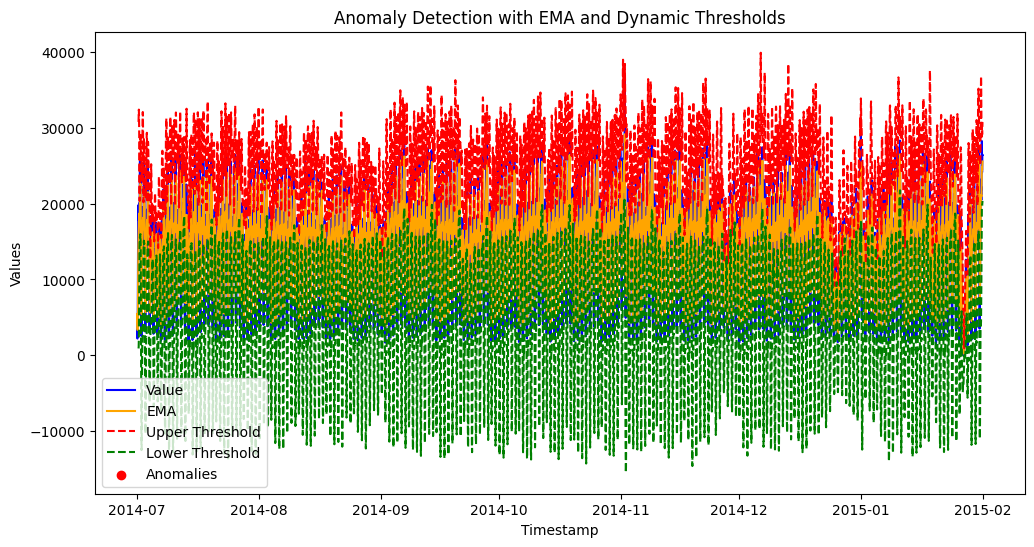

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Step 1: Load the complete dataset
# Replace 'complete_dataset.csv' with your actual file path
df_hourly = pd.read_csv('/content/processed_nyc_taxi_with_anomalies.csv')

# Ensure your dataset has the right structure
# Assuming the CSV has a 'Timestamp' and 'value' column
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])  # Convert to datetime
df_hourly.set_index('timestamp', inplace=True)

# Step 2: Calculate EMA and rolling standard deviation
span = 5  # Adjust span as needed
df_hourly['ema'] = df_hourly['value'].ewm(span=span, adjust=False).mean()
df_hourly['rolling_std'] = df_hourly['value'].rolling(window=10).std()

# Step 3: Define threshold factors for anomaly detection
threshold_factors = [1.0, 1.5, 2.0]  # Different threshold factors for testing

# Step 4: Analyze for each threshold factor
for threshold_factor in threshold_factors:
    # Define upper and lower thresholds
    df_hourly['upper_threshold'] = df_hourly['ema'] + (threshold_factor * df_hourly['rolling_std'])
    df_hourly['lower_threshold'] = df_hourly['ema'] - (threshold_factor * df_hourly['rolling_std'])

    # Detect anomalies
    df_hourly['anomaly'] = np.where(
        (df_hourly['value'] > df_hourly['upper_threshold']) |
        (df_hourly['value'] < df_hourly['lower_threshold']),
        1, 0
    )

    # Count detected anomalies
    detected_anomalies = df_hourly[df_hourly['anomaly'] == 1]
    total_anomalies = detected_anomalies.shape[0]
    print(f"Threshold Factor: {threshold_factor}")
    print(f"Detected anomalies: {total_anomalies}")

    # Evaluate against existing labels
    true_labels = df_hourly['Outliers']
    predictions = df_hourly['anomaly']

  # Check for NaN values in true_labels and predictions
    if true_labels.isnull().any() or predictions.isnull().any():
        # Remove NaN values from both true_labels and predictions
        valid_indices = true_labels.notnull() & predictions.notnull()
        true_labels = true_labels[valid_indices]
        predictions = predictions[valid_indices]

        # Calculate performance metrics only if true_labels and predictions are not empty
    if not true_labels.empty and not predictions.empty:
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
        f1 = f1_score(true_labels, predictions, zero_division=0)
        conf_matrix = confusion_matrix(true_labels, predictions)

    # Print the performance metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("----------------------------------------")

# Step 5: Visualize the results for the last threshold factor used
plt.figure(figsize=(12, 6))
plt.plot(df_hourly['value'], label='Value', color='blue')
plt.plot(df_hourly['ema'], label='EMA', color='orange')
plt.plot(df_hourly['upper_threshold'], label='Upper Threshold', linestyle='--', color='red')
plt.plot(df_hourly['lower_threshold'], label='Lower Threshold', linestyle='--', color='green')
plt.scatter(df_hourly[df_hourly['anomaly'] == 1].index, df_hourly[df_hourly['anomaly'] == 1]['value'], color='red', label='Anomalies')
plt.title('Anomaly Detection with EMA and Dynamic Thresholds')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


Threshold Factor: 1.0
Detected anomalies: 1245
Accuracy: 0.76
Precision: 0.00
Recall: 0.19
F1 Score: 0.01
Confusion Matrix:
[[3892 1240]
 [  21    5]]
----------------------------------------
Threshold Factor: 1.5
Detected anomalies: 197
Accuracy: 0.96
Precision: 0.02
Recall: 0.12
F1 Score: 0.03
Confusion Matrix:
[[4938  194]
 [  23    3]]
----------------------------------------
Threshold Factor: 2.0
Detected anomalies: 0
Accuracy: 0.99
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[5132    0]
 [  26    0]]
----------------------------------------
Threshold Factor: 3.0
Detected anomalies: 0
Accuracy: 0.99
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[5132    0]
 [  26    0]]
----------------------------------------


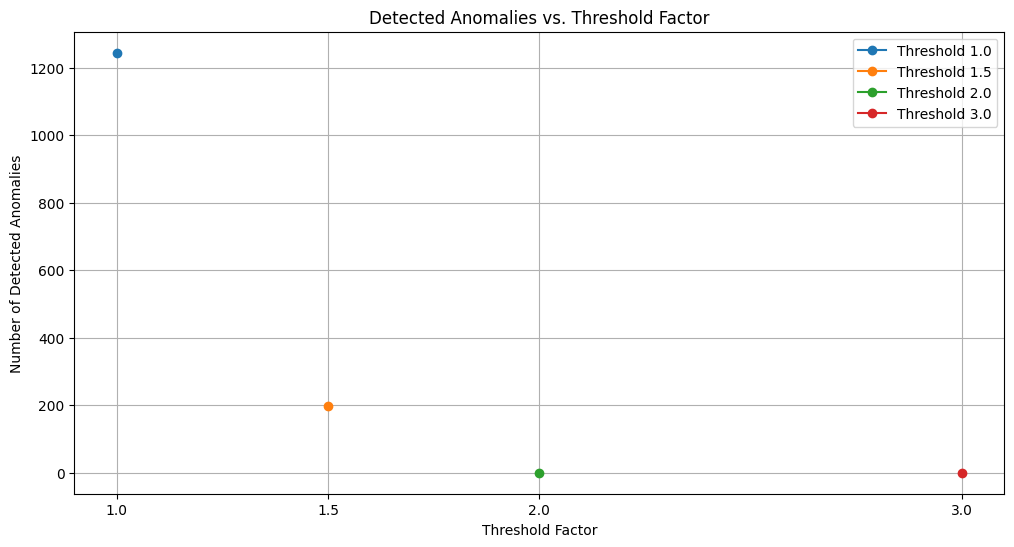

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming df_hourly is already defined and contains the necessary data
threshold_factors = [1.0, 1.5, 2.0, 3.0]  # Lower starting point for thresholds
results = []

for threshold_factor in threshold_factors:
    # Recalculate upper and lower thresholds
    df_hourly['upper_threshold'] = df_hourly['ema'] + (threshold_factor * df_hourly['rolling_std'])
    df_hourly['lower_threshold'] = df_hourly['ema'] - (threshold_factor * df_hourly['rolling_std'])

    # Detect anomalies
    df_hourly['anomaly'] = np.where(
        (df_hourly['value'] > df_hourly['upper_threshold']) |
        (df_hourly['value'] < df_hourly['lower_threshold']),
        1, 0
    )

    # Count detected anomalies
    detected_anomalies = df_hourly[df_hourly['anomaly'] == 1]
    total_anomalies = detected_anomalies.shape[0]
    print(f"Threshold Factor: {threshold_factor}")
    print(f"Detected anomalies: {total_anomalies}")

    # Evaluate against existing labels
    true_labels = df_hourly['Outliers']
    predictions = df_hourly['anomaly']

    # Remove NaN values from true_labels and predictions
    valid_indices = true_labels.notnull() & predictions.notnull()
    true_labels = true_labels[valid_indices]
    predictions = predictions[valid_indices]

    # Calculate performance metrics only if true_labels and predictions are not empty
    if not true_labels.empty and not predictions.empty:
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
        f1 = f1_score(true_labels, predictions, zero_division=0)
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Collect results
        results.append({
            'Threshold Factor': threshold_factor,
            'Detected Anomalies': total_anomalies,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': conf_matrix
        })

        # Print the performance metrics
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print("Confusion Matrix:")
        print(conf_matrix)
    else:
        print("No valid labels to calculate metrics.")

    print("----------------------------------------")

# Visualization of the results
plt.figure(figsize=(12, 6))
for result in results:
    plt.plot(result['Threshold Factor'], result['Detected Anomalies'], marker='o', label=f"Threshold {result['Threshold Factor']}")

plt.title('Detected Anomalies vs. Threshold Factor')
plt.xlabel('Threshold Factor')
plt.ylabel('Number of Detected Anomalies')
plt.xticks(threshold_factors)
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd

def run_ema_anomaly_detection(data: pd.DataFrame, span: int, threshold_factor: float = 1.5) -> pd.DataFrame:
    # Calculate EMA and rolling statistics
    data['EMA'] = data['value'].ewm(span=span, adjust=False).mean()
    data['Rolling_Std'] = data['value'].rolling(window=span).std().fillna(0)

    # Define thresholds for anomaly detection
    data['Upper_Threshold'] = data['EMA'] + (threshold_factor * data['Rolling_Std'])
    data['Lower_Threshold'] = data['EMA'] - (threshold_factor * data['Rolling_Std'])

    # Anomaly detection based on EMA thresholds
    data['Anomaly'] = ((data['value'] > data['Upper_Threshold']) |
                       (data['value'] < data['Lower_Threshold'])).astype(int)

    # Calculate Z-score as an additional anomaly metric
    data['Z_Score'] = (data['value'] - data['value'].mean()) / data['value'].std()
    data['Anomaly_Z'] = (data['Z_Score'].abs() > 2).astype(int)  # Adjust threshold as needed

    # Combine anomalies detected by EMA and Z-score
    data['Combined_Anomaly'] = data[['Anomaly', 'Anomaly_Z']].max(axis=1)

    return data

# Run the function and evaluate
df_hourly = run_ema_anomaly_detection(df_hourly, span=30, threshold_factor=3)

# Count anomalies
total_anomalies = df_hourly['Combined_Anomaly'].sum()
print(f"Total number of combined anomalies found: {total_anomalies}")

# Display DataFrame to check the anomalies detected
print(df_hourly[['timestamp', 'value', 'EMA', 'Upper_Threshold', 'Lower_Threshold',
                 'Anomaly', 'Anomaly_Z', 'Combined_Anomaly']])


Total number of combined anomalies found: 43
                timestamp    value           EMA  Upper_Threshold  \
0     2014-07-01 01:00:00   5433.0   5433.000000      5433.000000   
1     2014-07-01 02:00:00   3346.5   5298.387097      5298.387097   
2     2014-07-01 03:00:00   2216.5   5099.555671      5099.555671   
3     2014-07-01 04:00:00   2189.5   4911.810144      4911.810144   
4     2014-07-01 05:00:00   3439.5   4816.822393      4816.822393   
...                   ...      ...           ...              ...   
5154  2015-01-31 19:00:00  28288.5  19113.666382     40854.824319   
5155  2015-01-31 20:00:00  24138.0  19437.816938     41338.529774   
5156  2015-01-31 21:00:00  24194.5  19744.699716     41776.363719   
5157  2015-01-31 22:00:00  26515.0  20181.493283     42373.382903   
5158  2015-01-31 23:00:00  26439.5  20585.235651     43048.232079   

      Lower_Threshold  Anomaly  Anomaly_Z  Combined_Anomaly  
0         5433.000000        0          0                 0  
1 

In [ ]:
print(df_hourly.columns)  # Check available columns


Index(['timestamp', 'value', 'EMA', 'Upper_Threshold', 'Lower_Threshold',
       'Rolling_Std', 'Anomaly', 'Score', 'Z_Score', 'Anomaly_Z',
       'Combined_Anomaly'],
      dtype='object')


Total number of combined anomalies found: 20


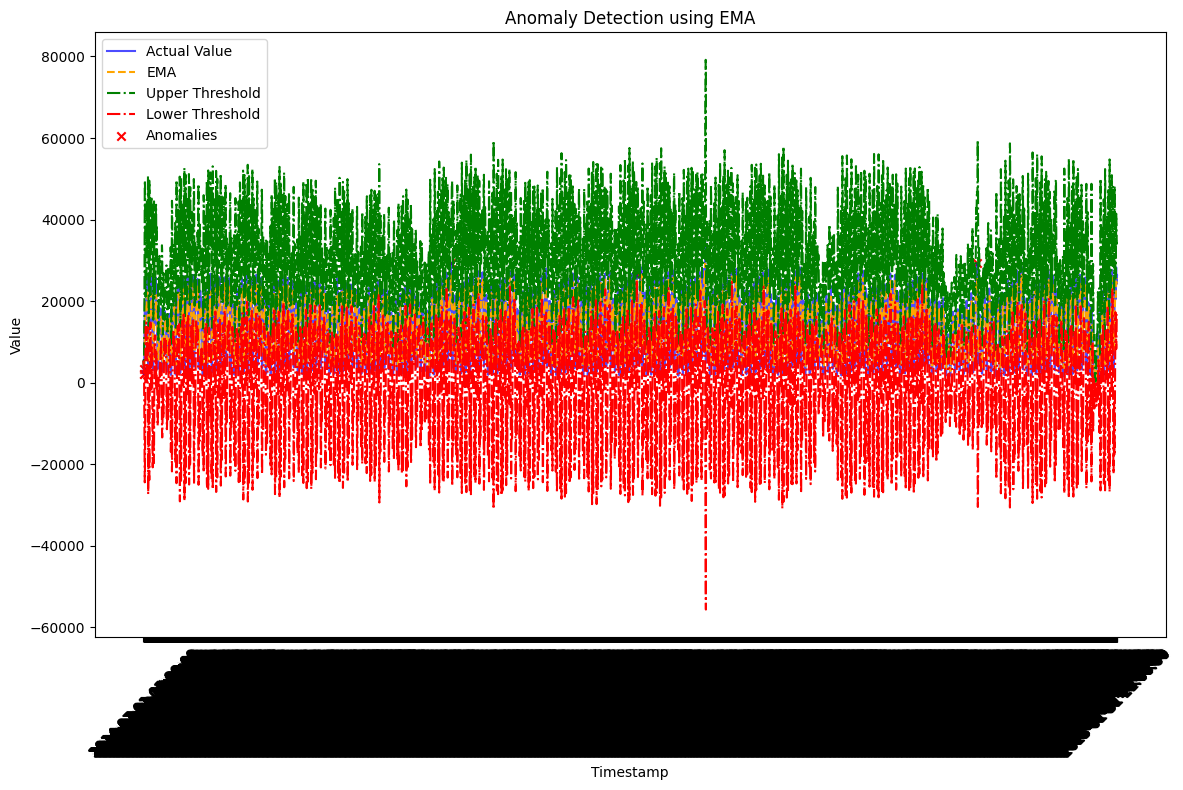

Precision: 0.65
Recall: 0.50
Accuracy: 1.00
F1 Score: 0.57

Confusion Matrix:
True Positives (TP): 13
True Negatives (TN): 5125
False Positives (FP): 7
False Negatives (FN): 13

Confusion Matrix (formatted):
               Predicted 1    Predicted 0    
Actual 1       13             13             
Actual 0       7              5125           
                timestamp    value           EMA  Upper_Threshold  \
0     2014-07-01 01:00:00   5433.0   5433.000000      5433.000000   
1     2014-07-01 02:00:00   3346.5   4737.500000      4737.500000   
2     2014-07-01 03:00:00   2216.5   3897.166667      3897.166667   
3     2014-07-01 04:00:00   2189.5   3327.944444      3327.944444   
4     2014-07-01 05:00:00   3439.5   3365.129630      9967.860599   
...                   ...      ...           ...              ...   
5154  2015-01-31 19:00:00  28288.5  24844.968128     41453.191111   
5155  2015-01-31 20:00:00  24138.0  24609.312086     40539.372938   
5156  2015-01-31 21:00:00  24194.

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/processed_nyc_taxi_with_anomalies.csv'  # Replace with your dataset path
df_hourly = pd.read_csv(file_path)

# Function for anomaly detection using EMA
def run_ema_anomaly_detection(data: pd.DataFrame, span: int, threshold_factor: float = 1.5) -> pd.DataFrame:
    data_copy = data.copy()

    data_copy['EMA'] = data_copy['value'].ewm(span=span, adjust=False).mean()
    data_copy['Rolling_Std'] = data_copy['value'].rolling(window=span).std().fillna(0)

    data_copy['Upper_Threshold'] = data_copy['EMA'] + (threshold_factor * data_copy['Rolling_Std'])
    data_copy['Lower_Threshold'] = data_copy['EMA'] - (threshold_factor * data_copy['Rolling_Std'])

    data_copy['Anomaly'] = ((data_copy['value'] > data_copy['Upper_Threshold']) |
                             (data_copy['value'] < data_copy['Lower_Threshold'])).astype(int)

    data_copy['Z_Score'] = (data_copy['value'] - data_copy['value'].mean()) / data_copy['value'].std()
    data_copy['Anomaly_Z'] = (data_copy['Z_Score'].abs() > 2).astype(int)

    data_copy['Combined_Anomaly'] = data_copy[['Anomaly', 'Anomaly_Z']].max(axis=1)

    return data_copy

def calculate_confusion_matrix(df: pd.DataFrame) -> (float, float, float):
    TP = len(df[(df['Combined_Anomaly'] == 1) & (df['Outliers'] == 1)])
    TN = len(df[(df['Combined_Anomaly'] == 0) & (df['Outliers'] == 0)])
    FP = len(df[(df['Combined_Anomaly'] == 1) & (df['Outliers'] == 0)])
    FN = len(df[(df['Combined_Anomaly'] == 0) & (df['Outliers'] == 1)])

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    return precision, recall, accuracy, TP, TN, FP, FN

def print_confusion_matrix(TP, TN, FP, FN):
    print("\nConfusion Matrix:")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print("\nConfusion Matrix (formatted):")
    print(f"{'':<15}{'Predicted 1':<15}{'Predicted 0':<15}")
    print(f"{'Actual 1':<15}{TP:<15}{FN:<15}")
    print(f"{'Actual 0':<15}{FP:<15}{TN:<15}")

# Run the anomaly detection
df_hourly = run_ema_anomaly_detection(df_hourly, span=5, threshold_factor=5)

# Count anomalies
total_anomalies = df_hourly['Combined_Anomaly'].sum()
print(f"Total number of combined anomalies found: {total_anomalies}")

# Calculate precision, recall, accuracy, and confusion matrix
if 'Outliers' in df_hourly.columns:
    precision, recall, accuracy, TP, TN, FP, FN = calculate_confusion_matrix(df_hourly)

    # Calculate F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Print the metrics
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    # Print the confusion matrix
    print_confusion_matrix(TP, TN, FP, FN)
else:
    print("Error: 'Outliers' column not found in the DataFrame.")

# Display relevant columns to verify results
print(df_hourly[['timestamp', 'value', 'EMA', 'Upper_Threshold', 'Lower_Threshold',
                 'Anomaly', 'Anomaly_Z', 'Combined_Anomaly']])


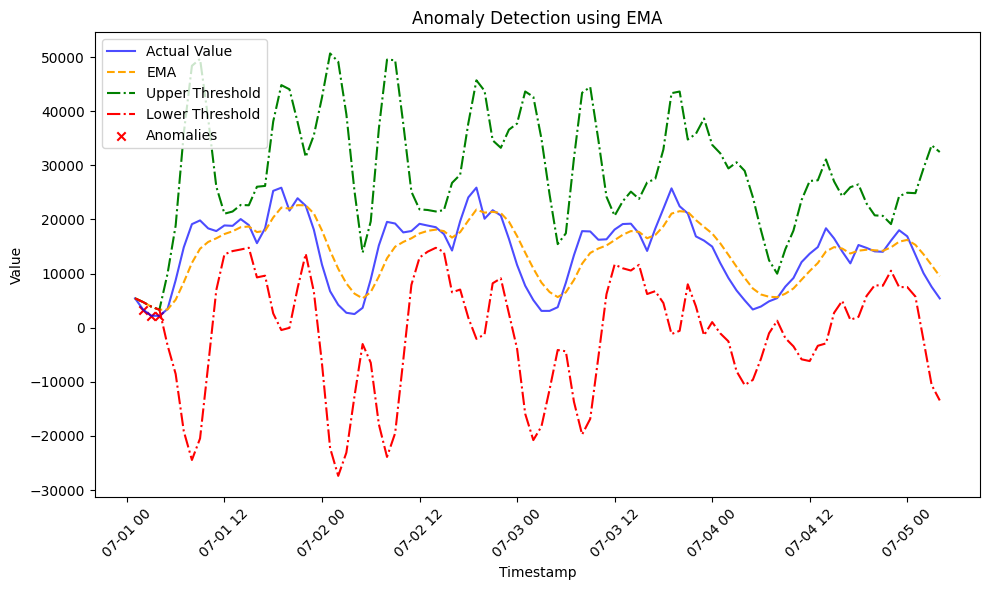

In [ ]:
import matplotlib.pyplot as plt

# Select a subset of points for visualization (e.g., first 100 rows)
df_subset = df_hourly.head(100)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the actual data points
plt.plot(df_subset['timestamp'], df_subset['value'], label='Actual Value', color='blue', alpha=0.7)

# Plot the Exponential Moving Average (EMA)
plt.plot(df_subset['timestamp'], df_subset['EMA'], label='EMA', color='orange', linestyle='--')

# Plot the upper and lower thresholds
plt.plot(df_subset['timestamp'], df_subset['Upper_Threshold'], label='Upper Threshold', color='green', linestyle='-.')
plt.plot(df_subset['timestamp'], df_subset['Lower_Threshold'], label='Lower Threshold', color='red', linestyle='-.')

# Mark anomalies with a scatter plot
anomalies = df_subset[df_subset['Combined_Anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], label='Anomalies', color='red', marker='x')

# Customize the plot
plt.title('Anomaly Detection using EMA')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


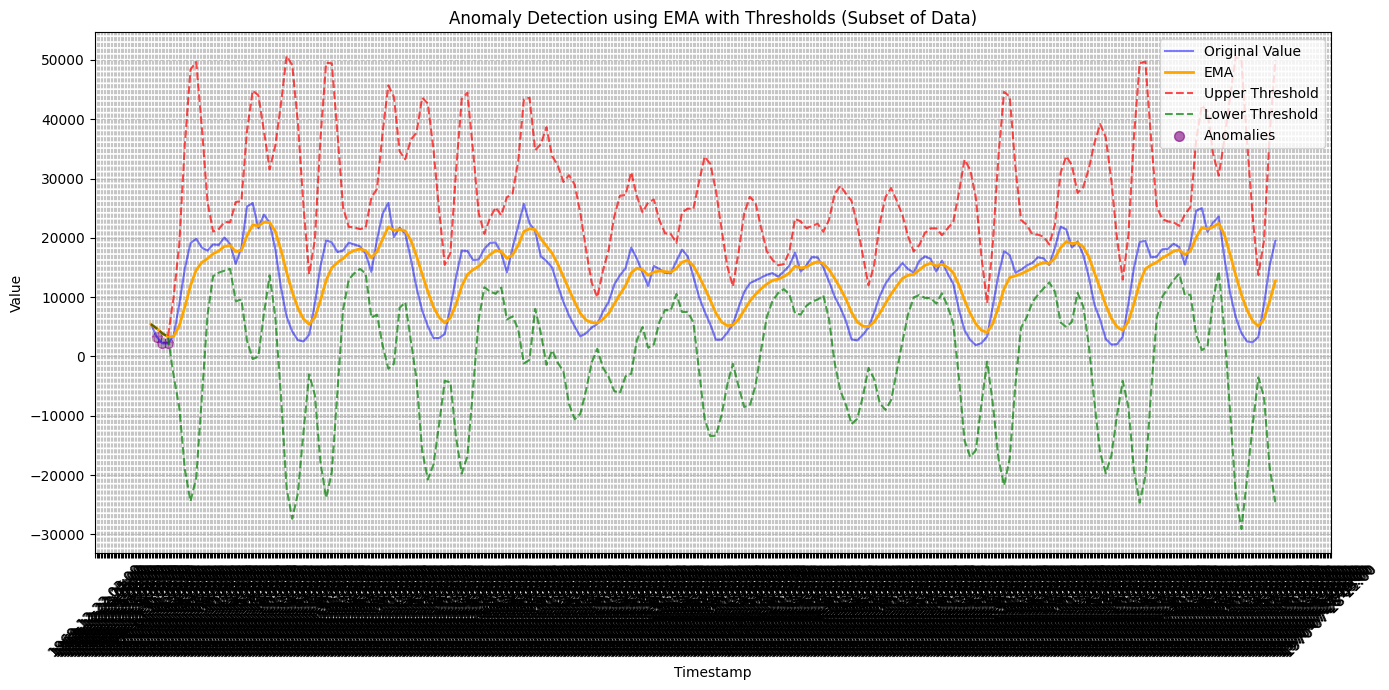

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 7))

# Plot only a smaller subset of data for better visibility
subset_df = df_hourly.iloc[:200]  # Adjust this to a smaller number if needed, e.g., 100-200 points

# Plot the original time series values
plt.plot(subset_df['timestamp'], subset_df['value'], label='Original Value', color='blue', alpha=0.5)

# Plot the EMA
plt.plot(subset_df['timestamp'], subset_df['EMA'], label='EMA', color='orange', linewidth=2)

# Plot the upper and lower thresholds with transparency
plt.plot(subset_df['timestamp'], subset_df['Upper_Threshold'], label='Upper Threshold', color='red', linestyle='--', alpha=0.7)
plt.plot(subset_df['timestamp'], subset_df['Lower_Threshold'], label='Lower Threshold', color='green', linestyle='--', alpha=0.7)

# Highlight anomalies
anomalies = subset_df[subset_df['Combined_Anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='purple', label='Anomalies', s=50, alpha=0.6)

# Customize plot with better ticks and labels
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection using EMA with Thresholds (Subset of Data)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid

# Format x-axis for better readability if it's datetime
plt.xticks(rotation=45)

# Use DayLocator or set a larger interval for HourLocator to reduce ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Increase interval to reduce ticks
# Alternatively, for daily ticks use this instead: plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Show the plot
plt.tight_layout()
plt.show()


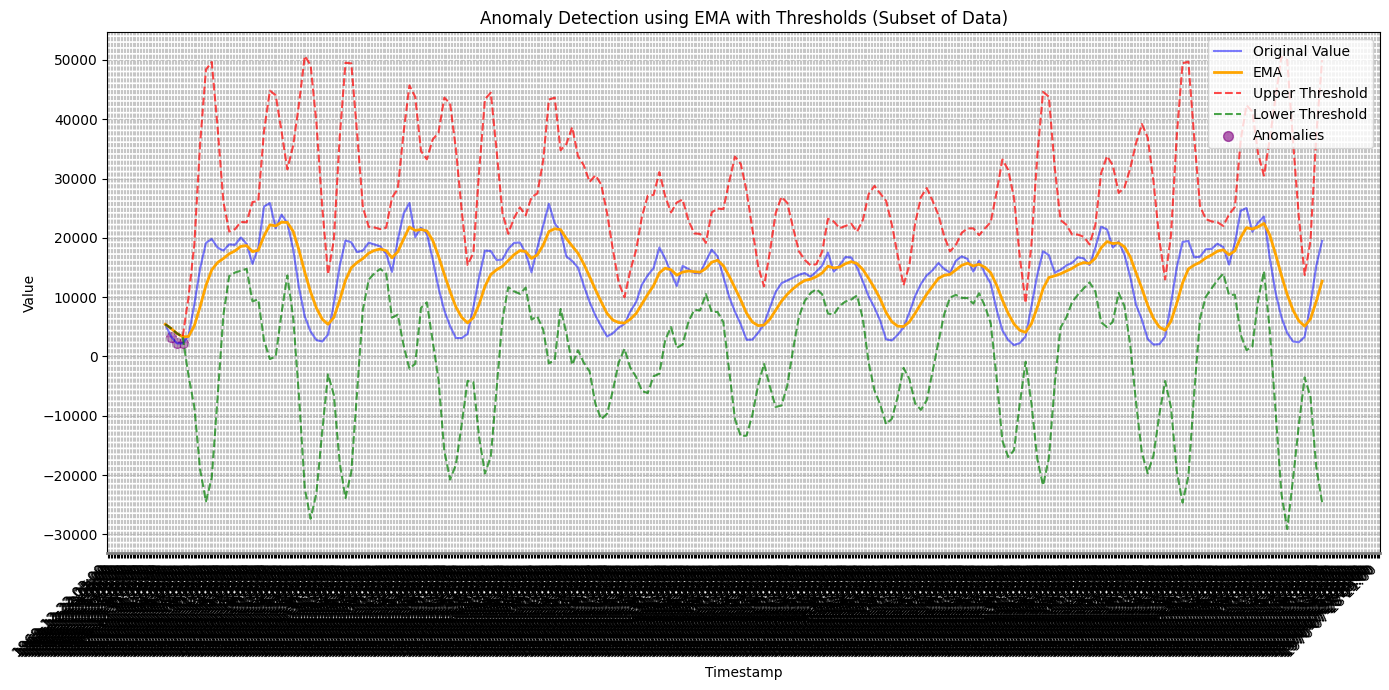

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 7))

# Plot only a smaller subset of data for better visibility
subset_df = df_hourly.iloc[:200]  # Adjust this to a smaller number if needed, e.g., 100-200 points

# Plot the original time series values
plt.plot(subset_df['timestamp'], subset_df['value'], label='Original Value', color='blue', alpha=0.5)

# Plot the EMA
plt.plot(subset_df['timestamp'], subset_df['EMA'], label='EMA', color='orange', linewidth=2)

# Plot the upper and lower thresholds with transparency
plt.plot(subset_df['timestamp'], subset_df['Upper_Threshold'], label='Upper Threshold', color='red', linestyle='--', alpha=0.7)
plt.plot(subset_df['timestamp'], subset_df['Lower_Threshold'], label='Lower Threshold', color='green', linestyle='--', alpha=0.7)

# Highlight anomalies
anomalies = subset_df[subset_df['Combined_Anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='purple', label='Anomalies', s=50, alpha=0.6)

# Customize plot with better ticks and labels
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection using EMA with Thresholds (Subset of Data)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid

# Format x-axis for better readability if it's datetime
plt.xticks(rotation=45, ha='right')

# Use DayLocator or set a larger interval for HourLocator to reduce ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Increase interval to reduce ticks
# Alternatively, for daily ticks use this instead: plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Set plot background color
plt.gcf().set_facecolor('white')  # Set figure background to white
plt.gca().set_facecolor('white')  # Set axes background to white

# Set color for x-axis (spine)
plt.gca().spines['bottom'].set_color('gray')  # Change bottom x-axis line color to gray
plt.gca().spines['bottom'].set_linewidth(2)  # Make the x-axis line slightly thicker

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_hourly is your DataFrame with your dataset
# First, let's ensure the 'timestamp' column is a datetime object
df_hourly['timestamp'] = pd.to_datetime(df_hourly['timestamp'])

# Set the figure size
plt.figure(figsize=(14, 7))

# Plot only a smaller subset of data for better visibility
subset_df = df_hourly.iloc[:200]  # Adjust this to a smaller number if needed, e.g., 100-200 points

# Plot the original time series values
plt.plot(subset_df['timestamp'], subset_df['value'], label='Original Value', color='blue', alpha=0.5)

# Plot the EMA
plt.plot(subset_df['timestamp'], subset_df['EMA'], label='EMA', color='orange', linewidth=2)

# Plot the upper and lower thresholds with transparency
plt.plot(subset_df['timestamp'], subset_df['Upper_Threshold'], label='Upper Threshold', color='red', linestyle='--', alpha=0.7)
plt.plot(subset_df['timestamp'], subset_df['Lower_Threshold'], label='Lower Threshold', color='green', linestyle='--', alpha=0.7)

# Highlight anomalies
# Assuming 'Combined_Anomaly' column indicates where anomalies occur (1 for anomaly, 0 for no anomaly)
anomalies = subset_df[subset_df['Combined_Anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='purple', label='Anomalies', s=50, alpha=0.6)

# Customize plot with better ticks and labels
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection using EMA with Thresholds (Subset of Data)')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid

# Format x-axis for better readability if it's datetime
plt.xticks(rotation=45, ha='right')

# Use DayLocator or set a larger interval for HourLocator to reduce ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Increase interval to reduce ticks
# Alternatively, for daily ticks use this instead: plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Set plot background color
plt.gcf().set_facecolor('white')  # Set figure background to white
plt.gca().set_facecolor('white')  # Set axes background to white

# Set color for x-axis (spine)
plt.gca().spines['bottom'].set_color('gray')  # Change bottom x-axis line color to gray
plt.gca().spines['bottom'].set_linewidth(2)  # Make the x-axis line slightly thicker

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'df_hourly' is not defined

In [ ]:
# Step 1: Prepare the data for Prophet

# Rename the columns as required by Prophet
first_week_prophet = first_week[['cpu|demandPct']].reset_index()  # Reset index to turn 'timestamp' into a column
first_week_prophet.rename(columns={'timestamp': 'ds', 'cpu|demandPct': 'y'}, inplace=True)

# Check the first few rows to ensure it looks correct
print(first_week_prophet.head())


KeyError: "None of [Index(['cpu|demandPct'], dtype='object')] are in the [columns]"

In [ ]:
# Step 1: Check the columns of the dataframe
print(first_week.columns)


Index(['ds', 'y'], dtype='object')


In [ ]:
from prophet import Prophet

# Step 2: Initialize and fit the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(first_week)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjuu8ppu/0p5h45nz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyjuu8ppu/v4z56umw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68885', 'data', 'file=/tmp/tmpyjuu8ppu/0p5h45nz.json', 'init=/tmp/tmpyjuu8ppu/v4z56umw.json', 'output', 'file=/tmp/tmpyjuu8ppu/prophet_modeliakgp1xu/prophet_model-20241126063002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:30:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Step 3: Make predictions for the same period (no extra future points)
# Ensure you pass the dataframe (first_week) and then the periods argument
future = model.make_future_dataframe(df=first_week, periods=0)  # passing the data correctly

# Generate the forecast
forecast = model.predict(future)

# Display the forecasted values (including predicted values and confidence intervals)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


TypeError: Prophet.make_future_dataframe() got multiple values for argument 'periods'